# Read Data

In [1]:
import pandas as pd

def load_and_clean_data(csv_file):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_file)

    # # Drop unnecessary columns
    # df.drop(columns=['coin', 'volume', 'closetime', 'quotevolume', 'trades', 'taker_buy_volume', 'taker_buy_quote', 'unused'], inplace=True)

    # Return the cleaned DataFrame
    return df

In [15]:
df = load_and_clean_data('SOLUSDT_30m.csv')
df

,opentime,openprice,highprice,lowprice,closeprice
0,1600066800000,3.2002,4.9100,3.2002,3.3880
1,1600068600000,3.3878,3.4035,3.2983,3.3666
2,1600070400000,3.3663,3.4645,3.3078,3.4450
3,1600072200000,3.4498,3.5650,3.3000,3.3298
4,1600074000000,3.3298,3.3567,3.2161,3.2695
...,...,...,...,...,...
76257,1737329400000,242.0500,254.8900,237.6900,252.5200
76258,1737331200000,252.4900,252.6900,244.5200,247.0900
76259,1737333000000,247.0800,250.6500,235.3000,236.0400
76260,1737334800000,236.0500,245.9500,235.6710,244.9500


# Fetch Data

In [192]:
import requests
import pandas as pd
from datetime import datetime
from tqdm import tqdm

BINANCE_CANDLE_COLUMNS = ['opentime', 'openprice', 'highprice', 'lowprice', 'closeprice', 'volume', 'closetime',
                          'quotevolume', 'trades', 'taker_buy_volume', 'taker_buy_quote', 'unused']

def binance_recursive_fetch_2(coins, interval, starttime, endtime, data_type='spot'):
    all_coins_result = {}
    data_list = []
    call_dict = {}
    
    for coin in tqdm(coins):
        result_list = []
        current_time = starttime
        call = 0
        timestamps = []
        
        while current_time < endtime:
            if ((int((endtime - current_time) / (1000 * 60))) + 1) >= 1000:
                limit = 1000
            else:
                limit = int((endtime - current_time) / (1000 * 60) + 1)
            
            if data_type == 'spot':
                url = (f'https://api.binance.com/api/v3/klines'
                       f'?symbol={coin}USDT'
                       f'&startTime={str(current_time)}'
                       f'&interval={interval}'
                       f'&limit={str(limit)}')
            elif data_type == 'futures':
                url = (f'https://fapi.binance.com/fapi/v1/klines'
                       f'?symbol={coin}USDT'
                       f'&startTime={str(current_time)}'
                       f'&interval={interval}'
                       f'&limit={str(limit)}')
            
            result_list += requests.get(url).json()
            
            if result_list:
                # Update current_time with the timestamp of the last data point fetched, plus 1 minute (60000 ms)
                current_time = result_list[-1][0] + 60000
                timestamps.append(current_time)
                call += 1
                
                # Check if the last fetched timestamp is greater than or equal to endtime
                if current_time >= endtime:
                    print(f"Reached endtime at {datetime.fromtimestamp(current_time / 1000).strftime('%Y-%m-%d %H:%M:%S')}. Stopping fetch.")
                    break
                
                print((datetime.fromtimestamp(current_time / 1000).strftime('%Y-%m-%d %H:%M:%S')) + 
                      f' status : {current_time < endtime}, time : {current_time}, limit : {call * 2}')
            
            # Ensure there's no continuous fetching of the same timestamp
            if len(timestamps) > 1 and timestamps[-1] == timestamps[-2]:
                print("Duplicate timestamp detected. Stopping fetch.")
                break
            
            # Sleep if needed to avoid rate limiting (adjust based on your rate limit)
            # time.sleep(0.1)  # Uncomment if needed
            
        current_df = pd.DataFrame(result_list, columns=BINANCE_CANDLE_COLUMNS)
        current_df['coin'] = coin
        current_df = current_df[['coin'] + BINANCE_CANDLE_COLUMNS]
        current_df = current_df.values.tolist()
        
        data_list += current_df
        call_dict.update({coin: call})
    
    return {'data': data_list, 'call': call_dict}

In [247]:
# Fetch COIN USDT
sample_spot = binance_recursive_fetch_2(
    ['BNB'],
    '30m',
    starttime=int(pd.to_datetime('2000-11-01 00:00', utc=True).timestamp() * 1000),
    endtime=int(pd.to_datetime('2026-01-01 00:00', utc=True).timestamp() * 1000),
    data_type='futures'  # Fetch futures/sport
)

# Define the column names for the DataFrame based on the Binance API response structure
columns = ['coin', 'opentime', 'openprice', 'highprice', 'lowprice', 'closeprice', 'volume', 'closetime', 
           'quotevolume', 'trades', 'taker_buy_volume', 'taker_buy_quote', 'unused']

# Convert the list of data into a DataFrame
df = pd.DataFrame(sample_spot['data'], columns=columns)

# Drop unnecessary columns
df.drop(columns=(['coin','volume','closetime','quotevolume','trades','taker_buy_volume','taker_buy_quote','unused']), inplace=True)

# Convert columns 1-4 (openprice, highprice, lowprice, closeprice) to float
df[['openprice', 'highprice', 'lowprice', 'closeprice']] = df[['openprice', 'highprice', 'lowprice', 'closeprice']].apply(pd.to_numeric, errors='coerce')

# # add date filter
# df = df[df['opentime'] <= 1735689600000] # end of 2024

# Show the first few rows of the DataFrame
df

  0%|          | 0/1 [00:00<?, ?it/s]

2020-03-02 03:31:00 status : True, time : 1583119860000, limit : 2
2020-03-22 23:31:00 status : True, time : 1584919860000, limit : 4
2020-04-12 19:31:00 status : True, time : 1586719860000, limit : 6
2020-05-03 15:31:00 status : True, time : 1588519860000, limit : 8
2020-05-24 11:31:00 status : True, time : 1590319860000, limit : 10
2020-06-14 07:31:00 status : True, time : 1592119860000, limit : 12
2020-07-05 03:31:00 status : True, time : 1593919860000, limit : 14
2020-07-25 23:31:00 status : True, time : 1595719860000, limit : 16
2020-08-15 19:31:00 status : True, time : 1597519860000, limit : 18
2020-09-05 15:31:00 status : True, time : 1599319860000, limit : 20
2020-09-26 11:31:00 status : True, time : 1601119860000, limit : 22
2020-10-17 07:31:00 status : True, time : 1602919860000, limit : 24
2020-11-07 03:31:00 status : True, time : 1604719860000, limit : 26
2020-11-27 23:31:00 status : True, time : 1606519860000, limit : 28
2020-12-18 19:31:00 status : True, time : 1608319860

100%|██████████| 1/1 [00:28<00:00, 28.35s/it]


,opentime,openprice,highprice,lowprice,closeprice
0,1581321600000,25.070,25.907,24.810,25.710
1,1581323400000,25.720,25.750,24.780,25.053
2,1581325200000,25.054,25.054,24.204,24.326
3,1581327000000,24.301,24.751,24.100,24.650
4,1581328800000,24.653,24.653,24.031,24.326
...,...,...,...,...,...
86686,1737356400000,704.400,709.990,700.390,702.600
86687,1737358200000,702.580,702.970,696.660,699.130
86688,1737360000000,699.150,701.770,698.720,699.670
86689,1737361800000,699.610,701.000,698.800,700.680


In [248]:
# # Assuming df is your Pandas DataFrame
# df.to_csv("BNBUSDT_30m.csv", index=False)

# Add Super Trend Indicator

In [5]:
import pandas as pd
import numpy as np
from pandas_ta.overlap import hl2
from pandas_ta.volatility import atr
from pandas_ta.utils import get_offset, verify_series

npNaN = np.nan

def calculate_supertrend(df, high_col='highprice', low_col='lowprice', close_col='closeprice', length=10, multiplier=3.0, offset=0, drop_columns=True, **kwargs):
    """
    Calculate the Supertrend indicator and merge it with the original DataFrame.
    
    Parameters:
        df (DataFrame): Original DataFrame containing the OHLC data.
        high_col (str): Name of the high price column. Default is 'highprice'.
        low_col (str): Name of the low price column. Default is 'lowprice'.
        close_col (str): Name of the close price column. Default is 'closeprice'.
        length (int): Lookback period for ATR calculation. Default is 10.
        multiplier (float): Multiplier for ATR. Default is 3.0.
        offset (int): Number of periods to shift the result. Default is 0.
        drop_columns (bool): Whether to drop intermediate columns. Default is True.
        **kwargs: Additional arguments for handling NaN values (e.g., fillna).
    
    Returns:
        DataFrame: The original DataFrame with Supertrend columns merged.
    """
    # Validate Arguments
    high = verify_series(df[high_col], length)
    low = verify_series(df[low_col], length)
    close = verify_series(df[close_col], length)
    offset = get_offset(offset)

    if high is None or low is None or close is None:
        return df

    m = close.size
    dir_, trend = [1] * m, [0] * m
    long, short = [np.nan] * m, [np.nan] * m

    hl2_ = hl2(high, low)
    matr = multiplier * atr(high, low, close, length)
    upperband = hl2_ + matr
    lowerband = hl2_ - matr

    for i in range(1, m):
        if close.iloc[i] > upperband.iloc[i - 1]:
            dir_[i] = 1
        elif close.iloc[i] < lowerband.iloc[i - 1]:
            dir_[i] = -1
        else:
            dir_[i] = dir_[i - 1]
            if dir_[i] > 0 and lowerband.iloc[i] < lowerband.iloc[i - 1]:
                lowerband.iloc[i] = lowerband.iloc[i - 1]
            if dir_[i] < 0 and upperband.iloc[i] > upperband.iloc[i - 1]:
                upperband.iloc[i] = upperband.iloc[i - 1]

        if dir_[i] > 0:
            trend[i] = long[i] = lowerband.iloc[i]
        else:
            trend[i] = short[i] = upperband.iloc[i]

    _props = f"_{length}_{multiplier}"
    supertrend_df = pd.DataFrame({
        f"SUPERT{_props}": trend,
        f"SUPERTd{_props}": dir_,
        f"SUPERTl{_props}": long,
        f"SUPERTs{_props}": short,
    }, index=close.index)

    # Apply offset if needed
    if offset != 0:
        supertrend_df = supertrend_df.shift(offset)

    # Handle fills
    if "fillna" in kwargs:
        supertrend_df.fillna(kwargs["fillna"], inplace=True)
    if "fill_method" in kwargs:
        supertrend_df.fillna(method=kwargs["fill_method"], inplace=True)

    # Merge with original DataFrame
    result_df = df.join(supertrend_df)

    # Drop unnecessary columns
    if drop_columns:
        result_df.drop(columns=[f"SUPERT{_props}", f"SUPERTd{_props}"], inplace=True)

    return result_df

In [16]:
# Example usage
supertrend_df = calculate_supertrend(df, length=10, multiplier=3.0)
supertrend_df

,opentime,openprice,highprice,lowprice,closeprice,SUPERTl_10_3.0,SUPERTs_10_3.0
0,1600066800000,3.2002,4.9100,3.2002,3.3880,NaN,NaN
1,1600068600000,3.3878,3.4035,3.2983,3.3666,NaN,NaN
2,1600070400000,3.3663,3.4645,3.3078,3.4450,NaN,NaN
3,1600072200000,3.4498,3.5650,3.3000,3.3298,NaN,NaN
4,1600074000000,3.3298,3.3567,3.2161,3.2695,NaN,NaN
...,...,...,...,...,...,...,...
76257,1737329400000,242.0500,254.8900,237.6900,252.5200,NaN,277.483079
76258,1737331200000,252.4900,252.6900,244.5200,247.0900,NaN,277.483079
76259,1737333000000,247.0800,250.6500,235.3000,236.0400,NaN,276.512070
76260,1737334800000,236.0500,245.9500,235.6710,244.9500,NaN,274.077563


/tmp/ipykernel_2410207/1481444997.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  supertrend_df_sample['opentime'] = pd.to_datetime(supertrend_df_sample['opentime'], unit='ms')
/tmp/ipykernel_2410207/1481444997.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  supertrend_df_sample['date_num'] = mdates.date2num(supertrend_df_sample['opentime'])


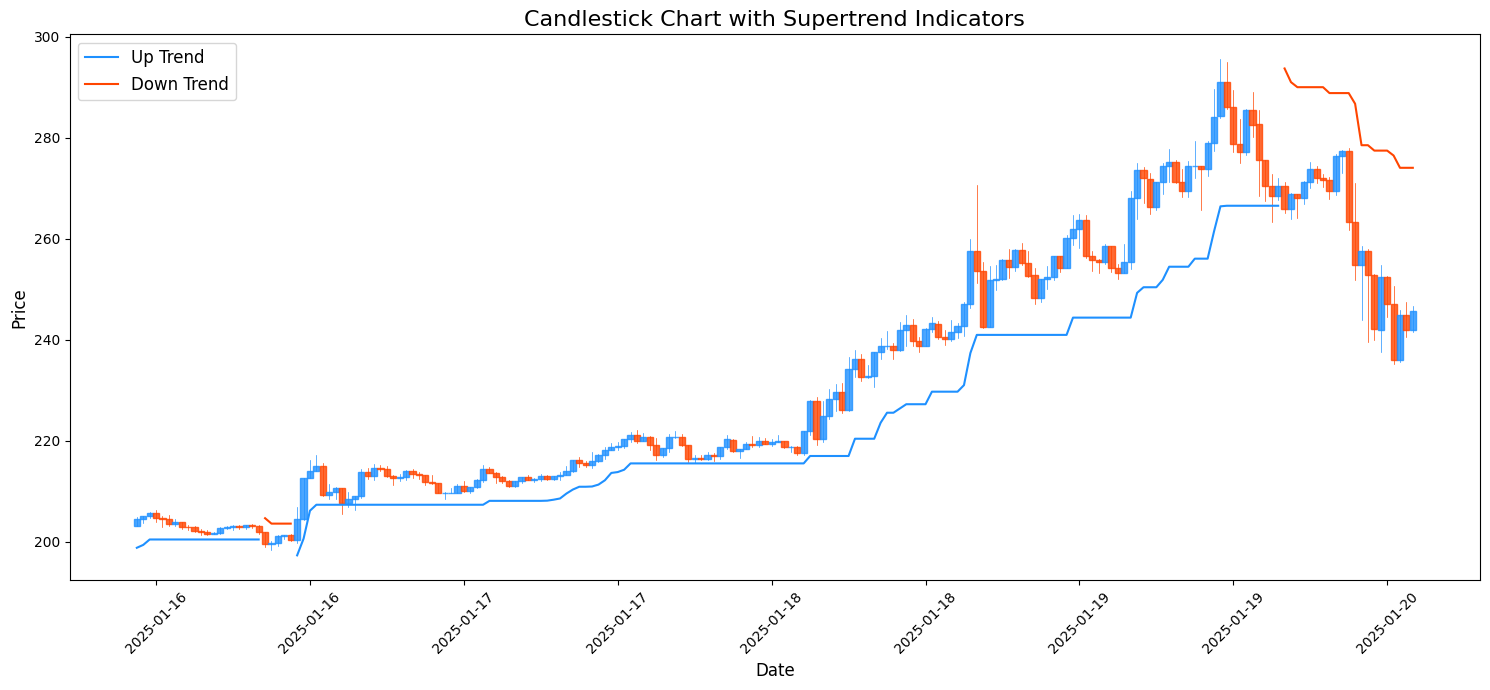

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mdates

supertrend_df_sample = supertrend_df.tail(200)
supertrend_df_sample

# Assuming `supertrend_df` is already loaded
# Convert 'opentime' to datetime and set up plotting data
supertrend_df_sample['opentime'] = pd.to_datetime(supertrend_df_sample['opentime'], unit='ms')
supertrend_df_sample['date_num'] = mdates.date2num(supertrend_df_sample['opentime'])

# Prepare OHLC data for candlestick plot
ohlc = supertrend_df_sample[['date_num', 'openprice', 'highprice', 'lowprice', 'closeprice']].dropna().values

# Plot configuration
fig, ax = plt.subplots(figsize=(15, 7))
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.title('Candlestick Chart with Supertrend Indicators', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)

# Plot candlestick chart
candlestick_ohlc(ax, ohlc, width=0.02, colorup='dodgerblue', colordown='orangered', alpha=0.8)

# Plot SUPERTl_10_3.0 (green) and SUPERTs_10_3.0 (red)
ax.plot(supertrend_df_sample['date_num'], supertrend_df_sample['SUPERTl_10_3.0'], color='dodgerblue', label='Up Trend')
ax.plot(supertrend_df_sample['date_num'], supertrend_df_sample['SUPERTs_10_3.0'], color='orangered', label='Down Trend')

# Add legend
plt.legend(loc='upper left', fontsize=12)
plt.tight_layout()
plt.show()

# Add Ichimoku Cloud Indicator

In [7]:
import pandas as pd
import numpy as np

def compute_ichimoku_with_supertrend(supertrend_df, conversion_periods=9, base_periods=26, span_b_periods=52, displacement=26):
    """
    Compute Ichimoku Cloud components and join them with the original supertrend DataFrame.
    
    Parameters:
    - supertrend_df (DataFrame): The input DataFrame with 'highprice', 'lowprice', and 'closeprice' columns.
    - conversion_periods (int): Period for the Conversion Line (Tenkan-sen). Default is 9.
    - base_periods (int): Period for the Base Line (Kijun-sen). Default is 26.
    - span_b_periods (int): Period for Leading Span B (Senkou Span B). Default is 52.
    - displacement (int): Displacement for Leading Spans. Default is 26.
    
    Returns:
    - DataFrame: A DataFrame that combines the original supertrend DataFrame with the computed Ichimoku Cloud components.
    """
    # Helper to calculate the average of the highest high and lowest low
    def donchian(data, period):
        return (data['highprice'].rolling(window=period).max() + 
                data['lowprice'].rolling(window=period).min()) / 2

    # Compute Ichimoku Cloud components
    supertrend_df['conversion_line'] = donchian(supertrend_df, conversion_periods)
    supertrend_df['base_line'] = donchian(supertrend_df, base_periods)
    supertrend_df['leading_span_a'] = ((supertrend_df['conversion_line'] + supertrend_df['base_line']) / 2).shift(displacement)
    supertrend_df['leading_span_b'] = donchian(supertrend_df, span_b_periods).shift(displacement)
    supertrend_df['lagging_span'] = supertrend_df['closeprice'].shift(-displacement)
    
    # Drop unnecessary columns
    supertrend_df.drop(columns=['conversion_line', 'base_line', 'lagging_span'], inplace=True)
    
    return supertrend_df

In [17]:
# Usage example:
supertrend_ichimoku_df = compute_ichimoku_with_supertrend(supertrend_df)
supertrend_ichimoku_df

,opentime,openprice,highprice,lowprice,closeprice,SUPERTl_10_3.0,SUPERTs_10_3.0,leading_span_a,leading_span_b
0,1600066800000,3.2002,4.9100,3.2002,3.3880,NaN,NaN,NaN,NaN
1,1600068600000,3.3878,3.4035,3.2983,3.3666,NaN,NaN,NaN,NaN
2,1600070400000,3.3663,3.4645,3.3078,3.4450,NaN,NaN,NaN,NaN
3,1600072200000,3.4498,3.5650,3.3000,3.3298,NaN,NaN,NaN,NaN
4,1600074000000,3.3298,3.3567,3.2161,3.2695,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
76257,1737329400000,242.0500,254.8900,237.6900,252.5200,NaN,277.483079,274.2625,262.930
76258,1737331200000,252.4900,252.6900,244.5200,247.0900,NaN,277.483079,277.2575,265.865
76259,1737333000000,247.0800,250.6500,235.3000,236.0400,NaN,276.512070,277.2575,266.610
76260,1737334800000,236.0500,245.9500,235.6710,244.9500,NaN,274.077563,277.2575,266.610


# Add MACD

In [9]:
import pandas as pd
import numpy as np

def compute_macd(supertrend_df, fast_period=12, slow_period=26, signal_period=9):
    """
    Compute MACD and Signal Line and join them with the original supertrend DataFrame.
    
    Parameters:
    - supertrend_df (DataFrame): The input DataFrame with 'highprice', 'lowprice', and 'closeprice' columns.
    - fast_period (int): Period for the fast EMA (12-period). Default is 12.
    - slow_period (int): Period for the slow EMA (26-period). Default is 26.
    - signal_period (int): Period for the Signal line (9-period). Default is 9.
    
    Returns:
    - DataFrame: A DataFrame that combines the original supertrend DataFrame with the computed MACD components.
    """
    # Compute MACD Line (fast EMA - slow EMA)
    supertrend_df['macd_line'] = supertrend_df['closeprice'].ewm(span=fast_period, adjust=False).mean() - supertrend_df['closeprice'].ewm(span=slow_period, adjust=False).mean()
    
    # Compute Signal Line (9-period EMA of the MACD line)
    supertrend_df['signal_line'] = supertrend_df['macd_line'].ewm(span=signal_period, adjust=False).mean()
    
    # Compute Histogram (MACD Line - Signal Line)
    supertrend_df['histogram'] = supertrend_df['macd_line'] - supertrend_df['signal_line']
    
    # Return the DataFrame with MACD, Signal, and Histogram columns
    return supertrend_df

In [18]:
# Usage example:
supertrend_ichimoku_macd_df = compute_macd(supertrend_ichimoku_df)
supertrend_ichimoku_macd_df

,opentime,openprice,highprice,lowprice,closeprice,SUPERTl_10_3.0,SUPERTs_10_3.0,leading_span_a,leading_span_b,macd_line,signal_line,histogram
0,1600066800000,3.2002,4.9100,3.2002,3.3880,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
1,1600068600000,3.3878,3.4035,3.2983,3.3666,NaN,NaN,NaN,NaN,-0.001707,-0.000341,-0.001366
2,1600070400000,3.3663,3.4645,3.3078,3.4450,NaN,NaN,NaN,NaN,0.003229,0.000373,0.002856
3,1600072200000,3.4498,3.5650,3.3000,3.3298,NaN,NaN,NaN,NaN,-0.002130,-0.000128,-0.002002
4,1600074000000,3.3298,3.3567,3.2161,3.2695,NaN,NaN,NaN,NaN,-0.011115,-0.002325,-0.008790
...,...,...,...,...,...,...,...,...,...,...,...,...
76257,1737329400000,242.0500,254.8900,237.6900,252.5200,NaN,277.483079,274.2625,262.930,-5.065927,-2.149523,-2.916404
76258,1737331200000,252.4900,252.6900,244.5200,247.0900,NaN,277.483079,277.2575,265.865,-5.735429,-2.866704,-2.868725
76259,1737333000000,247.0800,250.6500,235.3000,236.0400,NaN,276.512070,277.2575,266.610,-7.076088,-3.708581,-3.367507
76260,1737334800000,236.0500,245.9500,235.6710,244.9500,NaN,274.077563,277.2575,266.610,-7.335054,-4.433876,-2.901178


# Add EMA 200

In [13]:
def ema_indicator(df):
    """
    Adds a 200-period EMA column to the given DataFrame.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame with a 'closeprice' column.
    
    Returns:
    pd.DataFrame: DataFrame with an additional 'ema_200' column.
    """
    # Calculate the EMA for the 200-period window
    df['ema_200'] = df['closeprice'].ewm(span=200, adjust=False).mean()
    
    # Mask the first 199 rows
    df.loc[:199, 'ema_200'] = None
    
    return df

In [19]:
supertrend_ichimoku_macd_ema_df = ema_indicator(supertrend_ichimoku_macd_df)
supertrend_ichimoku_macd_ema_df

,opentime,openprice,highprice,lowprice,closeprice,SUPERTl_10_3.0,SUPERTs_10_3.0,leading_span_a,leading_span_b,macd_line,signal_line,histogram,ema_200
0,1600066800000,3.2002,4.9100,3.2002,3.3880,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN
1,1600068600000,3.3878,3.4035,3.2983,3.3666,NaN,NaN,NaN,NaN,-0.001707,-0.000341,-0.001366,NaN
2,1600070400000,3.3663,3.4645,3.3078,3.4450,NaN,NaN,NaN,NaN,0.003229,0.000373,0.002856,NaN
3,1600072200000,3.4498,3.5650,3.3000,3.3298,NaN,NaN,NaN,NaN,-0.002130,-0.000128,-0.002002,NaN
4,1600074000000,3.3298,3.3567,3.2161,3.2695,NaN,NaN,NaN,NaN,-0.011115,-0.002325,-0.008790,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
76257,1737329400000,242.0500,254.8900,237.6900,252.5200,NaN,277.483079,274.2625,262.930,-5.065927,-2.149523,-2.916404,237.786075
76258,1737331200000,252.4900,252.6900,244.5200,247.0900,NaN,277.483079,277.2575,265.865,-5.735429,-2.866704,-2.868725,237.878652
76259,1737333000000,247.0800,250.6500,235.3000,236.0400,NaN,276.512070,277.2575,266.610,-7.076088,-3.708581,-3.367507,237.860357
76260,1737334800000,236.0500,245.9500,235.6710,244.9500,NaN,274.077563,277.2575,266.610,-7.335054,-4.433876,-2.901178,237.930900


# Plot to check

/tmp/ipykernel_1875852/2777483409.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  supertrend_ichimoku_df_sample['opentime'] = pd.to_datetime(supertrend_ichimoku_df_sample['opentime'], unit='ms')
/tmp/ipykernel_1875852/2777483409.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  supertrend_ichimoku_df_sample['date_num'] = mdates.date2num(supertrend_ichimoku_df_sample['opentime'])


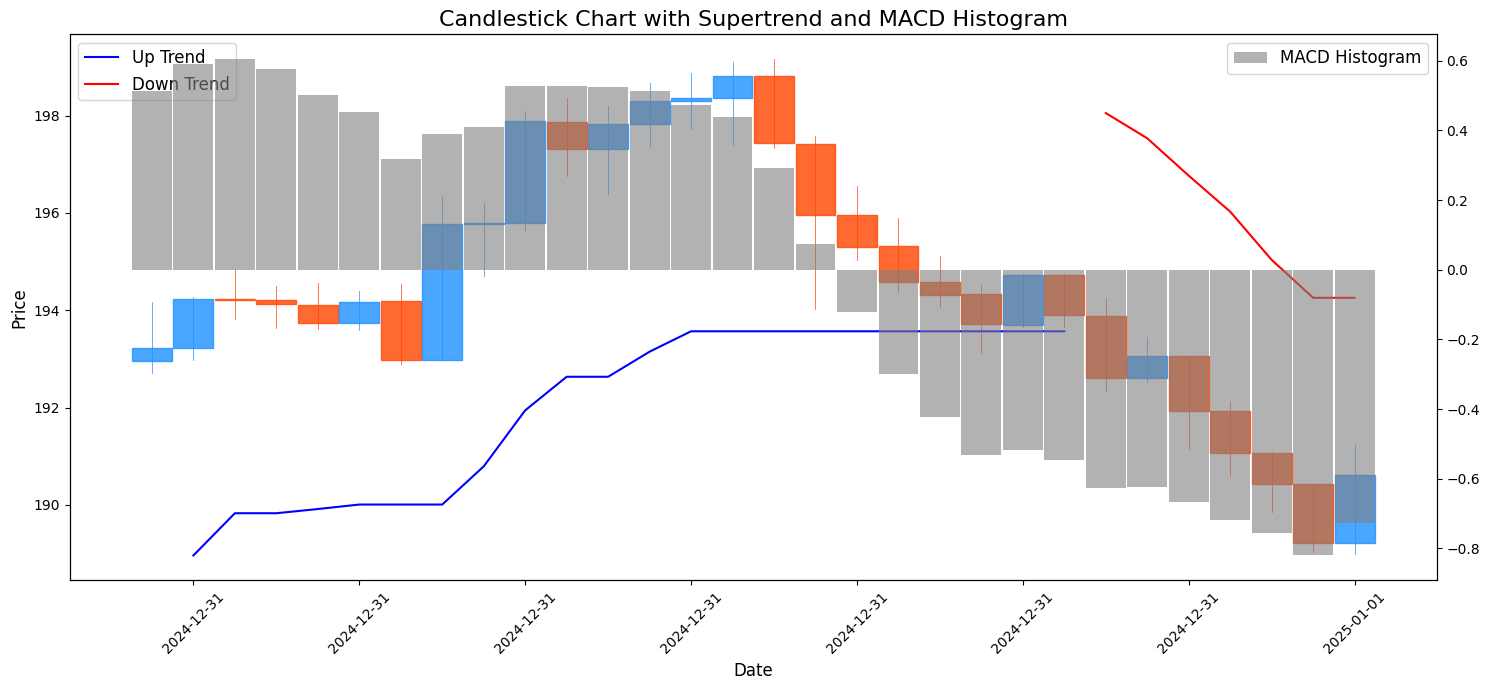

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mdates

# Assuming `supertrend_ichimoku_df_sample` is already loaded and processed
supertrend_ichimoku_df_sample = supertrend_ichimoku_df.tail(30)

# Convert 'opentime' to datetime and set up plotting data
supertrend_ichimoku_df_sample['opentime'] = pd.to_datetime(supertrend_ichimoku_df_sample['opentime'], unit='ms')
supertrend_ichimoku_df_sample['date_num'] = mdates.date2num(supertrend_ichimoku_df_sample['opentime'])

# Prepare OHLC data for candlestick plot
ohlc = supertrend_ichimoku_df_sample[['date_num', 'openprice', 'highprice', 'lowprice', 'closeprice']].dropna().values

# Plot configuration
fig, ax1 = plt.subplots(figsize=(15, 7))

# Plot candlestick chart
ax1.xaxis_date()
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
ax1.set_title('Candlestick Chart with Supertrend and MACD Histogram', fontsize=16)
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Price', fontsize=12)

# Candlestick chart
candlestick_ohlc(ax1, ohlc, width=0.02, colorup='dodgerblue', colordown='orangered', alpha=0.8)

# Plot Supertrend Uptrend and Downtrend
ax1.plot(supertrend_ichimoku_df_sample['date_num'], supertrend_ichimoku_df_sample['SUPERTl_10_3.0'], color='blue', label='Up Trend')
ax1.plot(supertrend_ichimoku_df_sample['date_num'], supertrend_ichimoku_df_sample['SUPERTs_10_3.0'], color='red', label='Down Trend')

# Add legend for Supertrend
ax1.legend(loc='upper left', fontsize=12)

# Create a second y-axis to plot the MACD histogram
ax2 = ax1.twinx()

# Plot the MACD histogram
ax2.bar(supertrend_ichimoku_df_sample['date_num'], supertrend_ichimoku_df_sample['histogram'], width=0.02, color='gray', alpha=0.6, label='MACD Histogram')

# Add legend for MACD
ax2.legend(loc='upper right', fontsize=12)

# Tight layout to prevent clipping
plt.tight_layout()

# Show the plot
plt.show()

# Backtest Signaling

In [19]:
import numpy as np

def process_dataframe(df_backtest):
    
    # Fill the 'trend' column based on conditions
    df_backtest['trend'] = np.where(
        (df_backtest['SUPERTl_10_3.0'].notna()) & (df_backtest['SUPERTs_10_3.0'].isna()), 1,
        np.where(
            (df_backtest['SUPERTs_10_3.0'].notna()) & (df_backtest['SUPERTl_10_3.0'].isna()), -1, np.nan
        )
    )
    
    # Rename columns
    new_column_names = {
        'opentime': 'time',
        'openprice': 'open',
        'highprice': 'high',
        'lowprice': 'low',
        'closeprice': 'close',
        'leading_span_a': 'ic_a',
        'leading_span_b': 'ic_b',
        'histogram': 'macd'
    }
    df_backtest.rename(columns=new_column_names, inplace=True)
    
    # Drop unused columns
    df_backtest.drop(columns=['SUPERTl_10_3.0', 'SUPERTs_10_3.0', 'macd_line', 'signal_line'], inplace=True)
    
    # Drop first 77 rows
    df_backtest.drop(index=range(77), inplace=True)
    
    # Reset index
    df_backtest.reset_index(drop=True, inplace=True)
    
    # Return the processed DataFrame
    return df_backtest

In [40]:
df_backtest = process_dataframe(supertrend_ichimoku_macd_df)
df_backtest

,time,open,high,low,close,ic_a,ic_b,macd,trend
0,1600205400000,3.0175,3.0385,3.0129,3.0234,3.217025,4.0175,-0.003167,-1.0
1,1600207200000,3.0233,3.0376,3.0102,3.0274,3.211700,3.3450,-0.001792,-1.0
2,1600209000000,3.0273,3.0332,2.9523,2.9815,3.210450,3.3450,-0.003331,-1.0
3,1600210800000,2.9808,2.9935,2.9421,2.9475,3.208375,3.3450,-0.005848,-1.0
4,1600212600000,2.9450,2.9483,2.9001,2.9332,3.207125,3.3075,-0.007576,-1.0
...,...,...,...,...,...,...,...,...,...
76181,1737331200000,252.4900,252.6900,244.5200,247.0900,277.257500,265.8650,-2.868725,-1.0
76182,1737333000000,247.0800,250.6500,235.3000,236.0400,277.257500,266.6100,-3.367507,-1.0
76183,1737334800000,236.0500,245.9500,235.6710,244.9500,277.257500,266.6100,-2.901178,-1.0
76184,1737336600000,244.9500,247.4300,240.6000,241.9300,277.257500,266.6100,-2.609114,-1.0


# Date Filter

In [31]:
# # After _ _ _
# df_backtest = df_backtest[df_backtest['time'] >= 1609459200000 ] # January 1, 2021 12:00:00 AM
# df_backtest = df_backtest[df_backtest['time'] >= 1640995200000 ] # January 1, 2022 12:00:00 AM
# df_backtest = df_backtest[df_backtest['time'] >= 1672531200000 ] # January 1, 2023 12:00:00 AM
# df_backtest = df_backtest[df_backtest['time'] >= 1704067200000 ] # January 1, 2024 12:00:00 AM
# df_backtest = df_backtest[df_backtest['time'] >= 1719792000000 ] # July 1, 2024 12:00:00 AM
# df_backtest = df_backtest[df_backtest['time'] >= 1727740800000 ] # October 1, 2024 12:00:00 AM
# df_backtest = df_backtest[df_backtest['time'] >= 1730419200000 ] # November 1, 2024 12:00:00 AM
# df_backtest = df_backtest[df_backtest['time'] >= 1733011200000 ] # December 1, 2024 12:00:00 AM
# df_backtest = df_backtest[df_backtest['time'] >= 1735689600000 ] # January 1, 2025 12:00:00 AM

# # Before _ _ _
# df_backtest = df_backtest[df_backtest['time'] < 1640995200000 ] # January 1, 2022 12:00:00 AM
# df_backtest = df_backtest[df_backtest['time'] < 1672531200000 ] # January 1, 2023 12:00:00 AM
# df_backtest = df_backtest[df_backtest['time'] < 1704067200000 ] # January 1, 2024 12:00:00 AM
# df_backtest = df_backtest[df_backtest['time'] < 1735689600000 ] # January 1, 2025 12:00:00 AM
# df_backtest = df_backtest[df_backtest['time'] < 1736899200000 ] # January 15, 2025 12:00:00 AM

def date_filtered_df(df,start,end):

    # Filter by timestamp
    df = df[df['time'] >= start]
    df = df[df['time'] < end]

    # Reset the index of the filtered DataFrame
    df.reset_index(drop=True, inplace=True)

    return df

In [41]:
df_backtest_filtered = date_filtered_df(df_backtest,1609459200000,1735689600000)
df_backtest_filtered

,time,open,high,low,close,ic_a,ic_b,macd,trend
0,1609459200000,1.5043,1.5134,1.4890,1.4921,1.51090,1.54575,-0.001474,1.0
1,1609461000000,1.4916,1.5392,1.4908,1.5380,1.50340,1.54280,0.000732,1.0
2,1609462800000,1.5379,1.5965,1.5277,1.5906,1.50325,1.54240,0.005398,1.0
3,1609464600000,1.5900,1.6000,1.5625,1.5695,1.49260,1.52740,0.006644,1.0
4,1609466400000,1.5696,1.5776,1.5670,1.5751,1.47445,1.50925,0.007372,1.0
...,...,...,...,...,...,...,...,...,...
70123,1735680600000,192.6000,193.4400,192.5200,193.0500,191.47500,191.10500,-0.623133,-1.0
70124,1735682400000,193.0500,193.0500,191.1400,191.9200,191.31250,191.10500,-0.666920,-1.0
70125,1735684200000,191.9300,192.1300,190.5900,191.0700,191.26000,191.10500,-0.718448,-1.0
70126,1735686000000,191.0700,191.0800,189.8600,190.4300,191.14000,191.10500,-0.757087,-1.0


In [42]:
# Check for NaN values in any column
nan_check = df_backtest.isna().sum()

# Print out columns with NaN values
print("Columns with NaN values:")
print(nan_check[nan_check > 0])

Columns with NaN values:
Series([], dtype: int64)


# ST IC MACD

In [148]:
def determine_real_action(df, macd_threshold=0.00000001):
    """
    Determines the trading action ('Open Long', 'Close Long', 'Hold Long', etc.)
    based on the trend, MACD, and other criteria.

    Parameters:
    - df (DataFrame): The DataFrame containing the necessary columns.
    - macd_threshold (float): The threshold for MACD to determine actions.

    Returns:
    - DataFrame: The updated DataFrame with 'Real_Action' and 'opoct' columns.
    """
    # Initialize previous action and position tracker
    prev_action = None
    df['Real_Action'] = None
    opoct = 0 #opened_position_on_current_trend
    df['opoct'] = 0  # Initialize opoct to 0
    
    # Iterate over rows starting from the second row
    for index in range(1, len(df)):
        # Access the current and previous rows
        row = df.iloc[index]
        prev_row = df.iloc[index - 1]

        # Check if the trend has changed
        if prev_row['trend'] != row['trend']:
            opoct = 0  # Reset opoct when trend changes
            df['opoct'] = opoct

            # Handle actions when the trend changes
            if prev_action == 'Long':
                if row['trend'] == -1 and row['macd'] <= -macd_threshold and row['close'] <= min(row['ic_a'], row['ic_b']):
                    df.at[index, 'Real_Action'] = 'Close Long and Open Short'
                    prev_action = 'Short'
                    opoct += 1
                    df['opoct'] = opoct  
                else:
                    df.at[index, 'Real_Action'] = 'Close Long'
                    prev_action = None

            elif prev_action == 'Short':
                if row['trend'] == 1 and row['macd'] >= macd_threshold and row['close'] >= max(row['ic_a'], row['ic_b']):
                    df.at[index, 'Real_Action'] = 'Close Short and Open Long'
                    prev_action = 'Long'
                    opoct += 1
                    df['opoct'] = opoct
                else:
                    df.at[index, 'Real_Action'] = 'Close Short'
                    prev_action = None

            elif prev_action is None:
                if row['trend'] == 1 and row['macd'] >= macd_threshold and row['close'] >= max(row['ic_a'], row['ic_b']):
                    df.at[index, 'Real_Action'] = 'Open Long'
                    prev_action = 'Long'
                    opoct += 1
                    df['opoct'] = opoct
                elif row['trend'] == -1 and row['macd'] <= -macd_threshold and row['close'] <= min(row['ic_a'], row['ic_b']):
                    df.at[index, 'Real_Action'] = 'Open Short'
                    prev_action = 'Short'
                    opoct += 1
                    df['opoct'] = opoct
                else :
                    df.at[index, 'Real_Action'] = None
                    prev_action = None

        elif prev_row['opoct'] == 0:
            if row['trend'] == 1 and row['macd'] >= macd_threshold and row['close'] >= max(row['ic_a'], row['ic_b']):
                df.at[index, 'Real_Action'] = 'Open Long'
                prev_action = 'Long'
                opoct += 1
                df['opoct'] = opoct
            elif row['trend'] == -1 and row['macd'] <= -macd_threshold and row['close'] <= min(row['ic_a'], row['ic_b']):
                df.at[index, 'Real_Action'] = 'Open Short'
                prev_action = 'Short'
                opoct += 1
                df['opoct'] = opoct

        # Handle actions within the same trend
        elif prev_row['opoct'] > 0:
            if prev_action == 'Long':
                if row['trend'] == 1 and row['macd'] >= macd_threshold:
                    df.at[index, 'Real_Action'] = 'Hold Long'
                    prev_action = 'Long'
                elif row['trend'] == 1 and row['macd'] <= -macd_threshold:
                    df.at[index, 'Real_Action'] = 'Close Long'
                    prev_action = None

            elif prev_action == 'Short':
                if row['trend'] == -1 and row['macd'] <= -macd_threshold:
                    df.at[index, 'Real_Action'] = 'Hold Short'
                    prev_action = 'Short'
                elif row['trend'] == -1 and row['macd'] >= macd_threshold:
                    df.at[index, 'Real_Action'] = 'Close Short'
                    prev_action = None

            elif prev_action is None:
                if row['trend'] == 1 and row['macd'] >= macd_threshold:
                    df.at[index, 'Real_Action'] = 'Open Long'
                    prev_action = 'Long'
                    opoct += 1
                    df['opoct'] = opoct
                elif row['trend'] == -1 and row['macd'] <= -macd_threshold:
                    df.at[index, 'Real_Action'] = 'Open Short'
                    prev_action = 'Short'
                    opoct += 1
                    df['opoct'] = opoct
                elif row['trend'] == 1 and row['macd'] <= -macd_threshold:
                    df.at[index, 'Real_Action'] = None
                    prev_action = None
                elif row['trend'] == -1 and row['macd'] >= macd_threshold:
                    df.at[index, 'Real_Action'] = None
                    prev_action = None

     # Get the last row Real_Action
    last_row_action = df.iloc[-1]

    # Check the value in 'Real_Action' and update accordingly
    if last_row_action['Real_Action'] == 'Hold Long':
        df.at[df.index[-1], 'Real_Action'] = 'Close Long'
    elif last_row_action['Real_Action'] == 'Hold Short':
        df.at[df.index[-1], 'Real_Action'] = 'Close Short'
    else:
        df.at[df.index[-1], 'Real_Action'] = None

    return df

# ST IC

In [270]:
def determine_real_action_basic(df, position = 2):
    """
    Determines the trading action ('Open Long', 'Close Long', 'Hold Long', etc.)
    based on the trend, MACD, and other criteria.

    Parameters:
    - df (DataFrame): The DataFrame containing the necessary columns.
    - macd_threshold (float): The threshold for MACD to determine actions.

    Returns:
    - DataFrame: The updated DataFrame with 'Real_Action' and 'opoct' columns.
    """
    # Initialize previous action and position tracker
    prev_action = None
    df['Real_Action'] = None
    
    # Iterate over rows starting from the second row
    for index in range(1, len(df)):
        # Access the current and previous rows
        row = df.iloc[index]
        prev_row = df.iloc[index - 1]

        # Check if the trend has changed
        if prev_row['trend'] != row['trend']:
            # Handle actions when the trend changes
            if position == 2 : # long and short
                if prev_action == 'Long':
                    if row['trend'] == -1 and row['close'] <= min(row['ic_a'], row['ic_b']):
                        df.at[index, 'Real_Action'] = 'Close Long and Open Short'
                        prev_action = 'Short' 
                    else:
                        df.at[index, 'Real_Action'] = 'Close Long'
                        prev_action = None

                elif prev_action == 'Short':
                    if row['trend'] == 1 and row['close'] >= max(row['ic_a'], row['ic_b']):
                        df.at[index, 'Real_Action'] = 'Close Short and Open Long'
                        prev_action = 'Long'
                    else:
                        df.at[index, 'Real_Action'] = 'Close Short'
                        prev_action = None

                elif prev_action is None:
                    if row['trend'] == 1 and row['close'] >= max(row['ic_a'], row['ic_b']):
                        df.at[index, 'Real_Action'] = 'Open Long'
                        prev_action = 'Long'
                    elif row['trend'] == -1 and row['close'] <= min(row['ic_a'], row['ic_b']):
                        df.at[index, 'Real_Action'] = 'Open Short'
                        prev_action = 'Short'
                    else :
                        df.at[index, 'Real_Action'] = None
                        prev_action = None

            elif position == 1 : #long only
                # Handle actions when the trend changes
                if prev_action == 'Long':
                    if row['trend'] == -1 :
                        df.at[index, 'Real_Action'] = 'Close Long'
                        prev_action = None

                elif prev_action is None:
                    if row['trend'] == 1 and row['close'] >= max(row['ic_a'], row['ic_b']):
                        df.at[index, 'Real_Action'] = 'Open Long'
                        prev_action = 'Long'
                    else :
                        df.at[index, 'Real_Action'] = None
                        prev_action = None

            elif position == -1 : #short only
                # Handle actions when the trend changes
                if prev_action == 'Short':
                    if row['trend'] == 1 :
                        df.at[index, 'Real_Action'] = 'Close Short'
                        prev_action = None

                elif prev_action is None:
                    if row['trend'] == -1 and row['close'] <= min(row['ic_a'], row['ic_b']):
                        df.at[index, 'Real_Action'] = 'Open Short'
                        prev_action = 'Short'
                    else :
                        df.at[index, 'Real_Action'] = None
                        prev_action = None

        # Handle actions within the same trend
        elif prev_row['trend'] == row['trend']:
            if prev_action == 'Long':
                df.at[index, 'Real_Action'] = 'Hold Long'
                prev_action = 'Long'
            elif prev_action == 'Short':
                df.at[index, 'Real_Action'] = 'Hold Short'
                prev_action = 'Short'
            elif prev_action is None:
                if row['trend'] == 1 and row['close'] >= max(row['ic_a'], row['ic_b']):
                    df.at[index, 'Real_Action'] = 'Open Long'
                    prev_action = 'Long'
                elif row['trend'] == -1 and row['close'] <= min(row['ic_a'], row['ic_b']):
                    df.at[index, 'Real_Action'] = 'Open Short'
                    prev_action = 'Short'
                else :
                    df.at[index, 'Real_Action'] = None
                    prev_action = None

     # Get the last row Real_Action
    last_row_action = df.iloc[-1]

    # Check the value in 'Real_Action' and update accordingly
    if last_row_action['Real_Action'] == 'Hold Long':
        df.at[df.index[-1], 'Real_Action'] = 'Close Long'
    elif last_row_action['Real_Action'] == 'Hold Short':
        df.at[df.index[-1], 'Real_Action'] = 'Close Short'
    else:
        df.at[df.index[-1], 'Real_Action'] = None

    return df

# ST IC MACD EX

In [150]:
def determine_real_action_ex(df, macd_threshold=0.00000001):
    """
    Determines the trading action ('Open Long', 'Close Long', 'Hold Long', etc.)
    based on the trend, MACD, and other criteria.

    Parameters:
    - df (DataFrame): The DataFrame containing the necessary columns.
    - macd_threshold (float): The threshold for MACD to determine actions.

    Returns:
    - DataFrame: The updated DataFrame with 'Real_Action' and 'opoct' columns.
    """
    # Initialize previous action and position tracker
    prev_action = None
    df['Real_Action'] = None
    opoct = 0 #opened_position_on_current_trend
    df['opoct'] = 0  # Initialize opoct to 0
    
    # Iterate over rows starting from the second row
    for index in range(1, len(df)):
        # Access the current and previous rows
        row = df.iloc[index]
        prev_row = df.iloc[index - 1]

        # Check if the trend has changed
        if prev_row['trend'] != row['trend']:
            opoct = 0  # Reset opoct when trend changes
            df['opoct'] = opoct

            # Handle actions when the trend changes
            if prev_action == 'Long':
                if row['trend'] == -1 and row['macd'] <= -macd_threshold and row['close'] <= min(row['ic_a'], row['ic_b']):
                    df.at[index, 'Real_Action'] = 'Close Long and Open Short'
                    prev_action = 'Short'
                    opoct += 1
                    df['opoct'] = opoct  
                else:
                    df.at[index, 'Real_Action'] = 'Close Long'
                    prev_action = None

            elif prev_action == 'Short':
                if row['trend'] == 1 and row['macd'] >= macd_threshold and row['close'] >= max(row['ic_a'], row['ic_b']):
                    df.at[index, 'Real_Action'] = 'Close Short and Open Long'
                    prev_action = 'Long'
                    opoct += 1
                    df['opoct'] = opoct
                else:
                    df.at[index, 'Real_Action'] = 'Close Short'
                    prev_action = None

            elif prev_action is None:
                if row['trend'] == 1 and row['macd'] >= macd_threshold and row['close'] >= max(row['ic_a'], row['ic_b']):
                    df.at[index, 'Real_Action'] = 'Open Long'
                    prev_action = 'Long'
                    opoct += 1
                    df['opoct'] = opoct
                elif row['trend'] == -1 and row['macd'] <= -macd_threshold and row['close'] <= min(row['ic_a'], row['ic_b']):
                    df.at[index, 'Real_Action'] = 'Open Short'
                    prev_action = 'Short'
                    opoct += 1
                    df['opoct'] = opoct
                else :
                    df.at[index, 'Real_Action'] = None
                    prev_action = None

        elif prev_row['opoct'] == 0:
            if row['trend'] == 1 and row['macd'] >= macd_threshold and row['close'] >= max(row['ic_a'], row['ic_b']):
                df.at[index, 'Real_Action'] = 'Open Long'
                prev_action = 'Long'
                opoct += 1
                df['opoct'] = opoct
            elif row['trend'] == -1 and row['macd'] <= -macd_threshold and row['close'] <= min(row['ic_a'], row['ic_b']):
                df.at[index, 'Real_Action'] = 'Open Short'
                prev_action = 'Short'
                opoct += 1
                df['opoct'] = opoct

        # Handle actions within the same trend
        elif prev_row['opoct'] > 0:
            if prev_action == 'Long':
                if row['trend'] == 1 and row['macd'] >= macd_threshold and row['close'] >= max(row['ic_a'], row['ic_b']):
                    df.at[index, 'Real_Action'] = 'Hold Long'
                    prev_action = 'Long'
                else:
                    df.at[index, 'Real_Action'] = 'Close Long'
                    prev_action = None

            elif prev_action == 'Short':
                if row['trend'] == -1 and row['macd'] <= -macd_threshold and row['close'] <= min(row['ic_a'], row['ic_b']):
                    df.at[index, 'Real_Action'] = 'Hold Short'
                    prev_action = 'Short'
                else:
                    df.at[index, 'Real_Action'] = 'Close Short'
                    prev_action = None

            elif prev_action is None:
                if row['trend'] == 1 and row['macd'] >= macd_threshold and row['close'] >= max(row['ic_a'], row['ic_b']):
                    df.at[index, 'Real_Action'] = 'Open Long'
                    prev_action = 'Long'
                    opoct += 1
                    df['opoct'] = opoct
                elif row['trend'] == -1 and row['macd'] <= -macd_threshold and row['close'] <= min(row['ic_a'], row['ic_b']):
                    df.at[index, 'Real_Action'] = 'Open Short'
                    prev_action = 'Short'
                    opoct += 1
                    df['opoct'] = opoct
                else:
                    df.at[index, 'Real_Action'] = None
                    prev_action = None

     # Get the last row Real_Action
    last_row_action = df.iloc[-1]

    # Check the value in 'Real_Action' and update accordingly
    if last_row_action['Real_Action'] == 'Hold Long':
        df.at[df.index[-1], 'Real_Action'] = 'Close Long'
    elif last_row_action['Real_Action'] == 'Hold Short':
        df.at[df.index[-1], 'Real_Action'] = 'Close Short'
    else:
        df.at[df.index[-1], 'Real_Action'] = None

    return df

# ST EMA

In [20]:
def determine_real_action_st_ema (df, position = 2):

    # Initialize previous action and position tracker
    prev_action = None
    df['Real_Action'] = None
    
    # Iterate over rows starting from the second row
    for index in range(1, len(df)):
        # Access the current and previous rows
        row = df.iloc[index]
        prev_row = df.iloc[index - 1]

        # Check if the trend has changed
        if prev_row['trend'] != row['trend']:
            # Handle actions when the trend changes
            if position == 2 : # long and short
                if prev_action == 'Long':
                    if row['trend'] == -1 and row['close'] <= row['ema_200']:
                        df.at[index, 'Real_Action'] = 'Close Long and Open Short'
                        prev_action = 'Short' 
                    elif row['trend'] == -1:
                        df.at[index, 'Real_Action'] = 'Close Long'
                        prev_action = None
                elif prev_action == 'Short':
                    if row['trend'] == 1 and row['close'] >= row['ema_200']:
                        df.at[index, 'Real_Action'] = 'Close Short and Open Long'
                        prev_action = 'Long'
                    elif row['trend'] == 1:
                        df.at[index, 'Real_Action'] = 'Close Short'
                        prev_action = None
                elif prev_action is None:
                    if row['trend'] == 1 and row['close'] >= row['ema_200']:
                        df.at[index, 'Real_Action'] = 'Open Long'
                        prev_action = 'Long'
                    elif row['trend'] == -1 and row['close'] <= row['ema_200']:
                        df.at[index, 'Real_Action'] = 'Open Short'
                        prev_action = 'Short'
                    else :
                        df.at[index, 'Real_Action'] = None
                        prev_action = None

            elif position == 1 : #long only
                if prev_action == 'Long':
                    if row['trend'] == -1 :
                        df.at[index, 'Real_Action'] = 'Close Long'
                        prev_action = None
                elif prev_action is None:
                    if row['trend'] == 1 and row['close'] >= row['ema_200']:
                        df.at[index, 'Real_Action'] = 'Open Long'
                        prev_action = 'Long'
                    else :
                        df.at[index, 'Real_Action'] = None
                        prev_action = None

            elif position == -1 : #short only
                if prev_action == 'Short':
                    if row['trend'] == 1 :
                        df.at[index, 'Real_Action'] = 'Close Short'
                        prev_action = None
                elif prev_action is None:
                    if row['trend'] == -1 and row['close'] <= row['ema_200']:
                        df.at[index, 'Real_Action'] = 'Open Short'
                        prev_action = 'Short'
                    else :
                        df.at[index, 'Real_Action'] = None
                        prev_action = None

        # Handle actions within the same trend
        elif prev_row['trend'] == row['trend']:
            if prev_action == 'Long':
                df.at[index, 'Real_Action'] = 'Hold Long'
                prev_action = 'Long'
            elif prev_action == 'Short':
                df.at[index, 'Real_Action'] = 'Hold Short'
                prev_action = 'Short'
            elif prev_action is None:
                if row['trend'] == 1 and row['close'] >= row['ema_200']:
                    df.at[index, 'Real_Action'] = 'Open Long'
                    prev_action = 'Long'
                elif row['trend'] == -1 and row['close'] <= row['ema_200']:
                    df.at[index, 'Real_Action'] = 'Open Short'
                    prev_action = 'Short'
                else :
                    df.at[index, 'Real_Action'] = None
                    prev_action = None

     # Get the last row Real_Action
    last_row_action = df.iloc[-1]

    # Check the value in 'Real_Action' and update accordingly
    if last_row_action['Real_Action'] == 'Hold Long':
        df.at[df.index[-1], 'Real_Action'] = 'Close Long'
    elif last_row_action['Real_Action'] == 'Hold Short':
        df.at[df.index[-1], 'Real_Action'] = 'Close Short'
    else:
        df.at[df.index[-1], 'Real_Action'] = None

    return df

# Continue

In [236]:
# df_backtest = df_backtest[df_backtest['time'] >= 1737021600000]

# Reset the index of the filtered DataFrame
df_backtest.reset_index(drop=True, inplace=True)

# df_backtest = df_backtest.head(5)

df_backtest

,time,open,high,low,close,ic_a,ic_b,macd,trend
0,1730557800000,163.89,164.16,162.51,163.41,167.1300,168.495,-0.296816,-1.0
1,1730559600000,163.40,163.66,162.10,163.48,167.5475,168.495,-0.302604,-1.0
2,1730561400000,163.48,163.87,162.90,163.73,167.5800,168.495,-0.270149,-1.0
3,1730563200000,163.74,164.29,163.50,164.12,167.6950,168.495,-0.205875,-1.0
4,1730565000000,164.13,165.35,164.08,164.71,167.2850,168.495,-0.111794,-1.0
...,...,...,...,...,...,...,...,...,...
3691,1737201600000,238.85,242.40,238.80,242.10,218.7100,215.245,0.358482,1.0
3692,1737203400000,242.11,244.45,241.63,243.24,218.7100,215.245,0.326469,1.0
3693,1737205200000,243.23,243.77,240.16,240.65,218.7800,215.245,0.078218,1.0
3694,1737207000000,240.66,241.87,239.06,240.17,218.8525,215.850,-0.158075,1.0


In [71]:
# Call the function with the DataFrame to calculate the 'Real_Action' column
# df_backtest_recap = determine_real_action(df_backtest_filtered) # ST IC MACD
# df_backtest_recap = determine_real_action_basic(df_backtest_filtered) # ST IC
df_backtest_recap = determine_real_action_ex(df_backtest_filtered) # ST IC MACD EX

# Get the last row Real_Action
last_row_action = df_backtest_recap.iloc[-1]

# Check the value in 'Real_Action' and update accordingly
if last_row_action['Real_Action'] == 'Hold Long':
    df_backtest_recap.at[df_backtest_recap.index[-1], 'Real_Action'] = 'Close Long'
elif last_row_action['Real_Action'] == 'Hold Short':
    df_backtest_recap.at[df_backtest_recap.index[-1], 'Real_Action'] = 'Close Short'
else:
    df_backtest_recap.at[df_backtest_recap.index[-1], 'Real_Action'] = None

df_backtest_recap

,time,open,high,low,close,ic_a,ic_b,macd,trend,Real_Action,opoct
0,1609459200000,1.5043,1.5134,1.4890,1.4921,1.51090,1.54575,-0.001474,1.0,None,1
1,1609461000000,1.4916,1.5392,1.4908,1.5380,1.50340,1.54280,0.000732,1.0,None,1
2,1609462800000,1.5379,1.5965,1.5277,1.5906,1.50325,1.54240,0.005398,1.0,Open Long,1
3,1609464600000,1.5900,1.6000,1.5625,1.5695,1.49260,1.52740,0.006644,1.0,Hold Long,1
4,1609466400000,1.5696,1.5776,1.5670,1.5751,1.47445,1.50925,0.007372,1.0,Hold Long,1
...,...,...,...,...,...,...,...,...,...,...,...
70123,1735680600000,192.6000,193.4400,192.5200,193.0500,191.47500,191.10500,-0.623133,-1.0,None,1
70124,1735682400000,193.0500,193.0500,191.1400,191.9200,191.31250,191.10500,-0.666920,-1.0,None,1
70125,1735684200000,191.9300,192.1300,190.5900,191.0700,191.26000,191.10500,-0.718448,-1.0,Open Short,1
70126,1735686000000,191.0700,191.0800,189.8600,190.4300,191.14000,191.10500,-0.757087,-1.0,Hold Short,1


In [72]:
# Count the number of NaN values in each column
nan_count = df_backtest_recap.isna().sum()

# Print out the number of NaN values in each column
print("NaN values in each column:")
print(nan_count)

NaN values in each column:
time               0
open               0
high               0
low                0
close              0
ic_a               0
ic_b               0
macd               0
trend              0
Real_Action    37352
opoct              0
dtype: int64


In [73]:
df_backtest_recap['Real_Action'].unique()

array([None, 'Open Long', 'Hold Long', 'Close Long', 'Open Short',
       'Hold Short', 'Close Short', 'Close Long and Open Short',
       'Close Short and Open Long'], dtype=object)

In [74]:
# Count rows where 'Open' appears in the 'Real_Action' column
open_count = df_backtest_recap[df_backtest_recap['Real_Action'].str.contains('Open', case=False, na=False)].shape[0]

open_count

3607

In [75]:
# Count rows where 'Open' appears in the 'Real_Action' column
close_count = df_backtest_recap[df_backtest_recap['Real_Action'].str.contains('Close', case=False, na=False)].shape[0]

close_count

3607

In [76]:
import pandas as pd

def separate_open_close(df):
    # List to hold rows for final DataFrame
    new_rows = []
    
    for i, row in df.iterrows():
        action = row['Real_Action']
        
        # Check for combined 'Close' and 'Open' actions
        if isinstance(action, str) and 'and' in action:
            # Split the combined action into two separate actions
            actions = action.split('and')
            
            # Create the first row with the first action (Close)
            close_row = row.copy()
            close_row['Real_Action'] = actions[0].strip()  # "Close Long"
            new_rows.append(close_row)
            
            # Create the second row with the second action (Open)
            open_row = row.copy()
            open_row['Real_Action'] = actions[1].strip()  # "Open Short"
            new_rows.append(open_row)
        else:
            # If no combined action, just append the row
            new_rows.append(row)
    
    # Create a new DataFrame from the new_rows list
    df_separated = pd.DataFrame(new_rows)
    
    return df_separated

# Assuming df_backtest_recap is the original DataFrame
df_backtest_recap_separated = separate_open_close(df_backtest_recap)

# Display the resulting DataFrame
df_backtest_recap_separated

,time,open,high,low,close,ic_a,ic_b,macd,trend,Real_Action,opoct
0,1609459200000,1.5043,1.5134,1.4890,1.4921,1.51090,1.54575,-0.001474,1.0,None,1
1,1609461000000,1.4916,1.5392,1.4908,1.5380,1.50340,1.54280,0.000732,1.0,None,1
2,1609462800000,1.5379,1.5965,1.5277,1.5906,1.50325,1.54240,0.005398,1.0,Open Long,1
3,1609464600000,1.5900,1.6000,1.5625,1.5695,1.49260,1.52740,0.006644,1.0,Hold Long,1
4,1609466400000,1.5696,1.5776,1.5670,1.5751,1.47445,1.50925,0.007372,1.0,Hold Long,1
...,...,...,...,...,...,...,...,...,...,...,...
70123,1735680600000,192.6000,193.4400,192.5200,193.0500,191.47500,191.10500,-0.623133,-1.0,None,1
70124,1735682400000,193.0500,193.0500,191.1400,191.9200,191.31250,191.10500,-0.666920,-1.0,None,1
70125,1735684200000,191.9300,192.1300,190.5900,191.0700,191.26000,191.10500,-0.718448,-1.0,Open Short,1
70126,1735686000000,191.0700,191.0800,189.8600,190.4300,191.14000,191.10500,-0.757087,-1.0,Hold Short,1


In [77]:
# Check for NaN values in any column
nan_check = df_backtest_recap_separated.isna().sum()

# Print out columns with NaN values
print("Columns with NaN values:")
print(nan_check[nan_check > 0])

Columns with NaN values:
Real_Action    37352
dtype: int64


In [78]:
# Count rows where 'Open' appears in the 'Real_Action' column
open_count = df_backtest_recap_separated[df_backtest_recap_separated['Real_Action'].str.contains('Open', case=False, na=False)].shape[0]

open_count

3607

In [79]:
# Count rows where 'Open' appears in the 'Real_Action' column
close_count = df_backtest_recap_separated[df_backtest_recap_separated['Real_Action'].str.contains('Close', case=False, na=False)].shape[0]

close_count

3607

In [64]:
import pandas as pd

def get_positions(df, position = None):
    # Count the number of NaN values in the entire DataFrame
    nan_count = df.isna().sum().sum()
    
    positions = []
    position = None
    max_high = -float('inf')
    min_low = float('inf')
    entry_price = None
    close_price = None
    close_time = None
    
    for i, row in df.iterrows():
        # Ensure 'Real_Action' is not None and important columns are not NaN
        if pd.isna(row['Real_Action']) or pd.isna(row['close']) or pd.isna(row['time']):
            continue  # Skip rows with missing data
        
        # Check for open positions (handling cases where 'Open' and 'Close' happen in the same row)
        if 'Open' in row['Real_Action']:
            if position:  # If there is a previous position, store it
                position['max_high'] = max_high
                position['min_low'] = min_low
                positions.append(position)

            # Start a new position
            entry_price = row['close']  # The entry price is the close price at the open time
            position = {
                'action': 'Short' if 'Short' in row['Real_Action'] else 'Long',
                'open_time': row['time'],
                'entry_price': entry_price,
                'max_high': row['close'],
                'min_low': row['close'],
                'close_time': None,  # Initialize as None
                'close_price': None  # Initialize as None
            }
            max_high = row['high']
            min_low = row['low']
        
        # Update max high and min low during 'Hold' positions
        elif 'Hold' in row['Real_Action']:
            if position:
                max_high = max(max_high, row['high'])
                min_low = min(min_low, row['low'])

        # Check for close positions
        elif 'Close' in row['Real_Action']:
            if position:
                close_price = row['close']  # The close price is the close price at the close time
                position['close_time'] = row['time']
                position['close_price'] = close_price
                position['max_high'] = max(max_high, row['high'])
                position['min_low'] = min(min_low, row['low'])
                positions.append(position)
                position = None
                max_high = -float('inf')
                min_low = float('inf')
    
    # Handle the case where a position is not closed at the end of the DataFrame
    if position:
        position['max_high'] = max_high
        position['min_low'] = min_low
        positions.append(position)

    # Convert positions to DataFrame
    positions_df = pd.DataFrame(positions)

    positions_df.dropna(subset=['close_time'],inplace=True)

    if position == 1:
        positions_df=positions_df[positions_df['action'] == 'Long']
    elif position == -1:
        positions_df=positions_df[positions_df['action'] == 'Short']

    return positions_df

In [81]:
# For Checking

def identify_invalid_positions(positions_df):
    # Ensure the DataFrame is sorted by open_time
    positions_df = positions_df.sort_values(by="open_time").reset_index(drop=True)
    
    # List to store invalid rows
    invalid_rows = []
    
    prev_close_time = None

    for index, row in positions_df.iterrows():
        if prev_close_time is not None and row['open_time'] < prev_close_time:
            invalid_rows.append((index, row))
        prev_close_time = row['close_time']
    
    # Create a DataFrame for invalid rows
    invalid_df = pd.DataFrame([row[1] for row in invalid_rows], columns=positions_df.columns)
    invalid_df['original_index'] = [row[0] for row in invalid_rows]
    
    return invalid_df

# Identify invalid positions
invalid_positions_df = identify_invalid_positions(positions_df)

invalid_positions_df

,action,open_time,entry_price,max_high,min_low,close_time,close_price,original_index


In [111]:
import pandas as pd

def find_min_rel_cum_pnl(backtest_trade_sim):
    """
    This function iterates through each row in the 'backtest_trade_sim' DataFrame,
    slices the DataFrame from the current row to the end, recalculates the 
    'rel_cum_pnl', and returns the overall minimum 'rel_cum_pnl'
    value and the corresponding sliced DataFrame up to the row where the minimum 
    occurred.
    
    Parameters:
    backtest_trade_sim (pd.DataFrame): The DataFrame containing trade data
    
    Returns:
    tuple: A tuple containing the minimum 'rel_cum_pnl' value and the 
           sliced DataFrame producing that minimum.
    """
    # Initialize the variable to track the overall minimum rel_cum_pnl
    min_rel_cum_pnl = float('inf')
    min_slice_df = None  # To store the sliced DataFrame producing the minimum value

    # Iterate through each row and slice the DataFrame from the current row to the end
    for i in range(len(backtest_trade_sim)):
        # Slice the DataFrame from the current row to the last
        sliced_df = backtest_trade_sim.iloc[i:].copy()  # Make a copy to avoid SettingWithCopyWarning
        
        # Recalculate the relative cumulative pnl
        sliced_df['rel_cum_pnl'] = sliced_df['PnL'].cumsum()
        
        # Find the minimum value of the newly calculated 'rel_cum_pnl'
        min_in_iteration = sliced_df['rel_cum_pnl'].min()
        
        # Track the overall minimum rel_cum_pnl and the corresponding sliced DataFrame
        if min_in_iteration < min_rel_cum_pnl:
            min_rel_cum_pnl = min_in_iteration
            # Get the row where the minimum occurred
            min_row_index = sliced_df['rel_cum_pnl'].idxmin()
            min_slice_df = sliced_df.loc[:min_row_index]  # Slice until the row with the minimum value

    return min_rel_cum_pnl, min_slice_df

In [138]:
import pandas as pd
import numpy as np

def calculate_metrics(df, maker_fee = 0.05, funding_rate = 0.01, risk_free_rate = 0.046):
    # Initialize the metrics dictionary
    metrics = {
        'total_rows': len(df),
        'short_count': len(df[df['action'] == 'Short']),
        'long_count': len(df[df['action'] == 'Long']),
        'winrate': None,
        'short_winrate': None,
        'long_winrate': None,
        'cumulative_pnl': None,
        'pnl_stats': None,
        'unrealized_stats': None,
        'hold_time_stats': None,
        'unrealized_vs_pnl_check': [],  # To store the check results
        'longest_lose_streak': None,
        'longest_lose_streak_cum_pnl': None,
        'most_negative_cum_pnl': None,
        'longest_win_streak': None,
        'longest_win_streak_cum_pnl': None,
        'most_positive_cum_pnl': None,
        'sharpe_ratio': None  # Placeholder for Sharpe ratio
    }

    # Initialize the cumulative PnL list and other tracking variables
    cumulative_pnl = 0
    cumulative_pnls = []
    
    longest_lose_streak = 0
    current_lose_streak = 0
    longest_lose_streak_cum_pnl = 0
    current_lose_streak_cum_pnl = 0
    most_negative_cum_pnl = float('inf')
    
    longest_win_streak = 0
    current_win_streak = 0
    longest_win_streak_cum_pnl = 0
    current_win_streak_cum_pnl = 0
    most_positive_cum_pnl = float('-inf')

    for i, row in df.iterrows():
        entry_price = row['entry_price']
        close_price = row['close_price']
        max_high = row['max_high']
        min_low = row['min_low']
        action = row['action']
        open_time = row['open_time']
        close_time = row['close_time']

        # Calculate hold time in hours (close_time - open_time)
        hold_time_ms = close_time - open_time
        hold_time_hours = hold_time_ms / (1000 * 3600)  # Convert milliseconds to hours
        df.at[i, 'hold_time'] = hold_time_hours

        # Calculate how many funding rates does the position got
        funding_rate_occurence = hold_time_hours // 8
        funding_fee_total = funding_rate_occurence * funding_rate
        df.at[i, 'funding_fee_total'] = funding_fee_total

        # Calculate PnL
        if action == 'Short':
            pnl = ((entry_price - close_price) / entry_price) * 100 
        elif action == 'Long':
            pnl = ((close_price - entry_price) / entry_price) * 100
        else :
            pnl = np.nan
        
        # Apply maker fee (0.05%)
        pnl -= (2 * maker_fee)

        # Apply funding fee (0.1%)
        pnl -= funding_fee_total

        df.at[i, 'PnL'] = pnl

        # Calculate max unrealized loss and profit
        if action == 'Short':
            max_unrealized_loss = ((entry_price - max_high) / entry_price) * 100
            max_unrealized_profit = ((entry_price - min_low) / entry_price) * 100
        elif action == 'Long':
            max_unrealized_profit = ((max_high - entry_price) / entry_price) * 100
            max_unrealized_loss = ((min_low - entry_price) / entry_price) * 100
        else :
            max_unrealized_profit = np.nan
            max_unrealized_loss = np.nan
        
        df.at[i, 'max_unrealized_loss'] = max_unrealized_loss
        df.at[i, 'max_unrealized_profit'] = max_unrealized_profit

        # Set the outcome based on PnL
        if pnl >= 0:
            df.at[i, 'outcome'] = 'Win'
            if current_lose_streak > longest_lose_streak:
                longest_lose_streak = current_lose_streak
                longest_lose_streak_cum_pnl = current_lose_streak_cum_pnl
            current_lose_streak = 0
            current_lose_streak_cum_pnl = 0

            # Track win streak
            current_win_streak += 1
            current_win_streak_cum_pnl += pnl
            most_positive_cum_pnl = max(most_positive_cum_pnl, cumulative_pnl)
        elif pnl < 0:
            df.at[i, 'outcome'] = 'Lose'
            current_lose_streak += 1
            current_lose_streak_cum_pnl += pnl
            
            # Track win streak reset
            longest_win_streak = max(longest_win_streak, current_win_streak)
            longest_win_streak_cum_pnl = max(longest_win_streak_cum_pnl, current_win_streak_cum_pnl)
            current_win_streak = 0
            current_win_streak_cum_pnl = 0
        else :
            df.at[i, 'outcome'] = None
        
        # Add cumulative PnL
        cumulative_pnl += pnl
        cumulative_pnls.append(cumulative_pnl)
        
        # Track the most negative cumulative PnL
        most_negative_cum_pnl = min(most_negative_cum_pnl, cumulative_pnl)

        # Check if max_unrealized_loss_min is smaller than PnL_min
        pnl_min = df['PnL'].min()
        unrealized_loss_min = df['max_unrealized_loss'].min()

        if unrealized_loss_min < pnl_min:
            unrealized_check = 'Unrealized Loss Min is smaller than PnL Min'
        elif unrealized_loss_min > pnl_min:
            unrealized_check = 'Unrealized Loss Min is greater than PnL Min'
        else:
            unrealized_check = 'Unrealized Loss Min is equal to PnL Min'

        metrics['unrealized_vs_pnl_check'].append(unrealized_check)

    df['cumulative_pnl'] = cumulative_pnls
    
    # Get the last cumulative PnL value
    metrics['cumulative_pnl'] = cumulative_pnls[-1] if cumulative_pnls else None

    # Calculate win rate
    win_count = len(df[df['outcome'] == 'Win'])
    total_count = len(df)
    metrics['winrate'] = (win_count / total_count) * 100 if total_count > 0 else 0  # Convert to percentage
    
    # Calculate short and long win rates
    short_win_count = len(df[(df['action'] == 'Short') & (df['outcome'] == 'Win')])
    long_win_count = len(df[(df['action'] == 'Long') & (df['outcome'] == 'Win')])
    metrics['short_winrate'] = (short_win_count / metrics['short_count']) * 100 if metrics['short_count'] > 0 else 0
    metrics['long_winrate'] = (long_win_count / metrics['long_count']) * 100 if metrics['long_count'] > 0 else 0

    # Calculate statistics for PnL, max unrealized loss, max unrealized profit, and hold time
    metrics['pnl_stats'] = {
        'max': df['PnL'].max(),
        'min': df['PnL'].min(),
        'mean': df['PnL'].mean(),
        'median': df['PnL'].median()
    }
    
    metrics['unrealized_stats'] = {
        'max_unrealized_loss_max': df['max_unrealized_loss'].max(),
        'max_unrealized_loss_min': df['max_unrealized_loss'].min(),
        'max_unrealized_loss_mean': df['max_unrealized_loss'].mean(),
        'max_unrealized_loss_median': df['max_unrealized_loss'].median(),
        'max_unrealized_profit_max': df['max_unrealized_profit'].max(),
        'max_unrealized_profit_min': df['max_unrealized_profit'].min(),
        'max_unrealized_profit_mean': df['max_unrealized_profit'].mean(),
        'max_unrealized_profit_median': df['max_unrealized_profit'].median()
    }
    
    metrics['hold_time_stats'] = {
        'max': df['hold_time'].max(),
        'min': df['hold_time'].min(),
        'mean': df['hold_time'].mean(),
        'median': df['hold_time'].median()
    }

    # Store the longest lose streak and cumulative PnL
    metrics['longest_lose_streak'] = longest_lose_streak
    metrics['longest_lose_streak_cum_pnl'] = longest_lose_streak_cum_pnl
    metrics['most_negative_cum_pnl'] = most_negative_cum_pnl

    # Store the longest win streak and cumulative PnL
    metrics['longest_win_streak'] = longest_win_streak
    metrics['longest_win_streak_cum_pnl'] = longest_win_streak_cum_pnl
    metrics['most_positive_cum_pnl'] = most_positive_cum_pnl

    # Calculate the Sharpe ratio
    returns = df['PnL'] / 100  # Convert percentage to decimal
    excess_returns = returns - risk_free_rate / 252  # Assuming daily returns, 252 trading days in a year
    sharpe_ratio = excess_returns.mean() / excess_returns.std() * np.sqrt(252) if excess_returns.std() != 0 else np.nan
    metrics['sharpe_ratio'] = sharpe_ratio

    # Convert metrics into a DataFrame for neat display
    metrics_df = pd.DataFrame({
        'Metric': [
            'Total Trades', 'Short Count', 'Long Count', 'Win Rate (%)', 'Short Win Rate (%)', 'Long Win Rate (%)', 
            'Cumulative PnL', 'PnL Max', 'PnL Min', 'PnL Mean', 'PnL Median', 
            'Max Unrealized Loss Max', 'Max Unrealized Loss Min', 
            'Max Unrealized Loss Mean', 'Max Unrealized Loss Median', 
            'Max Unrealized Profit Max', 'Max Unrealized Profit Min', 
            'Max Unrealized Profit Mean', 'Max Unrealized Profit Median', 
            'Hold Time Max', 'Hold Time Min', 'Hold Time Mean', 'Hold Time Median',
            'Unrealized vs PnL Check', 
            'Longest Lose Streak', 'Longest Lose Streak Cumulative PnL', 'Most Negative Cumulative PnL',
            'Longest Win Streak', 'Longest Win Streak Cumulative PnL', 'Most Positive Cumulative PnL',
            'Sharpe Ratio'
        ],
        'Value': [
            metrics['total_rows'], metrics['short_count'], metrics['long_count'], 
            metrics['winrate'], metrics['short_winrate'], metrics['long_winrate'],
            metrics['cumulative_pnl'], metrics['pnl_stats']['max'], metrics['pnl_stats']['min'],
            metrics['pnl_stats']['mean'], metrics['pnl_stats']['median'],
            metrics['unrealized_stats']['max_unrealized_loss_max'], metrics['unrealized_stats']['max_unrealized_loss_min'],
            metrics['unrealized_stats']['max_unrealized_loss_mean'], metrics['unrealized_stats']['max_unrealized_loss_median'],
            metrics['unrealized_stats']['max_unrealized_profit_max'], metrics['unrealized_stats']['max_unrealized_profit_min'],
            metrics['unrealized_stats']['max_unrealized_profit_mean'], metrics['unrealized_stats']['max_unrealized_profit_median'],
            metrics['hold_time_stats']['max'], metrics['hold_time_stats']['min'],
            metrics['hold_time_stats']['mean'], metrics['hold_time_stats']['median'],
            metrics['unrealized_vs_pnl_check'],
            metrics['longest_lose_streak'], metrics['longest_lose_streak_cum_pnl'], metrics['most_negative_cum_pnl'],
            metrics['longest_win_streak'], metrics['longest_win_streak_cum_pnl'], metrics['most_positive_cum_pnl'],
            metrics['sharpe_ratio']
        ]
    })
    
    return metrics_df, df

In [139]:
# Assuming df_backtest_recap is your DataFrame
metrics_df, final_df = calculate_metrics(positions_df)

metrics_df

,Metric,Value
0,Total Trades,3607
1,Short Count,1853
2,Long Count,1754
3,Win Rate (%),29.664541
4,Short Win Rate (%),28.332434
5,Long Win Rate (%),31.071836
6,Cumulative PnL,-256.187407
7,PnL Max,41.407422
8,PnL Min,-16.915794
9,PnL Mean,-0.071025


In [140]:
final_df

,action,open_time,entry_price,max_high,min_low,close_time,close_price,hold_time,funding_fee_total,PnL,max_unrealized_loss,max_unrealized_profit,outcome,cumulative_pnl,lose_streak
0,Long,1609462800000,1.5906,1.6250,1.5277,1609489800000,1.5973,7.5,0.00,0.321225,-3.954483,2.162706,Win,0.321225,0
1,Long,1609513200000,1.6427,1.8498,1.6039,1609547400000,1.7733,9.5,0.01,7.840326,-2.361965,12.607293,Win,8.161550,0
2,Long,1609552800000,1.8653,1.8983,1.8109,1609561800000,1.8315,2.5,0.00,-1.912041,-2.916421,1.769152,Lose,6.249509,1
3,Long,1609592400000,1.8140,1.8396,1.7396,1609596000000,1.7432,1.0,0.00,-4.002977,-4.101433,1.411246,Lose,2.246533,2
4,Long,1609605000000,1.8030,1.9951,1.7533,1609619400000,1.7742,4.0,0.00,-1.697338,-2.756517,10.654465,Lose,0.549195,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3602,Short,1735565400000,189.0000,193.7700,185.8100,1735581600000,193.4700,4.5,0.00,-2.465079,-2.523810,1.687831,Lose,-255.717289,5
3603,Long,1735581600000,193.4700,196.4000,189.0000,1735594200000,189.3200,3.5,0.00,-2.245035,-2.310436,1.514447,Lose,-257.962324,6
3604,Short,1735597800000,191.0600,191.9600,187.9100,1735630200000,189.9500,9.0,0.01,0.470969,-0.471056,1.648697,Win,-257.491355,0
3605,Long,1735639200000,194.2400,199.1600,192.9000,1735668000000,195.3000,8.0,0.01,0.435717,-0.689868,2.532949,Win,-257.055638,0


# Plot Cummulative PnL

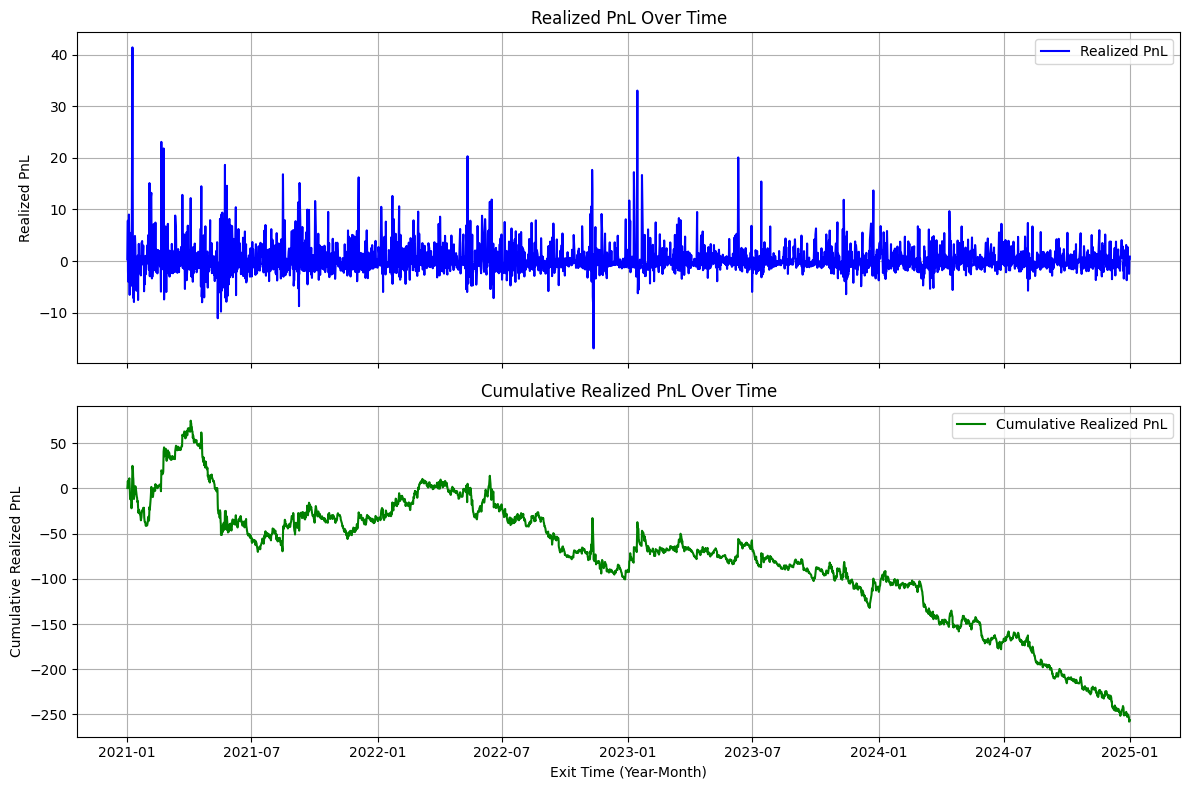

In [141]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

backtest_trade_sim_plot = final_df.copy()

# Convert exit_time from UNIX milliseconds to UTC+0 datetime
backtest_trade_sim_plot['exit_time_utc'] = pd.to_datetime(
    backtest_trade_sim_plot['close_time'], unit='ms', utc=True
)

# Plotting
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Realized PnL vs Exit Time
ax[0].plot(backtest_trade_sim_plot['exit_time_utc'], backtest_trade_sim_plot['PnL'], label='Realized PnL', color='blue')
ax[0].set_title('Realized PnL Over Time')
ax[0].set_ylabel('Realized PnL')

# Cumulative Realized PnL vs Exit Time
ax[1].plot(backtest_trade_sim_plot['exit_time_utc'], backtest_trade_sim_plot['cumulative_pnl'], label='Cumulative Realized PnL', color='green')
ax[1].set_title('Cumulative Realized PnL Over Time')
ax[1].set_ylabel('Cumulative Realized PnL')

# Format x-axis to show year and month
ax[1].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
ax[1].set_xlabel('Exit Time (Year-Month)')

# Improve layout and add gridlines
for axis in ax:
    axis.grid(True)
    axis.legend()

plt.tight_layout()
plt.show()

In [145]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

def plot_realized_pnl(backtest_trade_sim):
    backtest_trade_sim_plot = backtest_trade_sim.copy()

    # Convert exit_time from UNIX milliseconds to UTC+0 datetime
    backtest_trade_sim_plot['exit_time_utc'] = pd.to_datetime(
        backtest_trade_sim_plot['close_time'], unit='ms', utc=True
        )

    # Plotting
    fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    # Realized PnL vs Exit Time
    ax[0].plot(backtest_trade_sim_plot['exit_time_utc'], backtest_trade_sim_plot['PnL'], label='Realized PnL', color='blue')
    ax[0].set_title('Realized PnL Over Time')
    ax[0].set_ylabel('Realized PnL')

    # Cumulative Realized PnL vs Exit Time
    ax[1].plot(backtest_trade_sim_plot['exit_time_utc'], backtest_trade_sim_plot['cumulative_pnl'], label='Cumulative Realized PnL', color='green')
    ax[1].set_title('Cumulative Realized PnL Over Time')
    ax[1].set_ylabel('Cumulative Realized PnL')

    # Format x-axis to show year and month
    ax[1].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
    ax[1].set_xlabel('Exit Time (Year-Month)')

    # Improve layout and add gridlines
    for axis in ax:
        axis.grid(True)
        axis.legend()

    plt.tight_layout()
    plt.show()

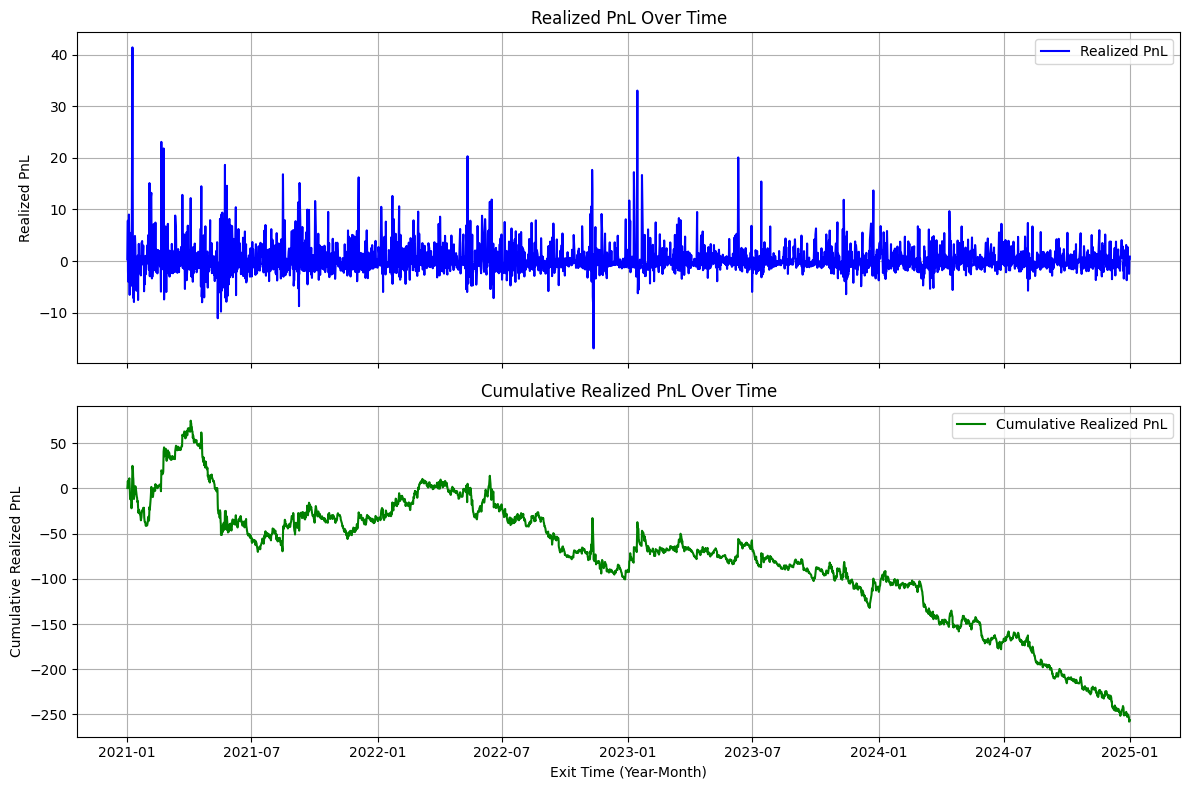

In [146]:
plot_realized_pnl(final_df)

# All Functions

In [1]:
import pandas as pd

def load_and_clean_data(csv_file):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_file)

    # # Drop unnecessary columns
    # df.drop(columns=['coin', 'volume', 'closetime', 'quotevolume', 'trades', 'taker_buy_volume', 'taker_buy_quote', 'unused'], inplace=True)

    # Return the cleaned DataFrame
    return df

In [3]:
import pandas as pd
import numpy as np
from pandas_ta.overlap import hl2
from pandas_ta.volatility import atr
from pandas_ta.utils import get_offset, verify_series

npNaN = np.nan

def calculate_supertrend(df, high_col='highprice', low_col='lowprice', close_col='closeprice', length=10, multiplier=3.0, offset=0, drop_columns=True, **kwargs):
    """
    Calculate the Supertrend indicator and merge it with the original DataFrame.
    
    Parameters:
        df (DataFrame): Original DataFrame containing the OHLC data.
        high_col (str): Name of the high price column. Default is 'highprice'.
        low_col (str): Name of the low price column. Default is 'lowprice'.
        close_col (str): Name of the close price column. Default is 'closeprice'.
        length (int): Lookback period for ATR calculation. Default is 10.
        multiplier (float): Multiplier for ATR. Default is 3.0.
        offset (int): Number of periods to shift the result. Default is 0.
        drop_columns (bool): Whether to drop intermediate columns. Default is True.
        **kwargs: Additional arguments for handling NaN values (e.g., fillna).
    
    Returns:
        DataFrame: The original DataFrame with Supertrend columns merged.
    """
    # Validate Arguments
    high = verify_series(df[high_col], length)
    low = verify_series(df[low_col], length)
    close = verify_series(df[close_col], length)
    offset = get_offset(offset)

    if high is None or low is None or close is None:
        return df

    m = close.size
    dir_, trend = [1] * m, [0] * m
    long, short = [np.nan] * m, [np.nan] * m

    hl2_ = hl2(high, low)
    matr = multiplier * atr(high, low, close, length)
    upperband = hl2_ + matr
    lowerband = hl2_ - matr

    for i in range(1, m):
        if close.iloc[i] > upperband.iloc[i - 1]:
            dir_[i] = 1
        elif close.iloc[i] < lowerband.iloc[i - 1]:
            dir_[i] = -1
        else:
            dir_[i] = dir_[i - 1]
            if dir_[i] > 0 and lowerband.iloc[i] < lowerband.iloc[i - 1]:
                lowerband.iloc[i] = lowerband.iloc[i - 1]
            if dir_[i] < 0 and upperband.iloc[i] > upperband.iloc[i - 1]:
                upperband.iloc[i] = upperband.iloc[i - 1]

        if dir_[i] > 0:
            trend[i] = long[i] = lowerband.iloc[i]
        else:
            trend[i] = short[i] = upperband.iloc[i]

    _props = f"_{length}_{multiplier}"
    supertrend_df = pd.DataFrame({
        f"SUPERT{_props}": trend,
        f"SUPERTd{_props}": dir_,
        f"SUPERTl{_props}": long,
        f"SUPERTs{_props}": short,
    }, index=close.index)

    # Apply offset if needed
    if offset != 0:
        supertrend_df = supertrend_df.shift(offset)

    # Handle fills
    if "fillna" in kwargs:
        supertrend_df.fillna(kwargs["fillna"], inplace=True)
    if "fill_method" in kwargs:
        supertrend_df.fillna(method=kwargs["fill_method"], inplace=True)

    # Merge with original DataFrame
    result_df = df.join(supertrend_df)

    # Drop unnecessary columns
    if drop_columns:
        result_df.drop(columns=[f"SUPERT{_props}", f"SUPERTd{_props}"], inplace=True)

    return result_df

In [4]:
import pandas as pd
import numpy as np

def compute_ichimoku_with_supertrend(supertrend_df, conversion_periods=9, base_periods=26, span_b_periods=52, displacement=26):
    """
    Compute Ichimoku Cloud components and join them with the original supertrend DataFrame.
    
    Parameters:
    - supertrend_df (DataFrame): The input DataFrame with 'highprice', 'lowprice', and 'closeprice' columns.
    - conversion_periods (int): Period for the Conversion Line (Tenkan-sen). Default is 9.
    - base_periods (int): Period for the Base Line (Kijun-sen). Default is 26.
    - span_b_periods (int): Period for Leading Span B (Senkou Span B). Default is 52.
    - displacement (int): Displacement for Leading Spans. Default is 26.
    
    Returns:
    - DataFrame: A DataFrame that combines the original supertrend DataFrame with the computed Ichimoku Cloud components.
    """
    # Helper to calculate the average of the highest high and lowest low
    def donchian(data, period):
        return (data['highprice'].rolling(window=period).max() + 
                data['lowprice'].rolling(window=period).min()) / 2

    # Compute Ichimoku Cloud components
    supertrend_df['conversion_line'] = donchian(supertrend_df, conversion_periods)
    supertrend_df['base_line'] = donchian(supertrend_df, base_periods)
    supertrend_df['leading_span_a'] = ((supertrend_df['conversion_line'] + supertrend_df['base_line']) / 2).shift(displacement)
    supertrend_df['leading_span_b'] = donchian(supertrend_df, span_b_periods).shift(displacement)
    supertrend_df['lagging_span'] = supertrend_df['closeprice'].shift(-displacement)
    
    # Drop unnecessary columns
    supertrend_df.drop(columns=['conversion_line', 'base_line', 'lagging_span'], inplace=True)
    
    return supertrend_df

In [5]:
# Add MACD

import pandas as pd
import numpy as np

def compute_macd(supertrend_df, fast_period=12, slow_period=26, signal_period=9):
    """
    Compute MACD and Signal Line and join them with the original supertrend DataFrame.
    
    Parameters:
    - supertrend_df (DataFrame): The input DataFrame with 'highprice', 'lowprice', and 'closeprice' columns.
    - fast_period (int): Period for the fast EMA (12-period). Default is 12.
    - slow_period (int): Period for the slow EMA (26-period). Default is 26.
    - signal_period (int): Period for the Signal line (9-period). Default is 9.
    
    Returns:
    - DataFrame: A DataFrame that combines the original supertrend DataFrame with the computed MACD components.
    """
    # Compute MACD Line (fast EMA - slow EMA)
    supertrend_df['macd_line'] = supertrend_df['closeprice'].ewm(span=fast_period, adjust=False).mean() - supertrend_df['closeprice'].ewm(span=slow_period, adjust=False).mean()
    
    # Compute Signal Line (9-period EMA of the MACD line)
    supertrend_df['signal_line'] = supertrend_df['macd_line'].ewm(span=signal_period, adjust=False).mean()
    
    # Compute Histogram (MACD Line - Signal Line)
    supertrend_df['histogram'] = supertrend_df['macd_line'] - supertrend_df['signal_line']
    
    # Return the DataFrame with MACD, Signal, and Histogram columns
    return supertrend_df

In [6]:
def ema_indicator(df):
    """
    Adds a 200-period EMA column to the given DataFrame.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame with a 'closeprice' column.
    
    Returns:
    pd.DataFrame: DataFrame with an additional 'ema_200' column.
    """
    # Calculate the EMA for the 200-period window
    df['ema_200'] = df['closeprice'].ewm(span=200, adjust=False).mean()
    
    # Mask the first 199 rows
    df.loc[:199, 'ema_200'] = None
    
    return df

In [7]:
import numpy as np

def process_dataframe(df_backtest):
    
    # Fill the 'trend' column based on conditions
    df_backtest['trend'] = np.where(
        (df_backtest['SUPERTl_10_3.0'].notna()) & (df_backtest['SUPERTs_10_3.0'].isna()), 1,
        np.where(
            (df_backtest['SUPERTs_10_3.0'].notna()) & (df_backtest['SUPERTl_10_3.0'].isna()), -1, np.nan
        )
    )

    df_backtest['trend_12'] = np.where(
        (df_backtest['SUPERTl_12_3.0'].notna()) & (df_backtest['SUPERTs_12_3.0'].isna()), 1,
        np.where(
            (df_backtest['SUPERTs_12_3.0'].notna()) & (df_backtest['SUPERTl_12_3.0'].isna()), -1, np.nan
        )
    )

    df_backtest['trend_11'] = np.where(
        (df_backtest['SUPERTl_11_2.0'].notna()) & (df_backtest['SUPERTs_11_2.0'].isna()), 1,
        np.where(
            (df_backtest['SUPERTs_11_2.0'].notna()) & (df_backtest['SUPERTl_11_2.0'].isna()), -1, np.nan
        )
    )

    df_backtest['trend_10'] = np.where(
        (df_backtest['SUPERTl_10_1.0'].notna()) & (df_backtest['SUPERTs_10_1.0'].isna()), 1,
        np.where(
            (df_backtest['SUPERTs_10_1.0'].notna()) & (df_backtest['SUPERTl_10_1.0'].isna()), -1, np.nan
        )
    )
    
    # Rename columns
    new_column_names = {
        'opentime': 'time',
        'openprice': 'open',
        'highprice': 'high',
        'lowprice': 'low',
        'closeprice': 'close',
        'leading_span_a': 'ic_a',
        'leading_span_b': 'ic_b',
        'histogram': 'macd'
    }
    df_backtest.rename(columns=new_column_names, inplace=True)
    
    # Drop unused columns
    df_backtest.drop(columns=['SUPERTl_10_3.0', 'SUPERTs_10_3.0','SUPERTl_12_3.0', 'SUPERTs_12_3.0','SUPERTl_11_2.0', 'SUPERTs_11_2.0','SUPERTl_10_1.0', 'SUPERTs_10_1.0', 'macd_line', 'signal_line'], inplace=True)
    
    # Drop first 77 rows
    df_backtest.drop(index=range(77), inplace=True)
    
    # Reset index
    df_backtest.reset_index(drop=True, inplace=True)
    
    # Return the processed DataFrame
    return df_backtest

In [8]:
def date_filtered_df(df,start,end):

    # Filter by timestamp
    df = df[df['time'] >= start]
    df = df[df['time'] < end]

    # Reset the index of the filtered DataFrame
    df.reset_index(drop=True, inplace=True)

    return df

## Strat

In [9]:
def st_ic(df, position = 2):

    # Initialize previous action and position tracker
    prev_action = None
    df['Real_Action'] = None
    
    # Iterate over rows starting from the second row
    for index in range(1, len(df)):
        # Access the current and previous rows
        row = df.iloc[index]
        prev_row = df.iloc[index - 1]

        # Check if the trend has changed
        if prev_row['trend'] != row['trend']:
            # Handle actions when the trend changes
            if position == 2 : # long and short
                if prev_action == 'Long':
                    if row['trend'] == -1 and row['close'] <= min(row['ic_a'], row['ic_b']):
                        df.at[index, 'Real_Action'] = 'Close Long and Open Short'
                        prev_action = 'Short' 
                    else:
                        df.at[index, 'Real_Action'] = 'Close Long'
                        prev_action = None

                elif prev_action == 'Short':
                    if row['trend'] == 1 and row['close'] >= max(row['ic_a'], row['ic_b']):
                        df.at[index, 'Real_Action'] = 'Close Short and Open Long'
                        prev_action = 'Long'
                    else:
                        df.at[index, 'Real_Action'] = 'Close Short'
                        prev_action = None

                elif prev_action is None:
                    if row['trend'] == 1 and row['close'] >= max(row['ic_a'], row['ic_b']):
                        df.at[index, 'Real_Action'] = 'Open Long'
                        prev_action = 'Long'
                    elif row['trend'] == -1 and row['close'] <= min(row['ic_a'], row['ic_b']):
                        df.at[index, 'Real_Action'] = 'Open Short'
                        prev_action = 'Short'
                    else :
                        df.at[index, 'Real_Action'] = None
                        prev_action = None

            elif position == 1 : #long only
                # Handle actions when the trend changes
                if prev_action == 'Long':
                    if row['trend'] == -1 :
                        df.at[index, 'Real_Action'] = 'Close Long'
                        prev_action = None

                elif prev_action is None:
                    if row['trend'] == 1 and row['close'] >= max(row['ic_a'], row['ic_b']):
                        df.at[index, 'Real_Action'] = 'Open Long'
                        prev_action = 'Long'
                    else :
                        df.at[index, 'Real_Action'] = None
                        prev_action = None

            elif position == -1 : #short only
                # Handle actions when the trend changes
                if prev_action == 'Short':
                    if row['trend'] == 1 :
                        df.at[index, 'Real_Action'] = 'Close Short'
                        prev_action = None

                elif prev_action is None:
                    if row['trend'] == -1 and row['close'] <= min(row['ic_a'], row['ic_b']):
                        df.at[index, 'Real_Action'] = 'Open Short'
                        prev_action = 'Short'
                    else :
                        df.at[index, 'Real_Action'] = None
                        prev_action = None

        # Handle actions within the same trend
        else:
            if prev_action == 'Long':
                df.at[index, 'Real_Action'] = 'Hold Long'
                prev_action = 'Long'
            elif prev_action == 'Short':
                df.at[index, 'Real_Action'] = 'Hold Short'
                prev_action = 'Short'
            elif prev_action is None:
                if position == 2:
                    if row['trend'] == 1 and row['close'] >= max(row['ic_a'], row['ic_b']):
                        df.at[index, 'Real_Action'] = 'Open Long'
                        prev_action = 'Long'
                    elif row['trend'] == -1 and row['close'] <= min(row['ic_a'], row['ic_b']):
                        df.at[index, 'Real_Action'] = 'Open Short'
                        prev_action = 'Short'
                    else :
                        df.at[index, 'Real_Action'] = None
                        prev_action = None
                
                elif position == 1:
                    if row['trend'] == 1 and row['close'] >= max(row['ic_a'], row['ic_b']):
                        df.at[index, 'Real_Action'] = 'Open Long'
                        prev_action = 'Long'
                    else :
                        df.at[index, 'Real_Action'] = None
                        prev_action = None

                elif position == -1:
                    if row['trend'] == -1 and row['close'] <= min(row['ic_a'], row['ic_b']):
                        df.at[index, 'Real_Action'] = 'Open Short'
                        prev_action = 'Short'
                    else :
                        df.at[index, 'Real_Action'] = None
                        prev_action = None

     # Get the last row Real_Action
    last_row_action = df.iloc[-1]

    # Check the value in 'Real_Action' and update accordingly
    if last_row_action['Real_Action'] == 'Hold Long':
        df.at[df.index[-1], 'Real_Action'] = 'Close Long'
    elif last_row_action['Real_Action'] == 'Hold Short':
        df.at[df.index[-1], 'Real_Action'] = 'Close Short'
    else:
        df.at[df.index[-1], 'Real_Action'] = None

    return df

In [10]:
def st_ema (df, position = 2):

    # Initialize previous action and position tracker
    prev_action = None
    df['Real_Action'] = None
    
    # Iterate over rows starting from the second row
    for index in range(1, len(df)):
        # Access the current and previous rows
        row = df.iloc[index]
        prev_row = df.iloc[index - 1]

        # Check if the trend has changed
        if prev_row['trend'] != row['trend']:
            # Handle actions when the trend changes
            if position == 2 : # long and short
                if prev_action == 'Long':
                    if row['trend'] == -1 and row['close'] <= row['ema_200']:
                        df.at[index, 'Real_Action'] = 'Close Long and Open Short'
                        prev_action = 'Short' 
                    elif row['trend'] == -1:
                        df.at[index, 'Real_Action'] = 'Close Long'
                        prev_action = None
                elif prev_action == 'Short':
                    if row['trend'] == 1 and row['close'] >= row['ema_200']:
                        df.at[index, 'Real_Action'] = 'Close Short and Open Long'
                        prev_action = 'Long'
                    elif row['trend'] == 1:
                        df.at[index, 'Real_Action'] = 'Close Short'
                        prev_action = None
                elif prev_action is None:
                    if row['trend'] == 1 and row['close'] >= row['ema_200']:
                        df.at[index, 'Real_Action'] = 'Open Long'
                        prev_action = 'Long'
                    elif row['trend'] == -1 and row['close'] <= row['ema_200']:
                        df.at[index, 'Real_Action'] = 'Open Short'
                        prev_action = 'Short'
                    else :
                        df.at[index, 'Real_Action'] = None
                        prev_action = None

            elif position == 1 : #long only
                if prev_action == 'Long':
                    if row['trend'] == -1 :
                        df.at[index, 'Real_Action'] = 'Close Long'
                        prev_action = None
                elif prev_action is None:
                    if row['trend'] == 1 and row['close'] >= row['ema_200']:
                        df.at[index, 'Real_Action'] = 'Open Long'
                        prev_action = 'Long'
                    else :
                        df.at[index, 'Real_Action'] = None
                        prev_action = None

            elif position == -1 : #short only
                if prev_action == 'Short':
                    if row['trend'] == 1 :
                        df.at[index, 'Real_Action'] = 'Close Short'
                        prev_action = None
                elif prev_action is None:
                    if row['trend'] == -1 and row['close'] <= row['ema_200']:
                        df.at[index, 'Real_Action'] = 'Open Short'
                        prev_action = 'Short'
                    else :
                        df.at[index, 'Real_Action'] = None
                        prev_action = None

        # Handle actions within the same trend
        else:
            if prev_action == 'Long':
                df.at[index, 'Real_Action'] = 'Hold Long'
                prev_action = 'Long'
            elif prev_action == 'Short':
                df.at[index, 'Real_Action'] = 'Hold Short'
                prev_action = 'Short'
            elif prev_action is None:
                if position == 2:
                    if row['trend'] == 1 and row['close'] >= max(row['ic_a'], row['ic_b']):
                        df.at[index, 'Real_Action'] = 'Open Long'
                        prev_action = 'Long'
                    elif row['trend'] == -1 and row['close'] <= min(row['ic_a'], row['ic_b']):
                        df.at[index, 'Real_Action'] = 'Open Short'
                        prev_action = 'Short'
                    else :
                        df.at[index, 'Real_Action'] = None
                        prev_action = None
                
                elif position == 1:
                    if row['trend'] == 1 and row['close'] >= max(row['ic_a'], row['ic_b']):
                        df.at[index, 'Real_Action'] = 'Open Long'
                        prev_action = 'Long'
                    else :
                        df.at[index, 'Real_Action'] = None
                        prev_action = None

                elif position == -1:
                    if row['trend'] == -1 and row['close'] <= min(row['ic_a'], row['ic_b']):
                        df.at[index, 'Real_Action'] = 'Open Short'
                        prev_action = 'Short'
                    else :
                        df.at[index, 'Real_Action'] = None
                        prev_action = None

     # Get the last row Real_Action
    last_row_action = df.iloc[-1]

    # Check the value in 'Real_Action' and update accordingly
    if last_row_action['Real_Action'] == 'Hold Long':
        df.at[df.index[-1], 'Real_Action'] = 'Close Long'
    elif last_row_action['Real_Action'] == 'Hold Short':
        df.at[df.index[-1], 'Real_Action'] = 'Close Short'
    else:
        df.at[df.index[-1], 'Real_Action'] = None

    return df

In [11]:
def st_3(df, position = 2):

    # Initialize previous action and position tracker
    prev_action = None
    df['Real_Action'] = None
    
    # Iterate over rows starting from the second row
    for index in range(1, len(df)):
        # Access the current and previous rows
        row = df.iloc[index]
        prev_row = df.iloc[index - 1]

        if position == 2 : # long and short
            if prev_action == 'Long':
                if row['trend_12'] == -1 and row['trend_11'] == -1 and row['trend_10'] == -1:
                    df.at[index, 'Real_Action'] = 'Close Long and Open Short'
                    prev_action = 'Short' 
                else:
                    df.at[index, 'Real_Action'] = 'Hold Long'
                    prev_action = 'Long'

            elif prev_action == 'Short':
                if row['trend_12'] == 1 and row['trend_11'] == 1 and row['trend_10'] == 1:
                    df.at[index, 'Real_Action'] = 'Close Short and Open Long'
                    prev_action = 'Long'
                else:
                    df.at[index, 'Real_Action'] = 'Hold Short'
                    prev_action = 'Short'

            elif prev_action is None:
                if row['trend_12'] == 1 and row['trend_11'] == 1 and row['trend_10'] == 1:
                    df.at[index, 'Real_Action'] = 'Open Long'
                    prev_action = 'Long'
                elif row['trend_12'] == -1 and row['trend_11'] == -1 and row['trend_10'] == -1:
                    df.at[index, 'Real_Action'] = 'Open Short'
                    prev_action = 'Short'
                else :
                    df.at[index, 'Real_Action'] = None
                    prev_action = None

        elif position == 1 : #long only
            # Handle actions when the trend changes
            if prev_action == 'Long':
                if row['trend_12'] == -1 and row['trend_11'] == -1 and row['trend_10'] == -1:
                    df.at[index, 'Real_Action'] = 'Close Long'
                    prev_action = None
                else:
                    df.at[index, 'Real_Action'] = 'Hold Long'
                    prev_action = 'Long'

            elif prev_action is None:
                if row['trend_12'] == 1 and row['trend_11'] == 1 and row['trend_10'] == 1:
                    df.at[index, 'Real_Action'] = 'Open Long'
                    prev_action = 'Long'
                else :
                    df.at[index, 'Real_Action'] = None
                    prev_action = None

        elif position == -1 : #short only
            # Handle actions when the trend changes
            if prev_action == 'Short':
                if row['trend_12'] == 1 and row['trend_11'] == 1 and row['trend_10'] == 1:
                    df.at[index, 'Real_Action'] = 'Close Short'
                    prev_action = None
                else :
                    df.at[index, 'Real_Action'] = 'Hold Short'
                    prev_action = 'Short'

            elif prev_action is None:
                if row['trend_12'] == -1 and row['trend_11'] == -1 and row['trend_10'] == -1:
                    df.at[index, 'Real_Action'] = 'Open Short'
                    prev_action = 'Short'
                else :
                    df.at[index, 'Real_Action'] = None
                    prev_action = None

     # Get the last row Real_Action
    last_row_action = df.iloc[-1]

    # Check the value in 'Real_Action' and update accordingly
    if last_row_action['Real_Action'] == 'Hold Long':
        df.at[df.index[-1], 'Real_Action'] = 'Close Long'
    elif last_row_action['Real_Action'] == 'Hold Short':
        df.at[df.index[-1], 'Real_Action'] = 'Close Short'
    else:
        df.at[df.index[-1], 'Real_Action'] = None

    return df

In [12]:
def st_ic_ema(df, position = 2):

    # Initialize previous action and position tracker
    prev_action = None
    df['Real_Action'] = None
    
    # Iterate over rows starting from the second row
    for index in range(1, len(df)):
        # Access the current and previous rows
        row = df.iloc[index]
        prev_row = df.iloc[index - 1]

        # Check if the trend has changed
        if prev_row['trend'] != row['trend']:
            # Handle actions when the trend changes
            if position == 2 : # long and short
                if prev_action == 'Long':
                    if row['trend'] == -1 and row['close'] <= min(row['ic_a'], row['ic_b']) and row['close'] <= row['ema_200']:
                        df.at[index, 'Real_Action'] = 'Close Long and Open Short'
                        prev_action = 'Short' 
                    else:
                        df.at[index, 'Real_Action'] = 'Close Long'
                        prev_action = None

                elif prev_action == 'Short':
                    if row['trend'] == 1 and row['close'] >= max(row['ic_a'], row['ic_b']) and row['close'] >= row['ema_200']:
                        df.at[index, 'Real_Action'] = 'Close Short and Open Long'
                        prev_action = 'Long'
                    else:
                        df.at[index, 'Real_Action'] = 'Close Short'
                        prev_action = None

                elif prev_action is None:
                    if row['trend'] == 1 and row['close'] >= max(row['ic_a'], row['ic_b']) and row['close'] >= row['ema_200']:
                        df.at[index, 'Real_Action'] = 'Open Long'
                        prev_action = 'Long'
                    elif row['trend'] == -1 and row['close'] <= min(row['ic_a'], row['ic_b']) and row['close'] <= row['ema_200']:
                        df.at[index, 'Real_Action'] = 'Open Short'
                        prev_action = 'Short'
                    else :
                        df.at[index, 'Real_Action'] = None
                        prev_action = None

            elif position == 1 : #long only
                # Handle actions when the trend changes
                if prev_action == 'Long':
                    if row['trend'] == -1 :
                        df.at[index, 'Real_Action'] = 'Close Long'
                        prev_action = None

                elif prev_action is None:
                    if row['trend'] == 1 and row['close'] >= max(row['ic_a'], row['ic_b']) and row['close'] >= row['ema_200']:
                        df.at[index, 'Real_Action'] = 'Open Long'
                        prev_action = 'Long'
                    else :
                        df.at[index, 'Real_Action'] = None
                        prev_action = None

            elif position == -1 : #short only
                # Handle actions when the trend changes
                if prev_action == 'Short':
                    if row['trend'] == 1 :
                        df.at[index, 'Real_Action'] = 'Close Short'
                        prev_action = None

                elif prev_action is None:
                    if row['trend'] == -1 and row['close'] <= min(row['ic_a'], row['ic_b']) and row['close'] <= row['ema_200']:
                        df.at[index, 'Real_Action'] = 'Open Short'
                        prev_action = 'Short'
                    else :
                        df.at[index, 'Real_Action'] = None
                        prev_action = None

        # Handle actions within the same trend
        else:
            if prev_action == 'Long':
                df.at[index, 'Real_Action'] = 'Hold Long'
                prev_action = 'Long'
            elif prev_action == 'Short':
                df.at[index, 'Real_Action'] = 'Hold Short'
                prev_action = 'Short'
            elif prev_action is None:
                if position == 2:
                    if row['trend'] == 1 and row['close'] >= max(row['ic_a'], row['ic_b']) and row['close'] >= row['ema_200']:
                        df.at[index, 'Real_Action'] = 'Open Long'
                        prev_action = 'Long'
                    elif row['trend'] == -1 and row['close'] <= min(row['ic_a'], row['ic_b']) and row['close'] <= row['ema_200']:
                        df.at[index, 'Real_Action'] = 'Open Short'
                        prev_action = 'Short'
                    else :
                        df.at[index, 'Real_Action'] = None
                        prev_action = None
                
                elif position == 1:
                    if row['trend'] == 1 and row['close'] >= max(row['ic_a'], row['ic_b']) and row['close'] >= row['ema_200']:
                        df.at[index, 'Real_Action'] = 'Open Long'
                        prev_action = 'Long'
                    else :
                        df.at[index, 'Real_Action'] = None
                        prev_action = None

                elif position == -1:
                    if row['trend'] == -1 and row['close'] <= min(row['ic_a'], row['ic_b']) and row['close'] <= row['ema_200']:
                        df.at[index, 'Real_Action'] = 'Open Short'
                        prev_action = 'Short'
                    else :
                        df.at[index, 'Real_Action'] = None
                        prev_action = None

     # Get the last row Real_Action
    last_row_action = df.iloc[-1]

    # Check the value in 'Real_Action' and update accordingly
    if last_row_action['Real_Action'] == 'Hold Long':
        df.at[df.index[-1], 'Real_Action'] = 'Close Long'
    elif last_row_action['Real_Action'] == 'Hold Short':
        df.at[df.index[-1], 'Real_Action'] = 'Close Short'
    else:
        df.at[df.index[-1], 'Real_Action'] = None

    return df

## Other Processing Functions

In [13]:
def separate_open_close(df):
    # List to hold rows for final DataFrame
    new_rows = []
    
    for i, row in df.iterrows():
        action = row['Real_Action']
        
        # Check for combined 'Close' and 'Open' actions
        if isinstance(action, str) and 'and' in action:
            # Split the combined action into two separate actions
            actions = action.split('and')
            
            # Create the first row with the first action (Close)
            close_row = row.copy()
            close_row['Real_Action'] = actions[0].strip()  # "Close Long"
            new_rows.append(close_row)
            
            # Create the second row with the second action (Open)
            open_row = row.copy()
            open_row['Real_Action'] = actions[1].strip()  # "Open Short"
            new_rows.append(open_row)
        else:
            # If no combined action, just append the row
            new_rows.append(row)
    
    # Create a new DataFrame from the new_rows list
    df_separated = pd.DataFrame(new_rows).reset_index(drop=True)
    
    return df_separated

In [14]:
def pnl_capping(df, profit_cap=None, loss_cap=None):
    """
    Calculate max and min profit/loss percentage for a trading cycle,
    and apply profit or loss capping if specified.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing the trading data.
    profit_cap (float or None): The cap percentage for profit. Should be positive. If None, no cap is applied.
    loss_cap (float or None): The cap percentage for loss. Should be negative. If None, no cap is applied.
    
    Returns:
    pd.DataFrame: DataFrame with updated close prices and calculated PnL.
    """
    # Validate profit_cap and loss_cap
    if profit_cap is not None and profit_cap <= 0:
        raise ValueError("profit_cap should be a positive number.")
    
    if loss_cap is not None and loss_cap >= 0:
        raise ValueError("loss_cap should be a negative number.")
    
    df_copy = df.copy()
    df_copy['max_pnl'] = None
    df_copy['min_pnl'] = None
    df_copy['profit_or_loss_first'] = None
    max_pnl = 0
    min_pnl = 0
    in_cycle = False
    entry_price = 0

    for i, row in df_copy.iterrows():
        # Start a new cycle when opening a position
        if row['Real_Action'] in ['Open Short', 'Open Long'] and not in_cycle:
            in_cycle = True
            entry_price = row['close']
        
        # Handle 'Hold' and 'Close' actions
        elif row['Real_Action'] in ['Hold Short', 'Hold Long', 'Close Short', 'Close Long'] and in_cycle :
            if row['Real_Action'] in ['Hold Short', 'Close Short']:
                max_pnl = (entry_price - row['low']) / entry_price * 100
                min_pnl = (entry_price - row['high']) / entry_price * 100
            elif row['Real_Action'] in ['Hold Long', 'Close Long']:
                max_pnl = (row['high'] - entry_price) / entry_price * 100
                min_pnl = (row['low'] - entry_price) / entry_price * 100

            # Update max_pnl and min_pnl
            df_copy.at[i, 'max_pnl'] = max_pnl
            df_copy.at[i, 'min_pnl'] = min_pnl

            # Apply loss cap
            if loss_cap is not None and min_pnl <= loss_cap:
                df_copy.at[i, 'profit_or_loss_first'] = 'Loss Capped'
                df_copy.at[i, 'close'] = (entry_price * (1 + loss_cap / 100) if row['Real_Action'] in ['Hold Long', 'Close Long']
                                            else entry_price * (1 - loss_cap / 100))
                df_copy.at[i, 'Real_Action'] = 'Close Long' if row['Real_Action'] in ['Hold Long', 'Close Long'] else 'Close Short'
                in_cycle = False
            
            # Apply profit cap
            elif profit_cap is not None and max_pnl >= profit_cap:
                df_copy.at[i, 'profit_or_loss_first'] = 'Profit Capped'
                df_copy.at[i, 'close'] = (entry_price * (1 + profit_cap / 100) if row['Real_Action'] in ['Hold Long', 'Close Long']
                                            else entry_price * (1 - profit_cap / 100))
                df_copy.at[i, 'Real_Action'] = 'Close Long' if row['Real_Action'] in ['Hold Long', 'Close Long'] else 'Close Short'
                in_cycle = False

    # Final adjustments for capped rows
    for i in range(len(df_copy)):
        profit_or_loss = df_copy.iloc[i]['profit_or_loss_first']
        if profit_or_loss == 'Profit Capped':
            df_copy.at[i, 'max_pnl'] = profit_cap
        elif profit_or_loss == 'Loss Capped':
            df_copy.at[i, 'min_pnl'] = loss_cap

    # Adjust Real_Action
    for i in range(1, len(df_copy)):
        current_action = df_copy.iloc[i]['Real_Action']
        previous_action = df_copy.iloc[i-1]['Real_Action']
        
        # If previous action is 'Close' (either 'Close Short' or 'Close Long') and current action is 'Hold' or 'Close'
        if previous_action in ['Close Short', 'Close Long'] and current_action in ['Hold Short', 'Hold Long', 'Close Short', 'Close Long']:
            df_copy.iloc[i, df_copy.columns.get_loc('Real_Action')] = None
        
        # If previous action is None, and current action is 'Hold' or 'Close'
        elif previous_action is None and current_action in ['Hold Long', 'Hold Short', 'Close Short', 'Close Long']:
            df_copy.iloc[i, df_copy.columns.get_loc('Real_Action')] = None

    return df_copy

In [15]:
import pandas as pd

def get_positions(df, position_selection = None):
    
    positions = []
    position = None
    max_high = -float('inf')
    min_low = float('inf')
    entry_price = None
    close_price = None
    
    for i, row in df.iterrows():
        # Ensure 'Real_Action' is not None and important columns are not NaN
        if pd.isna(row['Real_Action']) or pd.isna(row['close']) or pd.isna(row['time']):
            continue  # Skip rows with missing data
        
        # Check for open positions (handling cases where 'Open' and 'Close' happen in the same row)
        if 'Open' in row['Real_Action']:
            if position:  # If there is a previous position, store it
                position['max_high'] = max_high
                position['min_low'] = min_low
                positions.append(position)

            # Start a new position
            entry_price = row['close']  # The entry price is the close price at the open time
            position = {
                'action': 'Short' if 'Short' in row['Real_Action'] else 'Long',
                'open_time': row['time'],
                'entry_price': entry_price,
                'max_high': row['high'],
                'min_low': row['low'],
                'close_time': None,  # Initialize as None
                'close_price': None  # Initialize as None
            }
            max_high = row['high']
            min_low = row['low']
        
        # Update max high and min low during 'Hold' positions
        elif 'Hold' in row['Real_Action']:
            if position:
                max_high = max(max_high, row['high'])
                min_low = min(min_low, row['low'])

        # Check for close positions
        elif 'Close' in row['Real_Action']:
            if position:
                close_price = row['close']  # The close price is the close price at the close time
                position['close_time'] = row['time']
                position['close_price'] = close_price
                position['max_high'] = max(max_high, row['high'])
                position['min_low'] = min(min_low, row['low'])
                positions.append(position)
                position = None
                max_high = -float('inf')
                min_low = float('inf')
    
    # Handle the case where a position is not closed at the end of the DataFrame
    if position:
        position['max_high'] = max_high
        position['min_low'] = min_low
        positions.append(position)

    # Convert positions to DataFrame
    positions_df = pd.DataFrame(positions)

    positions_df.dropna(subset=['close_time'],inplace=True)

    if position_selection == 1 :
        positions_df = positions_df[positions_df['action'] == 'Long']
    elif position_selection == -1 :
        positions_df = positions_df[positions_df['action'] == 'Short']

    # # Calculate PnL and add it as a new column
    # positions_df['pnl'] = positions_df.apply(
    #     lambda row: ((row['close_price'] - row['entry_price']) / row['entry_price'] * 100) if row['action'] == "Long" 
    #     else ((row['entry_price'] - row['close_price']) / row['entry_price'] * 100),
    #     axis=1)

    return positions_df

In [16]:
import pandas as pd

def find_min_rel_cum_pnl(backtest_trade_sim):
    """
    This function iterates through each row in the 'backtest_trade_sim' DataFrame,
    slices the DataFrame from the current row to the end, recalculates the 
    'rel_cum_pnl', and returns the overall minimum 'rel_cum_pnl'
    value and the corresponding sliced DataFrame up to the row where the minimum 
    occurred.
    
    Parameters:
    backtest_trade_sim (pd.DataFrame): The DataFrame containing trade data
    
    Returns:
    tuple: A tuple containing the minimum 'rel_cum_pnl' value and the 
           sliced DataFrame producing that minimum.
    """
    # Initialize the variable to track the overall minimum rel_cum_pnl
    min_rel_cum_pnl = float('inf')
    min_slice_df = None  # To store the sliced DataFrame producing the minimum value

    # Iterate through each row and slice the DataFrame from the current row to the end
    for i in range(len(backtest_trade_sim)):
        # Slice the DataFrame from the current row to the last
        sliced_df = backtest_trade_sim.iloc[i:].copy()  # Make a copy to avoid SettingWithCopyWarning
        
        # Recalculate the relative cumulative pnl
        sliced_df['rel_cum_pnl'] = sliced_df['PnL'].cumsum()
        
        # Find the minimum value of the newly calculated 'rel_cum_pnl'
        min_in_iteration = sliced_df['rel_cum_pnl'].min()
        
        # Track the overall minimum rel_cum_pnl and the corresponding sliced DataFrame
        if min_in_iteration < min_rel_cum_pnl:
            min_rel_cum_pnl = min_in_iteration
            # Get the row where the minimum occurred
            min_row_index = sliced_df['rel_cum_pnl'].idxmin()
            min_slice_df = sliced_df.loc[:min_row_index]  # Slice until the row with the minimum value

    return min_rel_cum_pnl, min_slice_df

In [17]:
import pandas as pd
import numpy as np

def calculate_metrics(df, maker_fee = 0.05, funding_rate = 0.01, risk_free_rate = 0.046):
    # Initialize the metrics dictionary
    metrics = {
        'total_rows': len(df),
        'short_count': len(df[df['action'] == 'Short']),
        'long_count': len(df[df['action'] == 'Long']),
        'winrate': None,
        'short_winrate': None,
        'long_winrate': None,
        'cumulative_pnl': None,
        'pnl_stats': None,
        'unrealized_stats': None,
        'hold_time_stats': None,
        'unrealized_vs_pnl_check': [],  # To store the check results
        'longest_lose_streak': None,
        'longest_lose_streak_cum_pnl': None,
        'most_negative_cum_pnl': None,
        'longest_win_streak': None,
        'longest_win_streak_cum_pnl': None,
        'most_positive_cum_pnl': None,
        'sharpe_ratio': None  # Placeholder for Sharpe ratio
    }

    # Initialize the cumulative PnL list and other tracking variables
    cumulative_pnl = 0
    cumulative_pnls = []
    
    longest_lose_streak = 0
    current_lose_streak = 0
    longest_lose_streak_cum_pnl = 0
    current_lose_streak_cum_pnl = 0
    most_negative_cum_pnl = float('inf')
    
    longest_win_streak = 0
    current_win_streak = 0
    longest_win_streak_cum_pnl = 0
    current_win_streak_cum_pnl = 0
    most_positive_cum_pnl = float('-inf')

    for i, row in df.iterrows():
        entry_price = row['entry_price']
        close_price = row['close_price']
        max_high = row['max_high']
        min_low = row['min_low']
        action = row['action']
        open_time = row['open_time']
        close_time = row['close_time']

        # Calculate hold time in hours (close_time - open_time)
        hold_time_ms = close_time - open_time
        hold_time_hours = hold_time_ms / (1000 * 3600)  # Convert milliseconds to hours
        df.at[i, 'hold_time'] = hold_time_hours

        # Calculate how many funding rates does the position got
        funding_rate_occurence = hold_time_hours // 8
        funding_fee_total = funding_rate_occurence * funding_rate
        df.at[i, 'funding_fee_total'] = funding_fee_total

        # Calculate PnL
        if action == 'Short':
            pnl = ((entry_price - close_price) / entry_price) * 100 
        elif action == 'Long':
            pnl = ((close_price - entry_price) / entry_price) * 100
        else :
            pnl = np.nan
        
        # Apply maker fee (0.05%)
        pnl -= (2 * maker_fee)

        # Apply funding fee (0.1%)
        pnl -= funding_fee_total

        df.at[i, 'PnL'] = pnl

        # Calculate max unrealized loss and profit
        if action == 'Short':
            max_unrealized_loss = ((entry_price - max_high) / entry_price) * 100
            max_unrealized_profit = ((entry_price - min_low) / entry_price) * 100
        elif action == 'Long':
            max_unrealized_profit = ((max_high - entry_price) / entry_price) * 100
            max_unrealized_loss = ((min_low - entry_price) / entry_price) * 100
        else :
            max_unrealized_profit = np.nan
            max_unrealized_loss = np.nan
        
        df.at[i, 'max_unrealized_loss'] = max_unrealized_loss
        df.at[i, 'max_unrealized_profit'] = max_unrealized_profit

        # Set the outcome based on PnL
        if pnl >= 0:
            df.at[i, 'outcome'] = 'Win'
            if current_lose_streak > longest_lose_streak:
                longest_lose_streak = current_lose_streak
                longest_lose_streak_cum_pnl = current_lose_streak_cum_pnl
            current_lose_streak = 0
            current_lose_streak_cum_pnl = 0

            # Track win streak
            current_win_streak += 1
            current_win_streak_cum_pnl += pnl
            most_positive_cum_pnl = max(most_positive_cum_pnl, cumulative_pnl)
        elif pnl < 0:
            df.at[i, 'outcome'] = 'Lose'
            current_lose_streak += 1
            current_lose_streak_cum_pnl += pnl
            
            # Track win streak reset
            longest_win_streak = max(longest_win_streak, current_win_streak)
            longest_win_streak_cum_pnl = max(longest_win_streak_cum_pnl, current_win_streak_cum_pnl)
            current_win_streak = 0
            current_win_streak_cum_pnl = 0
        else :
            df.at[i, 'outcome'] = None
        
        # Add cumulative PnL
        cumulative_pnl += pnl
        cumulative_pnls.append(cumulative_pnl)
        
        # Track the most negative cumulative PnL
        most_negative_cum_pnl = min(most_negative_cum_pnl, cumulative_pnl)

        # Check if max_unrealized_loss_min is smaller than PnL_min
        pnl_min = df['PnL'].min()
        unrealized_loss_min = df['max_unrealized_loss'].min()

        if unrealized_loss_min < pnl_min:
            unrealized_check = 'Unrealized Loss Min is smaller than PnL Min'
        elif unrealized_loss_min > pnl_min:
            unrealized_check = 'Unrealized Loss Min is greater than PnL Min'
        else:
            unrealized_check = 'Unrealized Loss Min is equal to PnL Min'

        metrics['unrealized_vs_pnl_check'].append(unrealized_check)

    df['cumulative_pnl'] = cumulative_pnls
    
    # Get the last cumulative PnL value
    metrics['cumulative_pnl'] = cumulative_pnls[-1] if cumulative_pnls else None

    # Calculate win rate
    win_count = len(df[df['outcome'] == 'Win'])
    total_count = len(df)
    metrics['winrate'] = (win_count / total_count) * 100 if total_count > 0 else 0  # Convert to percentage
    
    # Calculate short and long win rates
    short_win_count = len(df[(df['action'] == 'Short') & (df['outcome'] == 'Win')])
    long_win_count = len(df[(df['action'] == 'Long') & (df['outcome'] == 'Win')])
    metrics['short_winrate'] = (short_win_count / metrics['short_count']) * 100 if metrics['short_count'] > 0 else 0
    metrics['long_winrate'] = (long_win_count / metrics['long_count']) * 100 if metrics['long_count'] > 0 else 0

    # Calculate statistics for PnL, max unrealized loss, max unrealized profit, and hold time
    metrics['pnl_stats'] = {
        'max': df['PnL'].max(),
        'min': df['PnL'].min(),
        'mean': df['PnL'].mean(),
        'median': df['PnL'].median()
    }
    
    metrics['unrealized_stats'] = {
        'max_unrealized_loss_max': df['max_unrealized_loss'].max(),
        'max_unrealized_loss_min': df['max_unrealized_loss'].min(),
        'max_unrealized_loss_mean': df['max_unrealized_loss'].mean(),
        'max_unrealized_loss_median': df['max_unrealized_loss'].median(),
        'max_unrealized_profit_max': df['max_unrealized_profit'].max(),
        'max_unrealized_profit_min': df['max_unrealized_profit'].min(),
        'max_unrealized_profit_mean': df['max_unrealized_profit'].mean(),
        'max_unrealized_profit_median': df['max_unrealized_profit'].median()
    }
    
    metrics['hold_time_stats'] = {
        'max': df['hold_time'].max(),
        'min': df['hold_time'].min(),
        'mean': df['hold_time'].mean(),
        'median': df['hold_time'].median()
    }

    # Store the longest lose streak and cumulative PnL
    metrics['longest_lose_streak'] = longest_lose_streak
    metrics['longest_lose_streak_cum_pnl'] = longest_lose_streak_cum_pnl
    metrics['most_negative_cum_pnl'] = most_negative_cum_pnl

    # Store the longest win streak and cumulative PnL
    metrics['longest_win_streak'] = longest_win_streak
    metrics['longest_win_streak_cum_pnl'] = longest_win_streak_cum_pnl
    metrics['most_positive_cum_pnl'] = most_positive_cum_pnl

    # Calculate the Sharpe ratio
    returns = df['PnL'] / 100  # Convert percentage to decimal
    excess_returns = returns - risk_free_rate / 252  # Assuming daily returns, 252 trading days in a year
    sharpe_ratio = excess_returns.mean() / excess_returns.std() * np.sqrt(252) if excess_returns.std() != 0 else np.nan
    metrics['sharpe_ratio'] = sharpe_ratio

    # Convert metrics into a DataFrame for neat display
    metrics_df = pd.DataFrame({
        'Metric': [
            'Total Trades', 'Short Count', 'Long Count', 'Win Rate (%)', 'Short Win Rate (%)', 'Long Win Rate (%)', 
            'Cumulative PnL', 'PnL Max', 'PnL Min', 'PnL Mean', 'PnL Median', 
            'Max Unrealized Loss Max', 'Max Unrealized Loss Min', 
            'Max Unrealized Loss Mean', 'Max Unrealized Loss Median', 
            'Max Unrealized Profit Max', 'Max Unrealized Profit Min', 
            'Max Unrealized Profit Mean', 'Max Unrealized Profit Median', 
            'Hold Time Max', 'Hold Time Min', 'Hold Time Mean', 'Hold Time Median',
            'Unrealized vs PnL Check', 
            'Longest Lose Streak', 'Longest Lose Streak Cumulative PnL', 'Most Negative Cumulative PnL',
            'Longest Win Streak', 'Longest Win Streak Cumulative PnL', 'Most Positive Cumulative PnL',
            'Sharpe Ratio'
        ],
        'Value': [
            metrics['total_rows'], metrics['short_count'], metrics['long_count'], 
            metrics['winrate'], metrics['short_winrate'], metrics['long_winrate'],
            metrics['cumulative_pnl'], metrics['pnl_stats']['max'], metrics['pnl_stats']['min'],
            metrics['pnl_stats']['mean'], metrics['pnl_stats']['median'],
            metrics['unrealized_stats']['max_unrealized_loss_max'], metrics['unrealized_stats']['max_unrealized_loss_min'],
            metrics['unrealized_stats']['max_unrealized_loss_mean'], metrics['unrealized_stats']['max_unrealized_loss_median'],
            metrics['unrealized_stats']['max_unrealized_profit_max'], metrics['unrealized_stats']['max_unrealized_profit_min'],
            metrics['unrealized_stats']['max_unrealized_profit_mean'], metrics['unrealized_stats']['max_unrealized_profit_median'],
            metrics['hold_time_stats']['max'], metrics['hold_time_stats']['min'],
            metrics['hold_time_stats']['mean'], metrics['hold_time_stats']['median'],
            metrics['unrealized_vs_pnl_check'],
            metrics['longest_lose_streak'], metrics['longest_lose_streak_cum_pnl'], metrics['most_negative_cum_pnl'],
            metrics['longest_win_streak'], metrics['longest_win_streak_cum_pnl'], metrics['most_positive_cum_pnl'],
            metrics['sharpe_ratio']
        ]
    })
    
    return metrics_df, df

In [18]:
# import pandas as pd
# import numpy as np

# def calculate_metrics_profit_capped(df, maker_fee = 0.05, funding_rate = 0.01, risk_free_rate = 0.046, profit_cap = 2):
#     # Initialize the metrics dictionary
#     metrics = {
#         'total_rows': len(df),
#         'short_count': len(df[df['action'] == 'Short']),
#         'long_count': len(df[df['action'] == 'Long']),
#         'winrate': None,
#         'short_winrate': None,
#         'long_winrate': None,
#         'cumulative_pnl': None,
#         'pnl_stats': None,
#         'unrealized_stats': None,
#         'hold_time_stats': None,
#         'unrealized_vs_pnl_check': [],  # To store the check results
#         'longest_lose_streak': None,
#         'longest_lose_streak_cum_pnl': None,
#         'most_negative_cum_pnl': None,
#         'longest_win_streak': None,
#         'longest_win_streak_cum_pnl': None,
#         'most_positive_cum_pnl': None,
#         'sharpe_ratio': None  # Placeholder for Sharpe ratio
#     }

#     # Initialize the cumulative PnL list and other tracking variables
#     cumulative_pnl = 0
#     cumulative_pnls = []
    
#     longest_lose_streak = 0
#     current_lose_streak = 0
#     longest_lose_streak_cum_pnl = 0
#     current_lose_streak_cum_pnl = 0
#     most_negative_cum_pnl = float('inf')
    
#     longest_win_streak = 0
#     current_win_streak = 0
#     longest_win_streak_cum_pnl = 0
#     current_win_streak_cum_pnl = 0
#     most_positive_cum_pnl = float('-inf')

#     for i, row in df.iterrows():
#         entry_price = row['entry_price']
#         close_price = row['close_price']
#         max_high = row['max_high']
#         min_low = row['min_low']
#         action = row['action']
#         open_time = row['open_time']
#         close_time = row['close_time']

#         # Calculate hold time in hours (close_time - open_time)
#         hold_time_ms = close_time - open_time
#         hold_time_hours = hold_time_ms / (1000 * 3600)  # Convert milliseconds to hours
#         df.at[i, 'hold_time'] = hold_time_hours

#         # Calculate how many funding rates does the position got
#         funding_rate_occurence = hold_time_hours // 8
#         funding_fee_total = funding_rate_occurence * funding_rate
#         df.at[i, 'funding_fee_total'] = funding_fee_total

#         # Calculate PnL
#         if action == 'Short':
#             pnl = ((entry_price - close_price) / entry_price) * 100 
#         elif action == 'Long':
#             pnl = ((close_price - entry_price) / entry_price) * 100
#         else :
#             pnl = np.nan
        
#         # Apply maker fee (0.05%)
#         pnl -= (2 * maker_fee)

#         # Apply funding fee (0.1%)
#         pnl -= funding_fee_total

#         df.at[i, 'PnL'] = pnl

#         # Calculate max unrealized loss and profit
#         if action == 'Short':
#             max_unrealized_loss = ((entry_price - max_high) / entry_price) * 100
#             max_unrealized_profit = ((entry_price - min_low) / entry_price) * 100
#         elif action == 'Long':
#             max_unrealized_profit = ((max_high - entry_price) / entry_price) * 100
#             max_unrealized_loss = ((min_low - entry_price) / entry_price) * 100
#         else :
#             max_unrealized_profit = np.nan
#             max_unrealized_loss = np.nan
        
#         df.at[i, 'max_unrealized_loss'] = max_unrealized_loss
#         df.at[i, 'max_unrealized_profit'] = max_unrealized_profit

#         # Capping the profit
#         if max_unrealized_profit >= profit_cap :
#             pnl = profit_cap
#             df.at[i, 'PnL'] = pnl
#             pnl -= (2 * maker_fee)
#             pnl -= funding_fee_total

#         # Set the outcome based on PnL
#         if pnl >= 0:
#             df.at[i, 'outcome'] = 'Win'
#             if current_lose_streak > longest_lose_streak:
#                 longest_lose_streak = current_lose_streak
#                 longest_lose_streak_cum_pnl = current_lose_streak_cum_pnl
#             current_lose_streak = 0
#             current_lose_streak_cum_pnl = 0

#             # Track win streak
#             current_win_streak += 1
#             current_win_streak_cum_pnl += pnl
#             most_positive_cum_pnl = max(most_positive_cum_pnl, cumulative_pnl)
#         elif pnl < 0:
#             df.at[i, 'outcome'] = 'Lose'
#             current_lose_streak += 1
#             current_lose_streak_cum_pnl += pnl
            
#             # Track win streak reset
#             longest_win_streak = max(longest_win_streak, current_win_streak)
#             longest_win_streak_cum_pnl = max(longest_win_streak_cum_pnl, current_win_streak_cum_pnl)
#             current_win_streak = 0
#             current_win_streak_cum_pnl = 0
#         else :
#             df.at[i, 'outcome'] = None
        
#         # Add cumulative PnL
#         cumulative_pnl += pnl
#         cumulative_pnls.append(cumulative_pnl)
        
#         # Track the most negative cumulative PnL
#         most_negative_cum_pnl = min(most_negative_cum_pnl, cumulative_pnl)

#         # Check if max_unrealized_loss_min is smaller than PnL_min
#         pnl_min = df['PnL'].min()
#         unrealized_loss_min = df['max_unrealized_loss'].min()

#         if unrealized_loss_min < pnl_min:
#             unrealized_check = 'Unrealized Loss Min is smaller than PnL Min'
#         elif unrealized_loss_min > pnl_min:
#             unrealized_check = 'Unrealized Loss Min is greater than PnL Min'
#         else:
#             unrealized_check = 'Unrealized Loss Min is equal to PnL Min'

#         metrics['unrealized_vs_pnl_check'].append(unrealized_check)

#     df['cumulative_pnl'] = cumulative_pnls
    
#     # Get the last cumulative PnL value
#     metrics['cumulative_pnl'] = cumulative_pnls[-1] if cumulative_pnls else None

#     # Calculate win rate
#     win_count = len(df[df['outcome'] == 'Win'])
#     total_count = len(df)
#     metrics['winrate'] = (win_count / total_count) * 100 if total_count > 0 else 0  # Convert to percentage
    
#     # Calculate short and long win rates
#     short_win_count = len(df[(df['action'] == 'Short') & (df['outcome'] == 'Win')])
#     long_win_count = len(df[(df['action'] == 'Long') & (df['outcome'] == 'Win')])
#     metrics['short_winrate'] = (short_win_count / metrics['short_count']) * 100 if metrics['short_count'] > 0 else 0
#     metrics['long_winrate'] = (long_win_count / metrics['long_count']) * 100 if metrics['long_count'] > 0 else 0

#     # Calculate statistics for PnL, max unrealized loss, max unrealized profit, and hold time
#     metrics['pnl_stats'] = {
#         'max': df['PnL'].max(),
#         'min': df['PnL'].min(),
#         'mean': df['PnL'].mean(),
#         'median': df['PnL'].median()
#     }
    
#     metrics['unrealized_stats'] = {
#         'max_unrealized_loss_max': df['max_unrealized_loss'].max(),
#         'max_unrealized_loss_min': df['max_unrealized_loss'].min(),
#         'max_unrealized_loss_mean': df['max_unrealized_loss'].mean(),
#         'max_unrealized_loss_median': df['max_unrealized_loss'].median(),
#         'max_unrealized_profit_max': df['max_unrealized_profit'].max(),
#         'max_unrealized_profit_min': df['max_unrealized_profit'].min(),
#         'max_unrealized_profit_mean': df['max_unrealized_profit'].mean(),
#         'max_unrealized_profit_median': df['max_unrealized_profit'].median()
#     }
    
#     metrics['hold_time_stats'] = {
#         'max': df['hold_time'].max(),
#         'min': df['hold_time'].min(),
#         'mean': df['hold_time'].mean(),
#         'median': df['hold_time'].median()
#     }

#     # Store the longest lose streak and cumulative PnL
#     metrics['longest_lose_streak'] = longest_lose_streak
#     metrics['longest_lose_streak_cum_pnl'] = longest_lose_streak_cum_pnl
#     metrics['most_negative_cum_pnl'] = most_negative_cum_pnl

#     # Store the longest win streak and cumulative PnL
#     metrics['longest_win_streak'] = longest_win_streak
#     metrics['longest_win_streak_cum_pnl'] = longest_win_streak_cum_pnl
#     metrics['most_positive_cum_pnl'] = most_positive_cum_pnl

#     # Calculate the Sharpe ratio
#     returns = df['PnL'] / 100  # Convert percentage to decimal
#     excess_returns = returns - risk_free_rate / 252  # Assuming daily returns, 252 trading days in a year
#     sharpe_ratio = excess_returns.mean() / excess_returns.std() * np.sqrt(252) if excess_returns.std() != 0 else np.nan
#     metrics['sharpe_ratio'] = sharpe_ratio

#     # Convert metrics into a DataFrame for neat display
#     metrics_df = pd.DataFrame({
#         'Metric': [
#             'Total Trades', 'Short Count', 'Long Count', 'Win Rate (%)', 'Short Win Rate (%)', 'Long Win Rate (%)', 
#             'Cumulative PnL', 'PnL Max', 'PnL Min', 'PnL Mean', 'PnL Median', 
#             'Max Unrealized Loss Max', 'Max Unrealized Loss Min', 
#             'Max Unrealized Loss Mean', 'Max Unrealized Loss Median', 
#             'Max Unrealized Profit Max', 'Max Unrealized Profit Min', 
#             'Max Unrealized Profit Mean', 'Max Unrealized Profit Median', 
#             'Hold Time Max', 'Hold Time Min', 'Hold Time Mean', 'Hold Time Median',
#             'Unrealized vs PnL Check', 
#             'Longest Lose Streak', 'Longest Lose Streak Cumulative PnL', 'Most Negative Cumulative PnL',
#             'Longest Win Streak', 'Longest Win Streak Cumulative PnL', 'Most Positive Cumulative PnL',
#             'Sharpe Ratio'
#         ],
#         'Value': [
#             metrics['total_rows'], metrics['short_count'], metrics['long_count'], 
#             metrics['winrate'], metrics['short_winrate'], metrics['long_winrate'],
#             metrics['cumulative_pnl'], metrics['pnl_stats']['max'], metrics['pnl_stats']['min'],
#             metrics['pnl_stats']['mean'], metrics['pnl_stats']['median'],
#             metrics['unrealized_stats']['max_unrealized_loss_max'], metrics['unrealized_stats']['max_unrealized_loss_min'],
#             metrics['unrealized_stats']['max_unrealized_loss_mean'], metrics['unrealized_stats']['max_unrealized_loss_median'],
#             metrics['unrealized_stats']['max_unrealized_profit_max'], metrics['unrealized_stats']['max_unrealized_profit_min'],
#             metrics['unrealized_stats']['max_unrealized_profit_mean'], metrics['unrealized_stats']['max_unrealized_profit_median'],
#             metrics['hold_time_stats']['max'], metrics['hold_time_stats']['min'],
#             metrics['hold_time_stats']['mean'], metrics['hold_time_stats']['median'],
#             metrics['unrealized_vs_pnl_check'],
#             metrics['longest_lose_streak'], metrics['longest_lose_streak_cum_pnl'], metrics['most_negative_cum_pnl'],
#             metrics['longest_win_streak'], metrics['longest_win_streak_cum_pnl'], metrics['most_positive_cum_pnl'],
#             metrics['sharpe_ratio']
#         ]
#     })
    
#     return metrics_df, df

In [19]:
# import pandas as pd
# import numpy as np

# def calculate_metrics_profit_loss_capped(df, maker_fee = 0.05, funding_rate = 0.01, risk_free_rate = 0.046, profit_cap = 2, loss_cap = -2):
#     # Initialize the metrics dictionary
#     metrics = {
#         'total_rows': len(df),
#         'short_count': len(df[df['action'] == 'Short']),
#         'long_count': len(df[df['action'] == 'Long']),
#         'winrate': None,
#         'short_winrate': None,
#         'long_winrate': None,
#         'cumulative_pnl': None,
#         'pnl_stats': None,
#         'unrealized_stats': None,
#         'hold_time_stats': None,
#         'unrealized_vs_pnl_check': [],  # To store the check results
#         'longest_lose_streak': None,
#         'longest_lose_streak_cum_pnl': None,
#         'most_negative_cum_pnl': None,
#         'longest_win_streak': None,
#         'longest_win_streak_cum_pnl': None,
#         'most_positive_cum_pnl': None,
#         'sharpe_ratio': None  # Placeholder for Sharpe ratio
#     }

#     # Initialize the cumulative PnL list and other tracking variables
#     cumulative_pnl = 0
#     cumulative_pnls = []
    
#     longest_lose_streak = 0
#     current_lose_streak = 0
#     longest_lose_streak_cum_pnl = 0
#     current_lose_streak_cum_pnl = 0
#     most_negative_cum_pnl = float('inf')
    
#     longest_win_streak = 0
#     current_win_streak = 0
#     longest_win_streak_cum_pnl = 0
#     current_win_streak_cum_pnl = 0
#     most_positive_cum_pnl = float('-inf')

#     for i, row in df.iterrows():
#         entry_price = row['entry_price']
#         close_price = row['close_price']
#         max_high = row['max_high']
#         min_low = row['min_low']
#         action = row['action']
#         open_time = row['open_time']
#         close_time = row['close_time']

#         # Calculate hold time in hours (close_time - open_time)
#         hold_time_ms = close_time - open_time
#         hold_time_hours = hold_time_ms / (1000 * 3600)  # Convert milliseconds to hours
#         df.at[i, 'hold_time'] = hold_time_hours

#         # Calculate how many funding rates does the position got
#         funding_rate_occurence = hold_time_hours // 8
#         funding_fee_total = funding_rate_occurence * funding_rate
#         df.at[i, 'funding_fee_total'] = funding_fee_total

#         # Calculate PnL
#         if action == 'Short':
#             pnl = ((entry_price - close_price) / entry_price) * 100 
#         elif action == 'Long':
#             pnl = ((close_price - entry_price) / entry_price) * 100
#         else :
#             pnl = np.nan
        
#         # Apply maker fee (0.05%)
#         pnl -= (2 * maker_fee)

#         # Apply funding fee (0.1%)
#         pnl -= funding_fee_total

#         df.at[i, 'PnL'] = pnl

#         # Calculate max unrealized loss and profit
#         if action == 'Short':
#             max_unrealized_loss = ((entry_price - max_high) / entry_price) * 100
#             max_unrealized_profit = ((entry_price - min_low) / entry_price) * 100
#         elif action == 'Long':
#             max_unrealized_profit = ((max_high - entry_price) / entry_price) * 100
#             max_unrealized_loss = ((min_low - entry_price) / entry_price) * 100
#         else :
#             max_unrealized_profit = np.nan
#             max_unrealized_loss = np.nan
        
#         df.at[i, 'max_unrealized_loss'] = max_unrealized_loss
#         df.at[i, 'max_unrealized_profit'] = max_unrealized_profit

#         # Capping the profit
#         if max_unrealized_profit >= profit_cap :
#             pnl = profit_cap
#             df.at[i, 'PnL'] = pnl
#             pnl -= (2 * maker_fee)
#             pnl -= funding_fee_total

#         # Capping the profit
#         if max_unrealized_loss <= loss_cap :
#             pnl = loss_cap
#             df.at[i, 'PnL'] = pnl
#             pnl -= (2 * maker_fee)
#             pnl -= funding_fee_total

#         # Set the outcome based on PnL
#         if pnl >= 0:
#             df.at[i, 'outcome'] = 'Win'
#             if current_lose_streak > longest_lose_streak:
#                 longest_lose_streak = current_lose_streak
#                 longest_lose_streak_cum_pnl = current_lose_streak_cum_pnl
#             current_lose_streak = 0
#             current_lose_streak_cum_pnl = 0

#             # Track win streak
#             current_win_streak += 1
#             current_win_streak_cum_pnl += pnl
#             most_positive_cum_pnl = max(most_positive_cum_pnl, cumulative_pnl)
#         elif pnl < 0:
#             df.at[i, 'outcome'] = 'Lose'
#             current_lose_streak += 1
#             current_lose_streak_cum_pnl += pnl
            
#             # Track win streak reset
#             longest_win_streak = max(longest_win_streak, current_win_streak)
#             longest_win_streak_cum_pnl = max(longest_win_streak_cum_pnl, current_win_streak_cum_pnl)
#             current_win_streak = 0
#             current_win_streak_cum_pnl = 0
#         else :
#             df.at[i, 'outcome'] = None
        
#         # Add cumulative PnL
#         cumulative_pnl += pnl
#         cumulative_pnls.append(cumulative_pnl)
        
#         # Track the most negative cumulative PnL
#         most_negative_cum_pnl = min(most_negative_cum_pnl, cumulative_pnl)

#         # Check if max_unrealized_loss_min is smaller than PnL_min
#         pnl_min = df['PnL'].min()
#         unrealized_loss_min = df['max_unrealized_loss'].min()

#         if unrealized_loss_min < pnl_min:
#             unrealized_check = 'Unrealized Loss Min is smaller than PnL Min'
#         elif unrealized_loss_min > pnl_min:
#             unrealized_check = 'Unrealized Loss Min is greater than PnL Min'
#         else:
#             unrealized_check = 'Unrealized Loss Min is equal to PnL Min'

#         metrics['unrealized_vs_pnl_check'].append(unrealized_check)

#     df['cumulative_pnl'] = cumulative_pnls
    
#     # Get the last cumulative PnL value
#     metrics['cumulative_pnl'] = cumulative_pnls[-1] if cumulative_pnls else None

#     # Calculate win rate
#     win_count = len(df[df['outcome'] == 'Win'])
#     total_count = len(df)
#     metrics['winrate'] = (win_count / total_count) * 100 if total_count > 0 else 0  # Convert to percentage
    
#     # Calculate short and long win rates
#     short_win_count = len(df[(df['action'] == 'Short') & (df['outcome'] == 'Win')])
#     long_win_count = len(df[(df['action'] == 'Long') & (df['outcome'] == 'Win')])
#     metrics['short_winrate'] = (short_win_count / metrics['short_count']) * 100 if metrics['short_count'] > 0 else 0
#     metrics['long_winrate'] = (long_win_count / metrics['long_count']) * 100 if metrics['long_count'] > 0 else 0

#     # Calculate statistics for PnL, max unrealized loss, max unrealized profit, and hold time
#     metrics['pnl_stats'] = {
#         'max': df['PnL'].max(),
#         'min': df['PnL'].min(),
#         'mean': df['PnL'].mean(),
#         'median': df['PnL'].median()
#     }
    
#     metrics['unrealized_stats'] = {
#         'max_unrealized_loss_max': df['max_unrealized_loss'].max(),
#         'max_unrealized_loss_min': df['max_unrealized_loss'].min(),
#         'max_unrealized_loss_mean': df['max_unrealized_loss'].mean(),
#         'max_unrealized_loss_median': df['max_unrealized_loss'].median(),
#         'max_unrealized_profit_max': df['max_unrealized_profit'].max(),
#         'max_unrealized_profit_min': df['max_unrealized_profit'].min(),
#         'max_unrealized_profit_mean': df['max_unrealized_profit'].mean(),
#         'max_unrealized_profit_median': df['max_unrealized_profit'].median()
#     }
    
#     metrics['hold_time_stats'] = {
#         'max': df['hold_time'].max(),
#         'min': df['hold_time'].min(),
#         'mean': df['hold_time'].mean(),
#         'median': df['hold_time'].median()
#     }

#     # Store the longest lose streak and cumulative PnL
#     metrics['longest_lose_streak'] = longest_lose_streak
#     metrics['longest_lose_streak_cum_pnl'] = longest_lose_streak_cum_pnl
#     metrics['most_negative_cum_pnl'] = most_negative_cum_pnl

#     # Store the longest win streak and cumulative PnL
#     metrics['longest_win_streak'] = longest_win_streak
#     metrics['longest_win_streak_cum_pnl'] = longest_win_streak_cum_pnl
#     metrics['most_positive_cum_pnl'] = most_positive_cum_pnl

#     # Calculate the Sharpe ratio
#     returns = df['PnL'] / 100  # Convert percentage to decimal
#     excess_returns = returns - risk_free_rate / 252  # Assuming daily returns, 252 trading days in a year
#     sharpe_ratio = excess_returns.mean() / excess_returns.std() * np.sqrt(252) if excess_returns.std() != 0 else np.nan
#     metrics['sharpe_ratio'] = sharpe_ratio

#     # Convert metrics into a DataFrame for neat display
#     metrics_df = pd.DataFrame({
#         'Metric': [
#             'Total Trades', 'Short Count', 'Long Count', 'Win Rate (%)', 'Short Win Rate (%)', 'Long Win Rate (%)', 
#             'Cumulative PnL', 'PnL Max', 'PnL Min', 'PnL Mean', 'PnL Median', 
#             'Max Unrealized Loss Max', 'Max Unrealized Loss Min', 
#             'Max Unrealized Loss Mean', 'Max Unrealized Loss Median', 
#             'Max Unrealized Profit Max', 'Max Unrealized Profit Min', 
#             'Max Unrealized Profit Mean', 'Max Unrealized Profit Median', 
#             'Hold Time Max', 'Hold Time Min', 'Hold Time Mean', 'Hold Time Median',
#             'Unrealized vs PnL Check', 
#             'Longest Lose Streak', 'Longest Lose Streak Cumulative PnL', 'Most Negative Cumulative PnL',
#             'Longest Win Streak', 'Longest Win Streak Cumulative PnL', 'Most Positive Cumulative PnL',
#             'Sharpe Ratio'
#         ],
#         'Value': [
#             metrics['total_rows'], metrics['short_count'], metrics['long_count'], 
#             metrics['winrate'], metrics['short_winrate'], metrics['long_winrate'],
#             metrics['cumulative_pnl'], metrics['pnl_stats']['max'], metrics['pnl_stats']['min'],
#             metrics['pnl_stats']['mean'], metrics['pnl_stats']['median'],
#             metrics['unrealized_stats']['max_unrealized_loss_max'], metrics['unrealized_stats']['max_unrealized_loss_min'],
#             metrics['unrealized_stats']['max_unrealized_loss_mean'], metrics['unrealized_stats']['max_unrealized_loss_median'],
#             metrics['unrealized_stats']['max_unrealized_profit_max'], metrics['unrealized_stats']['max_unrealized_profit_min'],
#             metrics['unrealized_stats']['max_unrealized_profit_mean'], metrics['unrealized_stats']['max_unrealized_profit_median'],
#             metrics['hold_time_stats']['max'], metrics['hold_time_stats']['min'],
#             metrics['hold_time_stats']['mean'], metrics['hold_time_stats']['median'],
#             metrics['unrealized_vs_pnl_check'],
#             metrics['longest_lose_streak'], metrics['longest_lose_streak_cum_pnl'], metrics['most_negative_cum_pnl'],
#             metrics['longest_win_streak'], metrics['longest_win_streak_cum_pnl'], metrics['most_positive_cum_pnl'],
#             metrics['sharpe_ratio']
#         ]
#     })
    
#     return metrics_df, df

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

def plot_realized_pnl(backtest_trade_sim):
    backtest_trade_sim_plot = backtest_trade_sim.copy()

    # Convert exit_time from UNIX milliseconds to UTC+0 datetime
    backtest_trade_sim_plot['exit_time_utc'] = pd.to_datetime(
        backtest_trade_sim_plot['close_time'], unit='ms', utc=True
        )

    # Plotting
    fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    # Realized PnL vs Exit Time
    ax[0].plot(backtest_trade_sim_plot['exit_time_utc'], backtest_trade_sim_plot['PnL'], label='Realized PnL', color='blue')
    ax[0].set_title('Realized PnL Over Time')
    ax[0].set_ylabel('Realized PnL')

    # Cumulative Realized PnL vs Exit Time
    ax[1].plot(backtest_trade_sim_plot['exit_time_utc'], backtest_trade_sim_plot['cumulative_pnl'], label='Cumulative Realized PnL', color='green')
    ax[1].set_title('Cumulative Realized PnL Over Time')
    ax[1].set_ylabel('Cumulative Realized PnL')

    # Format x-axis to show year and month
    ax[1].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
    ax[1].set_xlabel('Exit Time (Year-Month)')

    # Improve layout and add gridlines
    for axis in ax:
        axis.grid(True)
        axis.legend()

    plt.tight_layout()
    plt.show()

# MAIN

In [100]:
# Select data and process df
df = load_and_clean_data('SUIUSDT_30m.csv')
supertrend_df = calculate_supertrend(df)
supertrend_1_df = calculate_supertrend(supertrend_df, length = 12, multiplier = 3.0)
supertrend_2_df = calculate_supertrend(supertrend_1_df, length = 11, multiplier = 2.0)
supertrend_3_df = calculate_supertrend(supertrend_2_df, length = 10, multiplier = 1.0)
supertrend_ichimoku_df = compute_ichimoku_with_supertrend(supertrend_3_df)
supertrend_ichimoku_macd_df = compute_macd(supertrend_ichimoku_df)
supertrend_ichimoku_macd_ema_df = ema_indicator(supertrend_ichimoku_macd_df)
df_backtest = process_dataframe(supertrend_ichimoku_macd_ema_df)

# Dates
- 1609459200000 - January 1, 2021 12:00:00 AM
- 1640995200000 - January 1, 2022 12:00:00 AM
- 1672531200000 - January 1, 2023 12:00:00 AM
- 1704067200000 - January 1, 2024 12:00:00 AM
- 1719792000000 - July 1, 2024 12:00:00 AM
- 1727740800000 - October 1, 2024 12:00:00 AM
- 1730419200000 - November 1, 2024 12:00:00 AM
- 1733011200000 - December 1, 2024 12:00:00 AM
- 1735689600000 - January 1, 2025 12:00:00 AM
- 1736899200000 - January 15, 2025 12:00:00 AM

In [66]:
# Select date filter
df_backtest_filtered = date_filtered_df(df_backtest,1727740800000,1736899200000)
# df_backtest_filtered = df_backtest.copy() # unfiltered

# Select strat
df_backtest_recap = st_ic(df_backtest_filtered)
# df_backtest_recap = st_ema(df_backtest_filtered)
# df_backtest_recap = st_ic_ema(df_backtest_filtered)
# df_backtest_recap = st_3(df_backtest_filtered)

df_backtest_recap_separated = separate_open_close(df_backtest_recap)

In [71]:
# Set profit and loss cap
# df_backtest_recap_separated_capped = pnl_capping(df_backtest_recap_separated)
df_backtest_recap_separated_capped = pnl_capping(df_backtest_recap_separated, profit_cap=2, loss_cap=-2)
# 
positions_df = get_positions(df_backtest_recap_separated_capped, position_selection = 1)

metrics_df, final_df = calculate_metrics(positions_df)

metrics_df

,Metric,Value
0,Total Trades,50
1,Short Count,0
2,Long Count,50
3,Win Rate (%),52.0
4,Short Win Rate (%),0
5,Long Win Rate (%),52.0
6,Cumulative PnL,-3.813026
7,PnL Max,1.9
8,PnL Min,-2.11
9,PnL Mean,-0.076261


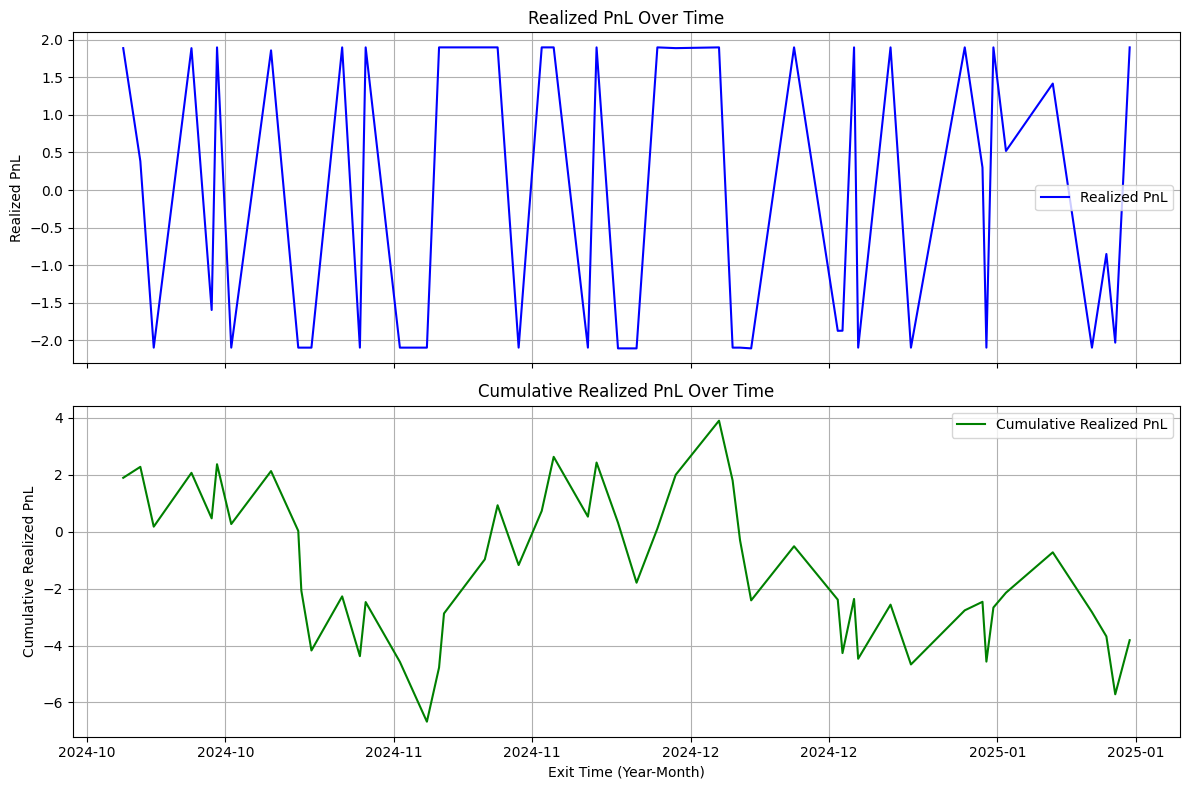

In [72]:
plot_realized_pnl(final_df)

In [25]:
final_df

,action,open_time,entry_price,max_high,min_low,close_time,close_price,hold_time,funding_fee_total,PnL,max_unrealized_loss,max_unrealized_profit,outcome,cumulative_pnl
0,Short,1735693200000,191.06,192.56,190.25,1735695000000,190.48682,0.5,0.0,0.2,-0.785094,0.423951,Win,0.2
1,Long,1735761600000,193.69,194.49,193.02,1735763400000,194.27107,0.5,0.0,0.2,-0.345914,0.413031,Win,0.4
2,Short,1736065800000,215.04,215.49,214.22,1736067600000,214.39488,0.5,0.0,0.2,-0.209263,0.381324,Win,0.6
3,Long,1736132400000,216.04,216.73,215.15,1736136000000,216.68812,1.0,0.0,0.2,-0.411961,0.319385,Win,0.8
4,Short,1736222400000,216.62,217.37,215.58,1736226000000,215.97014,1.0,0.0,0.2,-0.346228,0.480103,Win,1.0
5,Short,1736406000000,190.67,193.90,189.64,1736407800000,190.09799,0.5,0.0,0.2,-1.694026,0.540200,Win,1.2
6,Long,1736496000000,192.19,192.77,191.14,1736506800000,192.76657,3.0,0.0,0.2,-0.546334,0.301785,Win,1.4
7,Short,1736521200000,184.70,188.80,183.38,1736523000000,184.14590,0.5,0.0,0.2,-2.219816,0.714672,Win,1.6
8,Long,1736625600000,188.68,190.69,187.38,1736627400000,189.24604,0.5,0.0,0.2,-0.688997,1.065296,Win,1.8
9,Short,1736661600000,186.21,186.69,185.47,1736665200000,185.65137,1.0,0.0,0.2,-0.257773,0.397401,Win,2.0


# Looping

In [101]:
import pandas as pd
import numpy as np

# Define the range of profit and loss caps to test
profit_cap_list = np.arange(1, 5.1, 0.1).tolist()  # Example values for profit cap
loss_cap_list = np.arange(-1, -5.1, -0.1).tolist()    # Example values for loss cap

# Create a DataFrame to store results
results = []

# Loop through the combinations of profit and loss caps
for profit_cap in profit_cap_list:
    for loss_cap in loss_cap_list:
        # Apply the pnl_capping function
        df_capped = pnl_capping(df_backtest_recap_separated, profit_cap=profit_cap, loss_cap=loss_cap)
        
        # Calculate metrics
        positions_df = get_positions(df_capped,position_selection=1) # 1 for long, -1 for short
        metrics_df, _ = calculate_metrics(positions_df)
        
        # Extract metrics
        sharpe_ratio = metrics_df.loc[metrics_df['Metric'] == 'Sharpe Ratio', 'Value'].values[0]
        cumulative_pnl = metrics_df.loc[metrics_df['Metric'] == 'Cumulative PnL', 'Value'].values[0]
        win_rate = metrics_df.loc[metrics_df['Metric'] == 'Win Rate (%)', 'Value'].values[0]
        
        # Calculate profit_cap to loss_cap ratio
        profit_loss_ratio = abs(profit_cap / loss_cap)  # Absolute value to handle negative loss_cap
        
        # Store the results
        results.append({
            'Profit Cap': profit_cap, 
            'Loss Cap': loss_cap, 
            'Sharpe Ratio': sharpe_ratio, 
            'Cumulative PnL': cumulative_pnl,
            'Win Rate (%)': win_rate,
            'Profit/Loss Ratio': profit_loss_ratio
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Sort results by Sharpe Ratio, Win Rate, and Profit/Loss Ratio
results_df_sorted_sharpe = results_df.sort_values(by='Sharpe Ratio', ascending=False)
results_df_sorted_winrate = results_df.sort_values(by='Win Rate (%)', ascending=False)
results_df_sorted_profit_loss_ratio = results_df.sort_values(by='Profit/Loss Ratio', ascending=False)

# Filter results for Sharpe Ratio with Win Rate >= 50%
results_df_filtered_sharpe = results_df[results_df['Win Rate (%)'] >= 50].sort_values(by='Sharpe Ratio', ascending=False)

# Display the results
print("Results DataFrame:")
print(results_df_sorted_sharpe)

Results DataFrame:
      Profit Cap  Loss Cap  Sharpe Ratio  Cumulative PnL  Win Rate (%)  \
1271         4.1      -1.0      3.091593       23.414255          34.0   
1230         4.0      -1.0      2.946080       21.945895          34.0   
1107         3.7      -1.0      2.871177       20.516401          34.0   
1189         3.9      -1.0      2.791610       20.447534          34.0   
1312         4.2      -1.0      2.770723       21.448307          32.0   
...          ...       ...           ...             ...           ...   
365          1.8      -4.7     -4.983074      -31.032555          42.0   
366          1.8      -4.8     -4.993516      -31.232555          42.0   
367          1.8      -4.9     -5.003492      -31.432555          42.0   
359          1.8      -4.1     -5.089064      -31.755381          42.0   
360          1.8      -4.2     -5.115205      -32.155381          42.0   

      Profit/Loss Ratio  
1271           4.100000  
1230           4.000000  
1107          

In [95]:
# Print the best combinations
best_sharpe = results_df_sorted_sharpe.iloc[0]

print("\nBest Combination for Sharpe Ratio:")
print(f"Profit Cap: {best_sharpe['Profit Cap']}, Loss Cap: {best_sharpe['Loss Cap']}, "
      f"Sharpe Ratio: {best_sharpe['Sharpe Ratio']}, Cumulative PnL: {best_sharpe['Cumulative PnL']}, "
      f"Win Rate (%): {best_sharpe['Win Rate (%)']}, Profit/Loss Ratio: {best_sharpe['Profit/Loss Ratio']}")


Best Combination for Sharpe Ratio:
Profit Cap: 4.5000000000000036, Loss Cap: -2.100000000000001, Sharpe Ratio: 0.9638340992833716, Cumulative PnL: 10.179614222204487, Win Rate (%): 39.62264150943396, Profit/Loss Ratio: 2.1428571428571437


In [96]:
best_winrate = results_df_sorted_winrate.iloc[0]

print("\nBest Combination for Win Rate:")
print(f"Profit Cap: {best_winrate['Profit Cap']}, Loss Cap: {best_winrate['Loss Cap']}, "
      f"Sharpe Ratio: {best_winrate['Sharpe Ratio']}, Cumulative PnL: {best_winrate['Cumulative PnL']}, "
      f"Win Rate (%): {best_winrate['Win Rate (%)']}, Profit/Loss Ratio: {best_winrate['Profit/Loss Ratio']}")


Best Combination for Win Rate:
Profit Cap: 1.0, Loss Cap: -3.9000000000000026, Sharpe Ratio: -5.072162890900111, Cumulative PnL: -30.752208550691723, Win Rate (%): 58.490566037735846, Profit/Loss Ratio: 0.2564102564102562


In [97]:
best_profit_loss_ratio = results_df_sorted_profit_loss_ratio.iloc[0]

print("\nBest Combination for Profit/Loss Ratio:")
print(f"Profit Cap: {best_profit_loss_ratio['Profit Cap']}, Loss Cap: {best_profit_loss_ratio['Loss Cap']}, "
      f"Sharpe Ratio: {best_profit_loss_ratio['Sharpe Ratio']}, Cumulative PnL: {best_profit_loss_ratio['Cumulative PnL']}, "
      f"Win Rate (%): {best_profit_loss_ratio['Win Rate (%)']}, Profit/Loss Ratio: {best_profit_loss_ratio['Profit/Loss Ratio']}")


Best Combination for Profit/Loss Ratio:
Profit Cap: 5.0000000000000036, Loss Cap: -1.0, Sharpe Ratio: -0.25377376161726145, Cumulative PnL: -1.0293811455251116, Win Rate (%): 20.754716981132077, Profit/Loss Ratio: 5.0000000000000036


In [98]:
best_winrate_sharpe_ratio = results_df_sorted_sharpe[results_df_sorted_sharpe['Win Rate (%)'] >= 55].iloc[0]

print("\nBest Combination for Winrate & Sharpe Ratio:")
print(f"Profit Cap: {best_winrate_sharpe_ratio['Profit Cap']}, Loss Cap: {best_winrate_sharpe_ratio['Loss Cap']}, "
      f"Sharpe Ratio: {best_winrate_sharpe_ratio['Sharpe Ratio']}, Cumulative PnL: {best_winrate_sharpe_ratio['Cumulative PnL']}, "
      f"Win Rate (%): {best_winrate_sharpe_ratio['Win Rate (%)']}, Profit/Loss Ratio: {best_winrate_sharpe_ratio['Profit/Loss Ratio']}")


Best Combination for Winrate & Sharpe Ratio:
Profit Cap: 1.0, Loss Cap: -3.200000000000002, Sharpe Ratio: -4.557687569566559, Cumulative PnL: -25.118409355987207, Win Rate (%): 58.490566037735846, Profit/Loss Ratio: 0.31249999999999983


In [99]:
results_df_sorted_sharpe[results_df_sorted_sharpe['Win Rate (%)'] >= 55]

,Profit Cap,Loss Cap,Sharpe Ratio,Cumulative PnL,Win Rate (%),Profit/Loss Ratio
22,1.0,-3.2,-4.557688,-25.118409,58.490566,0.312500
23,1.0,-3.3,-4.637211,-26.018409,58.490566,0.303030
24,1.0,-3.4,-4.713237,-26.918409,58.490566,0.294118
25,1.0,-3.5,-4.776888,-27.706693,58.490566,0.285714
26,1.0,-3.6,-4.794701,-28.082781,58.490566,0.277778
27,1.0,-3.7,-4.846897,-28.782781,58.490566,0.270270
28,1.0,-3.8,-4.857077,-28.966995,58.490566,0.263158
29,1.0,-3.9,-5.072163,-30.752209,58.490566,0.256410
30,1.0,-4.0,-5.097479,-31.152209,58.490566,0.250000
21,1.0,-3.1,-5.108722,-28.308409,56.603774,0.322581


# Debugging

In [50]:
df_backtest_recap.head(40)

,time,open,high,low,close,ic_a,ic_b,macd,ema_200,trend,trend_12,trend_11,trend_10,Real_Action
0,1730419200000,168.62,169.07,168.48,168.97,174.7725,175.215,0.109011,174.641692,-1.0,-1.0,-1.0,-1.0,None
1,1730421000000,168.98,169.28,168.31,169.05,174.8025,174.960,0.133219,174.586053,-1.0,-1.0,-1.0,-1.0,Open Short
2,1730422800000,169.05,169.42,167.51,167.68,174.8025,174.805,0.064681,174.517336,-1.0,-1.0,-1.0,-1.0,Hold Short
3,1730424600000,167.67,168.20,166.35,167.16,174.8275,174.580,-0.004297,174.444129,-1.0,-1.0,-1.0,-1.0,Hold Short
4,1730426400000,167.16,167.81,165.33,167.66,174.8325,174.470,-0.004833,174.376625,-1.0,-1.0,-1.0,-1.0,Hold Short
5,1730428200000,167.66,167.80,166.48,167.57,173.8475,174.245,-0.000082,174.308897,-1.0,-1.0,-1.0,-1.0,Hold Short
6,1730430000000,167.57,167.93,167.30,167.92,173.3225,173.720,0.035812,174.245326,-1.0,-1.0,-1.0,-1.0,Hold Short
7,1730431800000,167.91,167.98,166.80,167.11,172.8225,173.220,0.015235,174.174328,-1.0,-1.0,-1.0,-1.0,Hold Short
8,1730433600000,167.10,167.49,166.96,167.05,172.8225,173.220,0.008170,174.103439,-1.0,-1.0,-1.0,-1.0,Hold Short
9,1730435400000,167.06,167.36,166.68,167.36,172.5425,173.220,0.033539,174.036340,-1.0,-1.0,-1.0,-1.0,Hold Short


In [34]:
def separate_open_close(df):
    # List to hold rows for final DataFrame
    new_rows = []
    
    for i, row in df.iterrows():
        action = row['Real_Action']
        
        # Check for combined 'Close' and 'Open' actions
        if isinstance(action, str) and 'and' in action:
            # Split the combined action into two separate actions
            actions = action.split('and')
            
            # Create the first row with the first action (Close)
            close_row = row.copy()
            close_row['Real_Action'] = actions[0].strip()  # "Close Long"
            new_rows.append(close_row)
            
            # Create the second row with the second action (Open)
            open_row = row.copy()
            open_row['Real_Action'] = actions[1].strip()  # "Open Short"
            new_rows.append(open_row)
        else:
            # If no combined action, just append the row
            new_rows.append(row)
    
    # Create a new DataFrame from the new_rows list
    df_separated = pd.DataFrame(new_rows).reset_index(drop=True)
    
    return df_separated

In [449]:
df_backtest_recap_separated = separate_open_close(df_backtest_recap)
df_backtest_recap_separated.head(40)

,time,open,high,low,close,ic_a,ic_b,macd,ema_200,trend,trend_12,trend_11,trend_10,Real_Action
0,1735689600000,189.22,191.230,189.00,190.61,191.6475,191.105,-0.727734,192.146857,-1.0,-1.0,-1.0,-1.0,None
1,1735691400000,190.60,192.580,190.55,192.44,191.7600,191.105,-0.512705,192.149774,-1.0,-1.0,-1.0,1.0,None
2,1735693200000,192.44,192.560,190.57,191.06,191.8675,191.105,-0.435859,192.138931,-1.0,-1.0,-1.0,1.0,Open Short
3,1735695000000,191.05,191.550,190.25,190.62,192.2725,191.105,-0.388670,192.123817,-1.0,-1.0,-1.0,1.0,Hold Short
4,1735696800000,190.63,191.140,190.31,190.56,193.0225,191.105,-0.337407,192.108256,-1.0,-1.0,-1.0,1.0,Hold Short
5,1735698600000,190.56,191.960,190.49,191.51,193.3300,191.105,-0.221052,192.102304,-1.0,-1.0,-1.0,1.0,Hold Short
6,1735700400000,191.52,191.520,190.47,190.51,194.2525,191.955,-0.193939,192.086460,-1.0,-1.0,-1.0,1.0,Hold Short
7,1735702200000,190.51,190.630,189.93,190.31,194.3825,192.085,-0.172687,192.068784,-1.0,-1.0,-1.0,1.0,Hold Short
8,1735704000000,190.31,190.310,189.53,189.77,194.3825,192.085,-0.177526,192.045910,-1.0,-1.0,-1.0,-1.0,Hold Short
9,1735705800000,189.77,189.800,189.25,189.41,194.5425,192.245,-0.186573,192.019682,-1.0,-1.0,-1.0,-1.0,Hold Short


In [35]:
def pnl_capping(df, profit_cap=None, loss_cap=None):
    """
    Calculate max and min profit/loss percentage for a trading cycle,
    and apply profit or loss capping if specified.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing the trading data.
    profit_cap (float or None): The cap percentage for profit. Should be positive. If None, no cap is applied.
    loss_cap (float or None): The cap percentage for loss. Should be negative. If None, no cap is applied.
    
    Returns:
    pd.DataFrame: DataFrame with updated close prices and calculated PnL.
    """
    # Validate profit_cap and loss_cap
    if profit_cap is not None and profit_cap <= 0:
        raise ValueError("profit_cap should be a positive number.")
    
    if loss_cap is not None and loss_cap >= 0:
        raise ValueError("loss_cap should be a negative number.")
    
    df_copy = df.copy()
    df_copy['max_pnl'] = None
    df_copy['min_pnl'] = None
    df_copy['profit_or_loss_first'] = None
    max_pnl = 0
    min_pnl = 0
    in_cycle = False
    entry_price = 0

    for i, row in df_copy.iterrows():
        # Start a new cycle when opening a position
        if row['Real_Action'] in ['Open Short', 'Open Long'] and not in_cycle:
            in_cycle = True
            entry_price = row['close']
        
        # Handle 'Hold' and 'Close' actions
        elif row['Real_Action'] in ['Hold Short', 'Hold Long', 'Close Short', 'Close Long'] and in_cycle :
            if row['Real_Action'] in ['Hold Short', 'Close Short']:
                max_pnl = (entry_price - row['low']) / entry_price * 100
                min_pnl = (entry_price - row['high']) / entry_price * 100
            elif row['Real_Action'] in ['Hold Long', 'Close Long']:
                max_pnl = (row['high'] - entry_price) / entry_price * 100
                min_pnl = (row['low'] - entry_price) / entry_price * 100

            # Update max_pnl and min_pnl
            df_copy.at[i, 'max_pnl'] = max_pnl
            df_copy.at[i, 'min_pnl'] = min_pnl

            # Apply loss cap
            if loss_cap is not None and min_pnl <= loss_cap:
                df_copy.at[i, 'profit_or_loss_first'] = 'Loss Capped'
                df_copy.at[i, 'close'] = (entry_price * (1 + loss_cap / 100) if row['Real_Action'] in ['Hold Long', 'Close Long']
                                            else entry_price * (1 - loss_cap / 100))
                df_copy.at[i, 'Real_Action'] = 'Close Long' if row['Real_Action'] in ['Hold Long', 'Close Long'] else 'Close Short'
                in_cycle = False
            
            # Apply profit cap
            elif profit_cap is not None and max_pnl >= profit_cap:
                df_copy.at[i, 'profit_or_loss_first'] = 'Profit Capped'
                df_copy.at[i, 'close'] = (entry_price * (1 + profit_cap / 100) if row['Real_Action'] in ['Hold Long', 'Close Long']
                                            else entry_price * (1 - profit_cap / 100))
                df_copy.at[i, 'Real_Action'] = 'Close Long' if row['Real_Action'] in ['Hold Long', 'Close Long'] else 'Close Short'
                in_cycle = False

    # Final adjustments for capped rows
    for i in range(len(df_copy)):
        profit_or_loss = df_copy.iloc[i]['profit_or_loss_first']
        if profit_or_loss == 'Profit Capped':
            df_copy.at[i, 'max_pnl'] = profit_cap
        elif profit_or_loss == 'Loss Capped':
            df_copy.at[i, 'min_pnl'] = loss_cap

    # Adjust Real_Action
    for i in range(1, len(df_copy)):
        current_action = df_copy.iloc[i]['Real_Action']
        previous_action = df_copy.iloc[i-1]['Real_Action']
        
        # If previous action is 'Close' (either 'Close Short' or 'Close Long') and current action is 'Hold' or 'Close'
        if previous_action in ['Close Short', 'Close Long'] and current_action in ['Hold Short', 'Hold Long', 'Close Short', 'Close Long']:
            df_copy.iloc[i, df_copy.columns.get_loc('Real_Action')] = None
        
        # If previous action is None, and current action is 'Hold' or 'Close'
        elif previous_action is None and current_action in ['Hold Long', 'Hold Short', 'Close Short', 'Close Long']:
            df_copy.iloc[i, df_copy.columns.get_loc('Real_Action')] = None

    return df_copy

In [533]:
df_backtest_recap_separated_capped = pnl_capping(df_backtest_recap_separated)
df_backtest_recap_separated_capped.head(40)

,time,open,high,low,close,ic_a,ic_b,macd,ema_200,trend,trend_12,trend_11,trend_10,Real_Action,max_pnl,min_pnl,profit_or_loss_first
0,1735689600000,189.22,191.230,189.00,190.61,191.6475,191.105,-0.727734,192.146857,-1.0,-1.0,-1.0,-1.0,None,None,None,None
1,1735691400000,190.60,192.580,190.55,192.44,191.7600,191.105,-0.512705,192.149774,-1.0,-1.0,-1.0,1.0,None,None,None,None
2,1735693200000,192.44,192.560,190.57,191.06,191.8675,191.105,-0.435859,192.138931,-1.0,-1.0,-1.0,1.0,Open Short,None,None,None
3,1735695000000,191.05,191.550,190.25,190.62,192.2725,191.105,-0.388670,192.123817,-1.0,-1.0,-1.0,1.0,Hold Short,0.423951,-0.256464,None
4,1735696800000,190.63,191.140,190.31,190.56,193.0225,191.105,-0.337407,192.108256,-1.0,-1.0,-1.0,1.0,Hold Short,0.392547,-0.041872,None
5,1735698600000,190.56,191.960,190.49,191.51,193.3300,191.105,-0.221052,192.102304,-1.0,-1.0,-1.0,1.0,Hold Short,0.298336,-0.471056,None
6,1735700400000,191.52,191.520,190.47,190.51,194.2525,191.955,-0.193939,192.086460,-1.0,-1.0,-1.0,1.0,Hold Short,0.308804,-0.240762,None
7,1735702200000,190.51,190.630,189.93,190.31,194.3825,192.085,-0.172687,192.068784,-1.0,-1.0,-1.0,1.0,Hold Short,0.591437,0.22506,None
8,1735704000000,190.31,190.310,189.53,189.77,194.3825,192.085,-0.177526,192.045910,-1.0,-1.0,-1.0,-1.0,Hold Short,0.800796,0.392547,None
9,1735705800000,189.77,189.800,189.25,189.41,194.5425,192.245,-0.186573,192.019682,-1.0,-1.0,-1.0,-1.0,Hold Short,0.947346,0.659479,None


In [562]:
df_backtest_recap_separated_capped = pnl_capping(df_backtest_recap_separated, profit_cap=4, loss_cap=-2)
df_backtest_recap_separated_capped

,time,open,high,low,close,ic_a,ic_b,macd,ema_200,trend,trend_12,trend_11,trend_10,Real_Action,max_pnl,min_pnl,profit_or_loss_first
0,1735689600000,189.22,191.23,189.00,190.61,191.6475,191.105,-0.727734,192.146857,-1.0,-1.0,-1.0,-1.0,None,None,None,None
1,1735691400000,190.60,192.58,190.55,192.44,191.7600,191.105,-0.512705,192.149774,-1.0,-1.0,-1.0,1.0,None,None,None,None
2,1735693200000,192.44,192.56,190.57,191.06,191.8675,191.105,-0.435859,192.138931,-1.0,-1.0,-1.0,1.0,Open Short,None,None,None
3,1735695000000,191.05,191.55,190.25,190.62,192.2725,191.105,-0.388670,192.123817,-1.0,-1.0,-1.0,1.0,Hold Short,0.423951,-0.256464,None
4,1735696800000,190.63,191.14,190.31,190.56,193.0225,191.105,-0.337407,192.108256,-1.0,-1.0,-1.0,1.0,Hold Short,0.392547,-0.041872,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
670,1736890200000,187.42,187.42,186.58,187.19,183.9525,177.560,-0.105562,186.646272,1.0,1.0,1.0,-1.0,Hold Long,2.00283,1.545662,None
671,1736892000000,187.18,187.81,186.98,187.80,184.9400,178.240,-0.054751,186.657752,1.0,1.0,1.0,-1.0,Hold Long,2.215087,1.763361,None
672,1736893800000,187.80,188.74,187.64,188.61,186.2050,178.845,0.027474,186.677177,1.0,1.0,1.0,1.0,Hold Long,2.721237,2.122564,None
673,1736895600000,188.61,188.74,187.72,187.84,186.3275,178.845,0.024185,186.688747,1.0,1.0,1.0,1.0,Hold Long,2.721237,2.166104,None


In [499]:
df_backtest_recap_separated_capped.to_csv('df_backtest_recap_separated_capped.csv', index=True)

In [563]:
print(f'Max_pnl: {df_backtest_recap_separated_capped['max_pnl'].max()}')
print(f'Min_pnl: {df_backtest_recap_separated_capped['min_pnl'].min()}')

Max_pnl: 4
Min_pnl: -2


In [36]:
import pandas as pd

def get_positions(df):
    
    positions = []
    position = None
    max_high = -float('inf')
    min_low = float('inf')
    entry_price = None
    close_price = None
    
    for i, row in df.iterrows():
        # Ensure 'Real_Action' is not None and important columns are not NaN
        if pd.isna(row['Real_Action']) or pd.isna(row['close']) or pd.isna(row['time']):
            continue  # Skip rows with missing data
        
        # Check for open positions (handling cases where 'Open' and 'Close' happen in the same row)
        if 'Open' in row['Real_Action']:
            if position:  # If there is a previous position, store it
                position['max_high'] = max_high
                position['min_low'] = min_low
                positions.append(position)

            # Start a new position
            entry_price = row['close']  # The entry price is the close price at the open time
            position = {
                'action': 'Short' if 'Short' in row['Real_Action'] else 'Long',
                'open_time': row['time'],
                'entry_price': entry_price,
                'max_high': row['high'],
                'min_low': row['low'],
                'close_time': None,  # Initialize as None
                'close_price': None  # Initialize as None
            }
            max_high = row['high']
            min_low = row['low']
        
        # Update max high and min low during 'Hold' positions
        elif 'Hold' in row['Real_Action']:
            if position:
                max_high = max(max_high, row['high'])
                min_low = min(min_low, row['low'])

        # Check for close positions
        elif 'Close' in row['Real_Action']:
            if position:
                close_price = row['close']  # The close price is the close price at the close time
                position['close_time'] = row['time']
                position['close_price'] = close_price
                position['max_high'] = max(max_high, row['high'])
                position['min_low'] = min(min_low, row['low'])
                positions.append(position)
                position = None
                max_high = -float('inf')
                min_low = float('inf')
    
    # Handle the case where a position is not closed at the end of the DataFrame
    if position:
        position['max_high'] = max_high
        position['min_low'] = min_low
        positions.append(position)

    # Convert positions to DataFrame
    positions_df = pd.DataFrame(positions)

    positions_df.dropna(subset=['close_time'],inplace=True)

    # # Calculate PnL and add it as a new column
    # positions_df['pnl'] = positions_df.apply(
    #     lambda row: ((row['close_price'] - row['entry_price']) / row['entry_price'] * 100) if row['action'] == "Long" 
    #     else ((row['entry_price'] - row['close_price']) / row['entry_price'] * 100),
    #     axis=1)

    return positions_df

In [69]:
positions_df = get_positions(df_backtest_recap_separated_capped)
# print(f'Max PnL: {positions_df['pnl'].max()}')
# print(f'Min PnL: {positions_df['pnl'].min()}')
positions_df

,action,open_time,entry_price,max_high,min_low,close_time,close_price
0,Short,1727742600000,154.107,154.692,152.467,1727748000000,153.336465
1,Short,1727789400000,153.664,155.176,152.362,1727791200000,152.895680
2,Long,1728028800000,140.377,142.333,139.096,1728045000000,141.078885
3,Short,1728160200000,141.076,143.471,141.004,1728178200000,143.448000
4,Long,1728201600000,143.204,143.445,142.554,1728203400000,141.781380
...,...,...,...,...,...,...,...
98,Long,1736625600000,188.680,190.690,187.380,1736627400000,189.623400
99,Short,1736661600000,186.210,186.840,185.040,1736674200000,185.278950
100,Long,1736694000000,190.340,190.980,186.440,1736719200000,186.533200
101,Short,1736719200000,186.660,191.110,186.440,1736726400000,190.393200


In [565]:
# Calculate PnL and add it as a new column
calc_pnl = positions_df.copy()

calc_pnl['pnl'] = calc_pnl.apply(
    lambda row: ((row['close_price'] - row['entry_price']) / row['entry_price'] * 100) if row['action'] == "Long" 
    else ((row['entry_price'] - row['close_price']) / row['entry_price'] * 100),
    axis=1)

print(f'Max PnL: {calc_pnl['pnl'].max()}')
print(f'Min PnL: {calc_pnl['pnl'].min()}')
calc_pnl

Max PnL: 4.7002123534299844
Min PnL: -2.000000000000009


,action,open_time,entry_price,max_high,min_low,close_time,close_price,pnl
0,Short,1735693200000,191.06,192.65,187.82,1735758000000,192.2700,-0.633309
1,Long,1735761600000,193.69,198.88,193.02,1735783200000,198.7024,2.587847
2,Short,1736065800000,215.04,216.07,211.27,1736128800000,215.0900,-0.023251
3,Long,1736132400000,216.04,223.14,213.10,1736217000000,216.4600,0.194408
4,Short,1736222400000,216.62,217.37,205.00,1736262000000,206.4384,4.700212
5,Short,1736406000000,190.67,193.90,182.64,1736452800000,183.0432,4.000000
6,Long,1736496000000,192.19,192.77,184.86,1736515800000,188.3462,-2.000000
7,Short,1736521200000,184.70,188.80,183.38,1736523000000,188.3940,-2.000000
8,Long,1736625600000,188.68,191.82,187.15,1736641800000,187.2600,-0.752597
9,Short,1736661600000,186.21,188.40,185.04,1736686800000,188.2200,-1.079426


In [37]:
import pandas as pd
import numpy as np

def calculate_metrics(df, maker_fee = 0.05, funding_rate = 0.01, risk_free_rate = 0.046):
    # Initialize the metrics dictionary
    metrics = {
        'total_rows': len(df),
        'short_count': len(df[df['action'] == 'Short']),
        'long_count': len(df[df['action'] == 'Long']),
        'winrate': None,
        'short_winrate': None,
        'long_winrate': None,
        'cumulative_pnl': None,
        'pnl_stats': None,
        'unrealized_stats': None,
        'hold_time_stats': None,
        'unrealized_vs_pnl_check': [],  # To store the check results
        'longest_lose_streak': None,
        'longest_lose_streak_cum_pnl': None,
        'most_negative_cum_pnl': None,
        'longest_win_streak': None,
        'longest_win_streak_cum_pnl': None,
        'most_positive_cum_pnl': None,
        'sharpe_ratio': None  # Placeholder for Sharpe ratio
    }

    # Initialize the cumulative PnL list and other tracking variables
    cumulative_pnl = 0
    cumulative_pnls = []
    
    longest_lose_streak = 0
    current_lose_streak = 0
    longest_lose_streak_cum_pnl = 0
    current_lose_streak_cum_pnl = 0
    most_negative_cum_pnl = float('inf')
    
    longest_win_streak = 0
    current_win_streak = 0
    longest_win_streak_cum_pnl = 0
    current_win_streak_cum_pnl = 0
    most_positive_cum_pnl = float('-inf')

    for i, row in df.iterrows():
        entry_price = row['entry_price']
        close_price = row['close_price']
        max_high = row['max_high']
        min_low = row['min_low']
        action = row['action']
        open_time = row['open_time']
        close_time = row['close_time']

        # Calculate hold time in hours (close_time - open_time)
        hold_time_ms = close_time - open_time
        hold_time_hours = hold_time_ms / (1000 * 3600)  # Convert milliseconds to hours
        df.at[i, 'hold_time'] = hold_time_hours

        # Calculate how many funding rates does the position got
        funding_rate_occurence = hold_time_hours // 8
        funding_fee_total = funding_rate_occurence * funding_rate
        df.at[i, 'funding_fee_total'] = funding_fee_total

        # Calculate PnL
        if action == 'Short':
            pnl = ((entry_price - close_price) / entry_price) * 100 
        elif action == 'Long':
            pnl = ((close_price - entry_price) / entry_price) * 100
        else :
            pnl = np.nan
        
        # Apply maker fee (0.05%)
        pnl -= (2 * maker_fee)

        # Apply funding fee (0.1%)
        pnl -= funding_fee_total

        df.at[i, 'PnL'] = pnl

        # Calculate max unrealized loss and profit
        if action == 'Short':
            max_unrealized_loss = ((entry_price - max_high) / entry_price) * 100
            max_unrealized_profit = ((entry_price - min_low) / entry_price) * 100
        elif action == 'Long':
            max_unrealized_profit = ((max_high - entry_price) / entry_price) * 100
            max_unrealized_loss = ((min_low - entry_price) / entry_price) * 100
        else :
            max_unrealized_profit = np.nan
            max_unrealized_loss = np.nan
        
        df.at[i, 'max_unrealized_loss'] = max_unrealized_loss
        df.at[i, 'max_unrealized_profit'] = max_unrealized_profit

        # Set the outcome based on PnL
        if pnl >= 0:
            df.at[i, 'outcome'] = 'Win'
            if current_lose_streak > longest_lose_streak:
                longest_lose_streak = current_lose_streak
                longest_lose_streak_cum_pnl = current_lose_streak_cum_pnl
            current_lose_streak = 0
            current_lose_streak_cum_pnl = 0

            # Track win streak
            current_win_streak += 1
            current_win_streak_cum_pnl += pnl
            most_positive_cum_pnl = max(most_positive_cum_pnl, cumulative_pnl)
        elif pnl < 0:
            df.at[i, 'outcome'] = 'Lose'
            current_lose_streak += 1
            current_lose_streak_cum_pnl += pnl
            
            # Track win streak reset
            longest_win_streak = max(longest_win_streak, current_win_streak)
            longest_win_streak_cum_pnl = max(longest_win_streak_cum_pnl, current_win_streak_cum_pnl)
            current_win_streak = 0
            current_win_streak_cum_pnl = 0
        else :
            df.at[i, 'outcome'] = None
        
        # Add cumulative PnL
        cumulative_pnl += pnl
        cumulative_pnls.append(cumulative_pnl)
        
        # Track the most negative cumulative PnL
        most_negative_cum_pnl = min(most_negative_cum_pnl, cumulative_pnl)

        # Check if max_unrealized_loss_min is smaller than PnL_min
        pnl_min = df['PnL'].min()
        unrealized_loss_min = df['max_unrealized_loss'].min()

        if unrealized_loss_min < pnl_min:
            unrealized_check = 'Unrealized Loss Min is smaller than PnL Min'
        elif unrealized_loss_min > pnl_min:
            unrealized_check = 'Unrealized Loss Min is greater than PnL Min'
        else:
            unrealized_check = 'Unrealized Loss Min is equal to PnL Min'

        metrics['unrealized_vs_pnl_check'].append(unrealized_check)

    df['cumulative_pnl'] = cumulative_pnls
    
    # Get the last cumulative PnL value
    metrics['cumulative_pnl'] = cumulative_pnls[-1] if cumulative_pnls else None

    # Calculate win rate
    win_count = len(df[df['outcome'] == 'Win'])
    total_count = len(df)
    metrics['winrate'] = (win_count / total_count) * 100 if total_count > 0 else 0  # Convert to percentage
    
    # Calculate short and long win rates
    short_win_count = len(df[(df['action'] == 'Short') & (df['outcome'] == 'Win')])
    long_win_count = len(df[(df['action'] == 'Long') & (df['outcome'] == 'Win')])
    metrics['short_winrate'] = (short_win_count / metrics['short_count']) * 100 if metrics['short_count'] > 0 else 0
    metrics['long_winrate'] = (long_win_count / metrics['long_count']) * 100 if metrics['long_count'] > 0 else 0

    # Calculate statistics for PnL, max unrealized loss, max unrealized profit, and hold time
    metrics['pnl_stats'] = {
        'max': df['PnL'].max(),
        'min': df['PnL'].min(),
        'mean': df['PnL'].mean(),
        'median': df['PnL'].median()
    }
    
    metrics['unrealized_stats'] = {
        'max_unrealized_loss_max': df['max_unrealized_loss'].max(),
        'max_unrealized_loss_min': df['max_unrealized_loss'].min(),
        'max_unrealized_loss_mean': df['max_unrealized_loss'].mean(),
        'max_unrealized_loss_median': df['max_unrealized_loss'].median(),
        'max_unrealized_profit_max': df['max_unrealized_profit'].max(),
        'max_unrealized_profit_min': df['max_unrealized_profit'].min(),
        'max_unrealized_profit_mean': df['max_unrealized_profit'].mean(),
        'max_unrealized_profit_median': df['max_unrealized_profit'].median()
    }
    
    metrics['hold_time_stats'] = {
        'max': df['hold_time'].max(),
        'min': df['hold_time'].min(),
        'mean': df['hold_time'].mean(),
        'median': df['hold_time'].median()
    }

    # Store the longest lose streak and cumulative PnL
    metrics['longest_lose_streak'] = longest_lose_streak
    metrics['longest_lose_streak_cum_pnl'] = longest_lose_streak_cum_pnl
    metrics['most_negative_cum_pnl'] = most_negative_cum_pnl

    # Store the longest win streak and cumulative PnL
    metrics['longest_win_streak'] = longest_win_streak
    metrics['longest_win_streak_cum_pnl'] = longest_win_streak_cum_pnl
    metrics['most_positive_cum_pnl'] = most_positive_cum_pnl

    # Calculate the Sharpe ratio
    returns = df['PnL'] / 100  # Convert percentage to decimal
    excess_returns = returns - risk_free_rate / 252  # Assuming daily returns, 252 trading days in a year
    sharpe_ratio = excess_returns.mean() / excess_returns.std() * np.sqrt(252) if excess_returns.std() != 0 else np.nan
    metrics['sharpe_ratio'] = sharpe_ratio

    # Convert metrics into a DataFrame for neat display
    metrics_df = pd.DataFrame({
        'Metric': [
            'Total Trades', 'Short Count', 'Long Count', 'Win Rate (%)', 'Short Win Rate (%)', 'Long Win Rate (%)', 
            'Cumulative PnL', 'PnL Max', 'PnL Min', 'PnL Mean', 'PnL Median', 
            'Max Unrealized Loss Max', 'Max Unrealized Loss Min', 
            'Max Unrealized Loss Mean', 'Max Unrealized Loss Median', 
            'Max Unrealized Profit Max', 'Max Unrealized Profit Min', 
            'Max Unrealized Profit Mean', 'Max Unrealized Profit Median', 
            'Hold Time Max', 'Hold Time Min', 'Hold Time Mean', 'Hold Time Median',
            'Unrealized vs PnL Check', 
            'Longest Lose Streak', 'Longest Lose Streak Cumulative PnL', 'Most Negative Cumulative PnL',
            'Longest Win Streak', 'Longest Win Streak Cumulative PnL', 'Most Positive Cumulative PnL',
            'Sharpe Ratio'
        ],
        'Value': [
            metrics['total_rows'], metrics['short_count'], metrics['long_count'], 
            metrics['winrate'], metrics['short_winrate'], metrics['long_winrate'],
            metrics['cumulative_pnl'], metrics['pnl_stats']['max'], metrics['pnl_stats']['min'],
            metrics['pnl_stats']['mean'], metrics['pnl_stats']['median'],
            metrics['unrealized_stats']['max_unrealized_loss_max'], metrics['unrealized_stats']['max_unrealized_loss_min'],
            metrics['unrealized_stats']['max_unrealized_loss_mean'], metrics['unrealized_stats']['max_unrealized_loss_median'],
            metrics['unrealized_stats']['max_unrealized_profit_max'], metrics['unrealized_stats']['max_unrealized_profit_min'],
            metrics['unrealized_stats']['max_unrealized_profit_mean'], metrics['unrealized_stats']['max_unrealized_profit_median'],
            metrics['hold_time_stats']['max'], metrics['hold_time_stats']['min'],
            metrics['hold_time_stats']['mean'], metrics['hold_time_stats']['median'],
            metrics['unrealized_vs_pnl_check'],
            metrics['longest_lose_streak'], metrics['longest_lose_streak_cum_pnl'], metrics['most_negative_cum_pnl'],
            metrics['longest_win_streak'], metrics['longest_win_streak_cum_pnl'], metrics['most_positive_cum_pnl'],
            metrics['sharpe_ratio']
        ]
    })
    
    return metrics_df, df

In [567]:
metrics_df, final_df = calculate_metrics(positions_df)

metrics_df

,Metric,Value
0,Total Trades,13
1,Short Count,7
2,Long Count,6
3,Win Rate (%),46.153846
4,Short Win Rate (%),42.857143
5,Long Win Rate (%),50.0
6,Cumulative PnL,6.636207
7,PnL Max,4.590212
8,PnL Min,-2.1
9,PnL Mean,0.510477


In [164]:
final_df

,action,open_time,entry_price,max_high,min_low,close_time,close_price,hold_time,funding_fee_total,PnL,max_unrealized_loss,max_unrealized_profit,outcome,cumulative_pnl
0,Short,1730421000000,169.05,169.420,165.33,1730426400000,165.66900,1.5,0.00,1.900000,-0.218870,2.200532,Win,1.900000
1,Long,1730467800000,172.92,173.990,163.00,1730475000000,177.24300,2.0,0.00,2.400000,-5.736757,0.618783,Win,4.300000
2,Short,1730475000000,164.00,169.620,163.00,1730512800000,159.90000,10.5,0.01,2.390000,-3.426829,0.609756,Win,6.690000
3,Short,1730599200000,163.01,164.770,158.68,1730644200000,159.74980,12.5,0.01,1.890000,-1.079688,2.656279,Win,8.580000
4,Long,1730687400000,164.35,164.953,160.00,1730709000000,168.45875,6.0,0.00,2.400000,-2.646790,0.366900,Win,10.980000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,Short,1735565400000,189.00,193.770,185.81,1735581600000,184.27500,4.5,0.00,2.400000,-2.523810,1.687831,Win,99.582544
59,Long,1735581600000,193.47,196.400,189.00,1735594200000,189.32000,3.5,0.00,-2.245035,-2.310436,1.514447,Lose,97.337509
60,Short,1735594200000,189.32,194.170,187.91,1735637400000,184.58700,12.0,0.01,2.390000,-2.561800,0.744771,Win,99.727509
61,Long,1735639200000,194.24,198.360,192.90,1735655400000,198.12480,4.5,0.00,1.900000,-0.689868,2.121087,Win,101.627509
